In [195]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from typing import Sequence, Callable, Tuple, Union
import flax
from flax import linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt

In [ ]:
def amh(target_log_pdf, key: jax.random.PRNGKey, d: int, m: int, gamma_init: float, alpha_star: float = 0.234):
    x = jnp.zeros((d,))
    mu = jnp.zeros((d,))
    sigma = jnp.eye(d)
    lam = 1.0

    samples = jnp.zeros((m, d))
    musis = jnp.zeros((m, d))
    sigmis = jnp.zeros((m, d, d)).at[0].set(jnp.eye(d))
    lambdis = jnp.zeros((m,))
    accept_status = jnp.zeros((m,), dtype=bool)

    def gamma_(g, i):
        return g * (1 - (i / m))

    def step(carry, i):
        x, gamma, mu, sigma, lam, key = carry
        
        sample_key, uni_key, key = jax.random.split(key, 3)

        # sample from the proposal distribution
        x_prop = x + jax.random.multivariate_normal(sample_key, mean = jnp.zeros(d), cov = lam * sigma)

        # compute the acceptance probability
        alpha = target_log_pdf(x_prop + 1e-6) - target_log_pdf(x + 1e-6)
        alpha = jnp.minimum(1.0, alpha)

        # accept or reject the new sample
        accept = jnp.log(jax.random.uniform(uni_key)) < alpha
        x_new = jnp.where(accept, x_prop, x)

        # update the parameters
        mu_new = mu + gamma * (x_new - mu)
        sigma_new = sigma + gamma * ((x_new - mu)[:, None] @ (x_new - mu)[None, :] - sigma)
        log_lam = jnp.log(lam) + gamma * (jnp.exp(alpha) - alpha_star)
        lam_new = jnp.exp(log_lam)

        gamma = gamma_(gamma, i)

        outputs = (x_new, mu_new, sigma_new, lam_new, accept)

        return (x_new, gamma, mu_new, sigma_new, lam_new, key), outputs

    carry = (x, gamma_init, mu, sigma, lam, key)
    _, (xs, mus, Sigmas, lambdas, acc) = jax.lax.scan(
        step, carry, jnp.arange(1, m)
    )

    # add initial values
    samples = samples.at[1:].set(xs)
    musis = musis.at[1:].set(mus)
    sigmis = sigmis.at[1:].set(Sigmas)
    lambdis = lambdis.at[1:].set(lambdas)
    accept_status = accept_status.at[1:].set(acc)

    return samples, musis, sigmis, lambdas, accept_status

In [119]:
def target_density(x):
    """example: gaussian mixture"""
    # two component gaussian mixture, each component at (-5, 0) and (5, 0)

    mu1 = jnp.array([-5.0])
    mu2 = jnp.array([5.0])
    sigma = 1.0
    
    log_p1 = -0.5 * jnp.sum(((x - mu1) / sigma) ** 2)
    log_p2 = -0.5 * jnp.sum(((x - mu2) / sigma) ** 2)
    return jnp.logaddexp(log_p1, log_p2)  # log(exp(log_p1) + exp(log_p2))

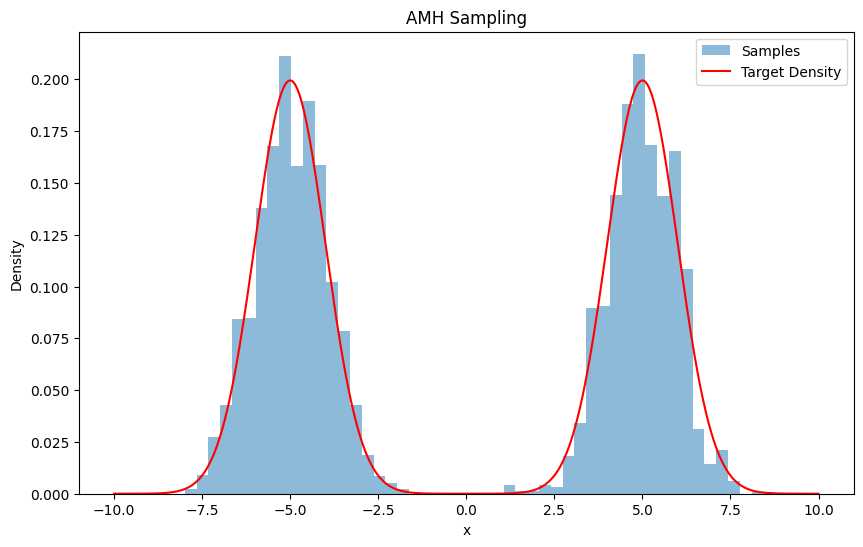

In [136]:
samples, musis, sigmis, lambdas, accept_status = amh(
    target_density,
    key=jax.random.PRNGKey(0),
    d=1,
    m=10_000,
    gamma_init=0.1,
)
# Plotting the results

import scipy.integrate as spi

norm = spi.quad(lambda x: np.exp(target_density(x)), -10, 10)[0]

plt.figure(figsize=(10, 6))
plt.hist(samples[:, 0], bins=50, density=True, alpha=0.5, label='Samples')
x = np.linspace(-10, 10, 1000)
plt.plot(x, np.exp(jax.vmap(target_density)(x[:, None]))/norm, label='Target Density', color='red')
plt.title('AMH Sampling')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [146]:
jnp.mean(accept_status[-500:])

Array(0.078, dtype=float32)

In [147]:
accept_status

Array([False,  True,  True, ..., False, False,  True], dtype=bool)

In [135]:
sigmis

Array([[[ 1.       ]],

       [[ 1.02518  ]],

       [[ 1.4969472]],

       ...,

       [[28.582071 ]],

       [[28.582071 ]],

       [[28.582071 ]]], dtype=float32)

In [148]:
# so far, we have:

# 1. The target density distribution to sample from (an example. In the future, we will use a variational 
#    wavefunction to sample configurations from and minimize its energy, it will be the so-.called RL-VMC method
#    that combines reinforcement learning and quantum variational Monte Carlo)

# 2. the adaptive metropolis hastings algorithm to sample initial configurations from the target density in order
#    to warm up the rl agent

# TODO: - write rl problem: first, the actor network as the paper says (eq 30)
#       - the critic network (ffnn) where the output is the value of the state and actions proposed
#       - write the loss function from actor network (ddpg algo)
#       - write the loss function from critic network (ddpg algo)
#       - write the replay buffer
#       - write the training loop

### 1. actor network

the actor is the behaviour policy of the DDPG algorithm. According to the paper:

state: $s_n = (x_n, x^*_{n+1})$
action: $a_n = (\phi_\theta(x_n), \phi_\theta(x^*_{n+1}))$

the actor must take the state containing the current configuration x_n and the proposed configuration $x^*_{n+1}$, and then propose the means $\phi_\theta(x_n)$ and $\phi_\theta(x^*_{n+1})$ for the proposals of the next configurations. The considerations of the function \phi can be found in paper appendix B.3, summarized below.

Let $\psi_\theta: \mathbb{R}^d \rightarrow \mathbb{R}^d$ be a collection of functions indexed by $\theta\in\mathbb{R}^p$ such that $(\theta, x)\mapsto \psi_\theta (x)$ is \textit{locally Lipschitz} over $(\theta, x)\in\mathbb{R}^p \times\mathbb{R}^d$. Let $C\subset \mathbb{R}^d$ be a compact set and let $\gamma_C:\mathbb{R}^d \rightarrow \mathbb{R}$ be a smooth function with $\gamma_C (x) = 1$ for $x\in C^\complement$. They propose to set the actor as:

$$\phi_\theta (x) \coloneqq \psi_\theta (x) + \gamma_C (x)[x - \psi_\theta (x)]$$

for all $x\in \mathbb{R}^d$ and $\theta\in\mathbb{R}^p$. This construction ensures that the regularity conditions needed are satisfied, so that the ergodicity of the RLMH can be guaranteed.

To implement this construction, we need some things: 1. the map $\psi_\theta: \mathbb{R}^d \rightarrow \mathbb{R}^d$, 2. a compact set $C\subset \mathbb{R}^d$, and 3. a smooth function $\gamma_C$ that vanishes on $C^\complement$. The use:

- $\psi_\theta (x) = \overline{x} + \Sigma^{1/2}\nu_\theta (x)$, where $\overline{x}$ is the mean and $\Sigma\in S_d^+$ is the covariance matrix obtained from the warm-up samples $(x_i)_{i=-m+1}^{0}$, and $\nu_\theta : \mathbb{R}^d \rightarrow \mathbb{R}^d$ is a neural network.
- The set $C$ is $C = \{x\in\mathbb{R}^d: \eta(x)\le 1\}$, such that $\eta(x)\coloneqq||\Sigma^{-1/2}(x - \overline{x})||^2/l^2$, where $l>0$ is a radius to be specified (in their case, $l=10$ representing 10 standard deviations from the mean of $p(\cdot)$ which ensures that the symmetric random walk behaviour is rarely encountered).
- The map $\gamma_C$ is taken
$$\gamma_C(x) = \gamma(\eta(x)) = \gamma(\eta) \coloneqq \begin{cases}0, & \eta\in[0,1/2]\\ \left[1 + \exp\left(-\frac{4\eta - 3}{4\eta^2 - 6\eta + 2}\right)\right]^{-1}, &\eta\in[1/2, 1]\\ 1, &\eta[1, \infty)\end{cases}$$

In [182]:
# phi network
class phi_theta(nn.Module):
    '''phi network for the proposal distribution
    
    Args:
        - mean: mean of the warm-up samples
        - sigma: covariance from the warm-up samples
        - features: sequence of int, the number of features for each layer

    Input:
        - x: state of the system
    
    Output:
        - phi(x): the proposed mean for the proposal distribution'''
    
    features: Sequence[int]
    mean: jnp.ndarray
    sigma: jnp.ndarray
    l: float = 10.
    def setup(self):
        # square root of the covariance matrix
        sigma_reg = self.sigma + 1e-6 * jnp.eye(self.sigma.shape[0]) # regularization
        eigvals, eigvecs = jnp.linalg.eigh(sigma_reg)
        inv_sqrt_diag = jnp.diag(1-0 / jnp.sqrt(eigvals))
        sqrt_diag = jnp.diag(jnp.sqrt(eigvals))
        self.inv_sqrt_sigma = eigvecs @ inv_sqrt_diag @ eigvecs.T
        self.sqrt_sigma = eigvecs @ sqrt_diag @ eigvecs.T
        
        # layers
        features_plus = self.features + (self.sigma.shape[0],)
        layer_list = []
        for i in range(len(features_plus) - 1):
            layer_list.append(nn.Dense(self.features[i], kernel_init=nn.initializers.xavier_uniform()))
            layer_list.append(nn.relu)
        self.input_layers = nn.Sequential(layer_list)
        self.output_layers = nn.Dense(features_plus[-1])
    
    def __call__(self, x):
        # ffnn (nu_theta) for psi_theta (psi: d -> d)

        nu_x = x
        nu_x = self.input_layers(nu_x)
        nu_x = self.output_layers(nu_x)

        # define psi
        psi = self.mean + self.sqrt_sigma @ nu_x

        # define phi
        phi = psi + self.gamma(x) * (x - psi)
        return phi

    def gamma(self, x):
        eta = jnp.linalg.norm(self.inv_sqrt_sigma @ (x - self.mean))**2/self.l**2
        f = lambda eta : jnp.pow(1 + jnp.exp(-(4*eta - 3)/(4*eta*eta - 6*eta + 2)), -1)
        gamma = jnp.where(0 < eta and eta < 0.5, 0., f(eta))
        gamma = jnp.where(eta > 1, 1., gamma)
        return gamma

In [188]:
# example of phi network
key = jax.random.PRNGKey(0)
d = 2
m = 10_000
gamma_init = 0.1
features = [64, 64]
mean = jnp.zeros((d,))
sigma = jnp.eye(d)
phi_net = phi_theta(mean=mean, sigma=sigma, features=features)
x = jnp.ones((d,))
params = phi_net.init(key, x)
phi_net.apply(params, x)

Array([-0.09913199, -0.03179026], dtype=float32)

In [190]:
class actor(nn.Module):
    '''phi network for the proposal distribution
    
    Args:
        - mean: mean of the warm-up samples
        - sigma: covariance from the warm-up samples
        - features: sequence of int, the number of features for each layer

    Input:
        - x: state of the system
    
    Output:
        - phi(x): the proposed mean for the proposal distribution'''
    
    features: Sequence[int]
    mean: jnp.ndarray
    sigma: jnp.ndarray
    l: float = 10.

    def setup(self):
        self.phi_net = phi_theta(mean=self.mean, sigma=self.sigma, features=self.features)
    
    def __call__(self, state):
        # ffnn (nu_theta) for psi_theta (psi: d -> d)
        d = sigma.shape[0]
        x = state[:d]
        x_prop = state[d:]
        phi = self.phi_net(x)
        phi_prop = self.phi_net(x_prop)

        # define the actor
        actor = jnp.concatenate((phi, phi_prop), axis=0)
        return actor

In [191]:
# example of actor
key = jax.random.PRNGKey(0)
d = 2
m = 10_000
gamma_init = 0.1
features = [64, 64]
mean = jnp.zeros((d,))
sigma = jnp.eye(d)
actor_net = actor(mean=mean, sigma=sigma, features=features)
x = jnp.ones((d,))
x_prop = jnp.ones((d,))
state = jnp.concatenate((x, x_prop), axis=0)
params = actor_net.init(key, state)
print(actor_net.apply(params, state))

[-0.11515348  0.20030667 -0.11515348  0.20030667]


### 2. Critic network

Now, the critic network must take as input the current state and the action taken, and it must output a single scalar representing the value of that state-action pair. That is, the critic $Q_\omega (s_n, a_n)$ is the approximation to the action-value function, that must be approximated through a RL loss function using Bellman equations. 

Now, for a given states and next states $(s_n, a_n, r_n, s_{n+1})$, then $Q_\omega (s_n, a_n)$ gives the value function for that pair, and given the Bellman equation:

$$Q_\omega (s_n, a_n) = \mathbb{E}_{s_{n+1}\sim D_\pi, a_n\sim \pi}[r_n + \gamma Q_\omega (s_{n+1}, \pi(s_{n+1}))]$$

then the DDPG critic network is training by solving the optimization problem

$$\argmin_\omega \mathbb{E}_{s_n\sim D_{\pi}, a_n\sim\pi}[(Q_\omega (s_n, a_n) - y_n)^2]$$

where $y_n = r_n + \gamma Q_\omega (s_{n+1}, \pi(s_{n+1}))$.

In [193]:
# 2. critic net for DDPG
class critic(nn.Module):
    """a simple ffnn critic network (see appendix B.4)"
    
    Args:
        features: sequence of int, the number of units in each layer. The first must be 2*d x 2*d (Q: 2d x 2d -> 1)

    Returns:
        q_value: jnp.ndarray shape (batch_size, 1)

    """
    features: Sequence[int]
    def setup(self):
        # layers
        layer_list = []
        for i in range(len(self.features) - 1):
            layer_list.append(nn.Dense(self.features[i], kernel_init=nn.initializers.xavier_uniform()))
            layer_list.append(nn.relu)
        self.input_layers = nn.Sequential(layer_list)
        self.output_layers = nn.Dense(self.features[-1])
        self.q_value_layers = nn.Dense(1, kernel_init=nn.initializers.xavier_uniform())
    def __call__(self, state, action):
        
        # state = s_n = (x_n, x^*_n+1) (shape = 2*d)
        # action = a_n = pi(s_n) = (phi_theta(x_n), phi_theta(x^*_n+1)) (shape = 2*d)
        
        # concatenate state and action
        x = jnp.concatenate([state, action], axis=-1)
        x = self.input_layers(x)
        x = self.output_layers(x)
        q_value = self.q_value_layers(x)
        return q_value.squeeze()

In [ ]:
# example of critic network
key = jax.random.PRNGKey(0)
d = 2
m = 10_000
features = [64, 64]
critic_net = critic(features=features)
x = jnp.ones((2*d,))
params = critic_net.init(key, x, x)
print(critic_net.apply(params, x, x))

-0.87279105


### 3. Environment

In this case, suppose that the state is $s_n = (x_n, x^*_{n+1})$, and the stochastic behavior policy $\pi$ gives the action $a_n \sim \pi(s_n) = (\phi(x_n), \phi(x^*_{n+1}))$. Then, with this, the action acts on the environment, giving the reward and the next state. That is:

- $Env(a_n)$ gives:
    - The reward $r_n = 2 \log ||x_n - x^*_{n+1}|| + \log \alpha_\phi (x_n, x^*_{n+1})$
    - Accet/reject $x_{n+1} = x^*_{n+1}$ with probability 
    $$\alpha_\phi(x_n, x^*_{n+1}) \coloneqq \min\left\{1, \frac{p(x^*_{n+1})}{p(x_n)}\frac{q_{\phi(x^*_{n+1})(x_n|x^*_{n+1})}}{q_{\phi(x_n)(x^*_{n+1}|x_n)}}\right\}$$
    where $q_{\phi(x)}(y|x) \propto \exp(-||y - \phi(x)||_{1,\Sigma})$ is the Laplacian proposal. 
    - Propose the next state $x^*_{n+2} \sim q_{\phi(x_{n+1})}(\cdot|x_{n+1})$ and returns the updated state $s_{n+1} = [x_{n+1}, x^*_{n+2}]$.

In [ ]:
def laplace(y, sigma_rootinv, mean):
    """Laplace distribution
    
    Args:
        y: jnp.ndarray, shape (d,), the proposal
        x: jnp.ndarray, shape (d,), the last sample
        sigma: jnp.ndarray, shape (d, d), the covariance matrix
        phi_function: callable, the function to compute the proposal mean
    
    Returns:
        jnp.ndarray, shape (d,), the probability for q_theta(y|x) (eq 6 in the paper)

    """

    return jnp.exp(-jnp.linalg.norm(sigma_rootinv @ (y - mean)))

def log_laplace(y, sigma_rootinv, mean):
    """Log-Laplace distribution
    
    Args:
        y: jnp.ndarray, shape (d,), the proposal
        x: jnp.ndarray, shape (d,), the last sample
        sigma: jnp.ndarray, shape (d, d), the covariance matrix
        phi_function: callable, the function to compute the proposal mean
    
    Returns:
        jnp.ndarray, shape (d,), the log probability for q_theta(y|x) (eq 6 in the paper)

    """

    return -jnp.linalg.norm(sigma_rootinv @ (y - mean))

def sample_laplace(rng_key, sigma_rootinv, mean):
    """ Sample from Laplace distribution
    Args:
        rng_key: jax.random.PRNGKey, the random key
        sigma_rootinv: jnp.ndarray, shape (d, d), the inverse square root of the covariance matrix
        mean: jnp.ndarray, shape (d,), the mean of the distribution
    Returns:    
        jnp.ndarray, shape (d,), the sample from the Laplace distribution 
    """
    rng_key, key1, key2 = jax.random.split(rng_key, 3)
    z1 = jnp.random.exponential(key1, shape=(mean.shape[0],))
    z2 = jax.random.exponential(key2, shape=(mean.shape[0],))
    z = z1 - z2
    return rng_key, mean + sigma_rootinv @ z

In [ ]:
def env(s_n, a_n, sigma_rootinv, log_prob, log_prop, phi_function, sample_function):
    """environment function for the RL problem
    
    Args:
        s_n: state of the system (x_n, x^*_n+1)
        a_n: action (phi_theta(x_n), phi_theta(x^*_n+1))
    
    Returns:
        s_n+1: next state of the system (x^*_n+1, x^*_n+2)
        reward: reward of the action taken
    """
    # s_n = (x_n, x^*_n+1)
    # a_n = (phi_theta(x_n), phi_theta(x^*_n+1))
    
    # get the state and action
    d = sigma_rootinv.shape[0]
    x_n = s_n[:d]
    x_prop = s_n[d:]
    phi = a_n[:d]
    phi_prop = a_n[d:]

    # 0. compute acceptance probability
    log_alpha = jnp.minimum(0.0, (log_prob(x_prop) - log_prob(x_n)) + (log_prop(x_n, x_prop) - log_prop(x_prop, x_n)))

    # 1. reward:
    r_n = 2 * jnp.log(jnp.linalg.norm(x_n - x_prop)) + log_alpha

    # 2. accept/reject next state
    accept = jnp.log(jax.random.uniform(key)) < log_alpha
    x_n1 = jnp.where(accept, x_prop, x_n)

    # 3. propose next state
    new_mean = jnp.exp(phi_function(x_n1))
    x_n2 = sample_function(key, sigma_rootinv, new_mean)
    
    return r_n, jnp.concatenate((x_n1, x_n2), axis=0), accept

In [199]:
# 7. create replay buffer for DDPG ( algo 2 in appendix B.2)

# it is written only on numpy. TODO: convert to jax.numpy for jit acceleration
class ReplayBuffer:
    def __init__(self, state_dim, max_size=100000):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        
        self.states = np.zeros((max_size, 2 * state_dim))
        self.actions = np.zeros((max_size, 2 * state_dim))
        self.rewards = np.zeros((max_size, 1))
        self.next_states = np.zeros((max_size, 2 * state_dim))
        
    def add(self, state, action, reward, next_state):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            self.states[ind],
            self.actions[ind],
            self.rewards[ind],
            self.next_states[ind]
        )

### 4. RLMH function

Now, it is time to put it all together. So far, we have three functions:

- actor: for a given state $s_n = (x_n, x_{n+1}^*)$, the function returns an action $a_n = actor(s_n) = (\phi_\theta(x_n), \phi_\theta (x_{n+1}^*))$.
- Env(s_n, a_n): for a given action and state, ir returns:
    - reward $r_n$
    - accept/reject for $x_{n+1}$
    - propose the next state $x^*_{n+2} \sim q_\theta (\cdot | x_{n+1})$
- critic: It takes the state $s_n$ and the action taken $a_n$, and return a prediction for the action-value function $Q_\theta(s_n, a_n)$.

Now, the RLMH algorithm can be done completely.

In [ ]:
class rlmh:

    def __init__(self, actor_net, critic_net, phi_net, target_density, key, d, batch_size, gamma_init, eta_init, rho_init, replay_buffer):
        self.actor_net = actor_net
        self.critic_net = critic_net
        self.phi_net = phi_net
        self.target_density = target_density
        self.key = key
        self.d = d
        self.batch_size = batch_size
        self.gamma_init = gamma_init
        self.eta_init = eta_init
        self.rho_init = rho_init
        self.state = jnp.zeros((self.d * 2,))
        self.critic_params = self.critic_net.init(self.key, self.state, self.state)
        self.actor_params = self.actor_net.init(self.key, self.state)
        self.critic_target_params = self.critic_params
        self.actor_target_params = self.actor_params
        self.replay_buffer = replay_buffer
    
    def env(self, action):
        pass

    def update_critic(self):
        pass

    def update_actor(self):
        pass
    
    def update_target_critic(self):
        pass

    def update_target_actor(self):
        pass

    def log_target_density(self, x):
        return jnp.log(self.target_density(x))
    
    def amh(self, alpha_star: float = 0.234, m: int = 10_000):
        x = jnp.zeros((self.d,))
        mu = jnp.zeros((self.d,))
        sigma = jnp.eye(self.d)
        lam = 1.0

        samples = jnp.zeros((m, self.d))
        mus = jnp.zeros((m, self.d))
        sigmas = jnp.zeros((m, self.d, self.d)).at[0].set(jnp.eye(self.d))
        lambdas = jnp.zeros((m,))
        accept_status = jnp.zeros((m,), dtype=bool)

        def gamma_(g, i):
            return g * (1 - (i / m))
        
        def step(carry, i):
            x, gamma, mu, sigma, lam, key = carry
            
            sample_key, uni_key, key = jax.random.split(key, 3)

            # sample from the proposal distribution
            x_prop = x + jax.random.multivariate_normal(sample_key, mean = jnp.zeros(d), cov = lam * sigma)

            # compute the acceptance probability
            alpha = self.log_target_density(x_prop + 1e-6) - self.log_target_density(x + 1e-6)
            alpha = jnp.minimum(1.0, alpha)

            # accept or reject the new sample
            accept = jnp.log(jax.random.uniform(uni_key)) < alpha
            x_new = jnp.where(accept, x_prop, x)

            # update the parameters
            mu_new = mu + gamma * (x_new - mu)
            sigma_new = sigma + gamma * ((x_new - mu)[:, None] @ (x_new - mu)[None, :] - sigma)
            log_lam = jnp.log(lam) + gamma * (jnp.exp(alpha) - alpha_star)
            lam_new = jnp.exp(log_lam)

            gamma = gamma_(gamma, i)

            outputs = (x_new, mu_new, sigma_new, lam_new, accept)

            return (x_new, gamma, mu_new, sigma_new, lam_new, key), outputs

        samples_key, self.key = jax.random.split(self.key, 2)
        carry = (x, self.gamma_init, mu, sigma, lam, samples_key)
        _, (xs, mus_, sigmas_, lambdas_, accs_) = jax.lax.scan(
            step, carry, jnp.arange(1, m)
        )

        # add initial values
        samples = samples.at[1:].set(xs)
        mus = mus.at[1:].set(mus_)
        sigmas = sigmas.at[1:].set(sigmas_)
        lambdas = lambdas.at[1:].set(lambdas_)
        accept_status = accept_status.at[1:].set(accs_)

        return samples, mus, sigmas, lambdas, accept_status


    def amh(self, target_log_pdf, key: jax.random.PRNGKey, d: int, m: int, gamma_init: float, alpha_star: float = 0.234):
        x = jnp.zeros((d,))
        mu = jnp.zeros((d,))
        sigma = jnp.eye(d)
        lam = 1.0

        samples = jnp.zeros((m, d))
        musis = jnp.zeros((m, d))
        sigmis = jnp.zeros((m, d, d)).at[0].set(jnp.eye(d))
        lambdis = jnp.zeros((m,))
        accept_status = jnp.zeros((m,), dtype=bool)

        def gamma_(g, i):
            return g * (1 - (i / m))

        def step(carry, i):
            x, gamma, mu, sigma, lam, key = carry
            
            sample_key, uni_key, key = jax.random.split(key, 3)

            # sample from the proposal distribution
            x_prop = x + jax.random.multivariate_normal(sample_key, mean = jnp.zeros(d), cov = lam * sigma)

            # compute the acceptance probability
            alpha = target_log_pdf(x_prop + 1e-6) - target_log_pdf(x + 1e-6)
            alpha = jnp.minimum(1.0, alpha)

            # accept or reject the new sample
            accept = jnp.log(jax.random.uniform(uni_key)) < alpha
            x_new = jnp.where(accept, x_prop, x)

            # update the parameters
            mu_new = mu + gamma * (x_new - mu)
            sigma_new = sigma + gamma * ((x_new - mu)[:, None] @ (x_new - mu)[None, :] - sigma)
            log_lam = jnp.log(lam) + gamma * (jnp.exp(alpha) - alpha_star)
            lam_new = jnp.exp(log_lam)

            gamma = gamma_(gamma, i)

            outputs = (x_new, mu_new, sigma_new, lam_new, accept)

            return (x_new, gamma, mu_new, sigma_new, lam_new, key), outputs

        carry = (x, gamma_init, mu, sigma, lam, key)
        _, (xs, mus, Sigmas, lambdas, acc) = jax.lax.scan(
            step, carry, jnp.arange(1, m)
        )

        # add initial values
        samples = samples.at[1:].set(xs)
        musis = musis.at[1:].set(mus)
        sigmis = sigmis.at[1:].set(Sigmas)
        lambdis = lambdis.at[1:].set(lambdas)
        accept_status = accept_status.at[1:].set(acc)

        return samples, musis, sigmis, lambdas, accept_status

In [ ]:
# warm up
warm_samples, mu_list, sigma_list, lambda_list, accept_status_list = amh(
    target_density,
    key=jax.random.PRNGKey(0),
    d=1,
    m=10_000,
    gamma_init=0.1,
)

mean = mu_list[-1]
sigma = sigma_list[-1]

# initialize thinguis
buffer = ReplayBuffer(state_dim=1, max_size=100000)
critic_net = critic(features=[64, 64])
actor_net = actor(mean=mean, sigma=sigma, features=[64, 64])
key = jax.random.PRNGKey(0)

params_actor = actor_net.init(key, jnp.ones((2,)))
params_critic = critic_net.init(key, jnp.ones((2,)), jnp.ones((2,)))

--- Solving for Harmonic Oscillator ---


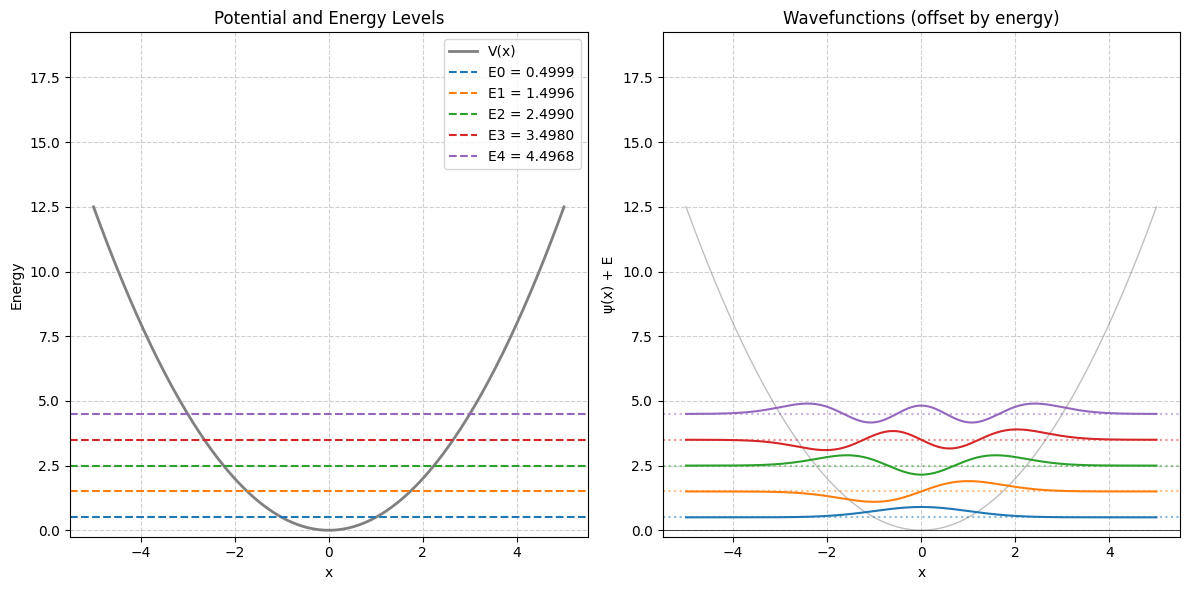


Calculated Energies (Harmonic Oscillator):
  E0: 0.499921 (Analytical: 0.500000, Error: 7.89e-05)
  E1: 1.499605 (Analytical: 1.500000, Error: 3.95e-04)
  E2: 2.498974 (Analytical: 2.500000, Error: 1.03e-03)
  E3: 3.498027 (Analytical: 3.500000, Error: 1.97e-03)
  E4: 4.496771 (Analytical: 4.500000, Error: 3.23e-03)

--- Solving for Finite Square Well ---


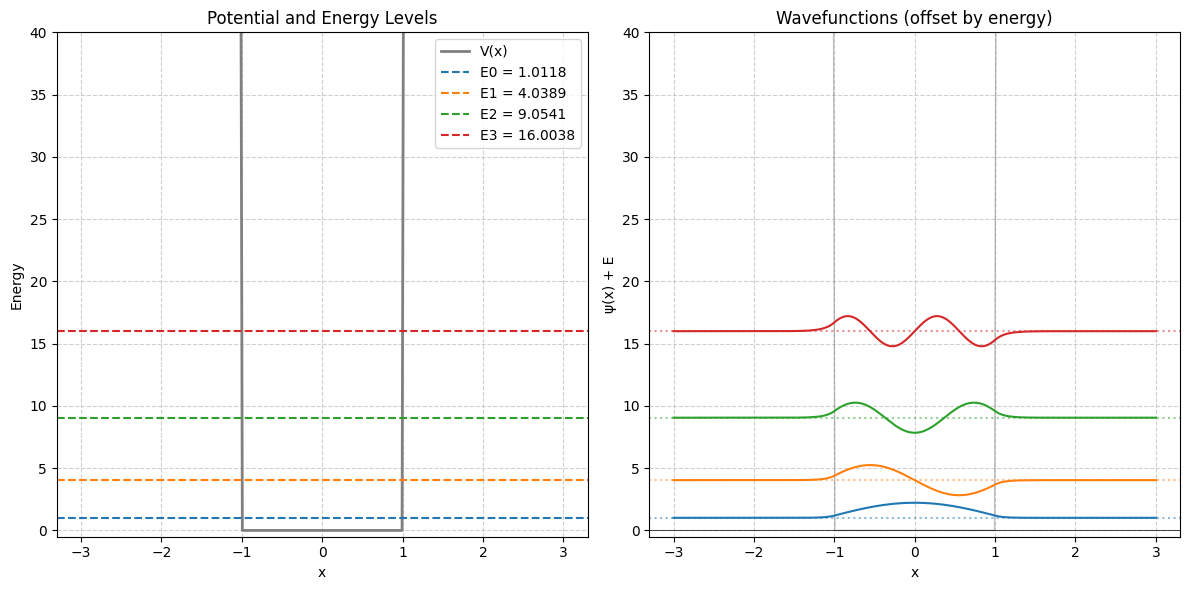


Calculated Energies (Finite Square Well):
  E0: 1.011816
  E1: 4.038893
  E2: 9.054080
  E3: 16.003766

--- Solving for Asymmetric Potential ---


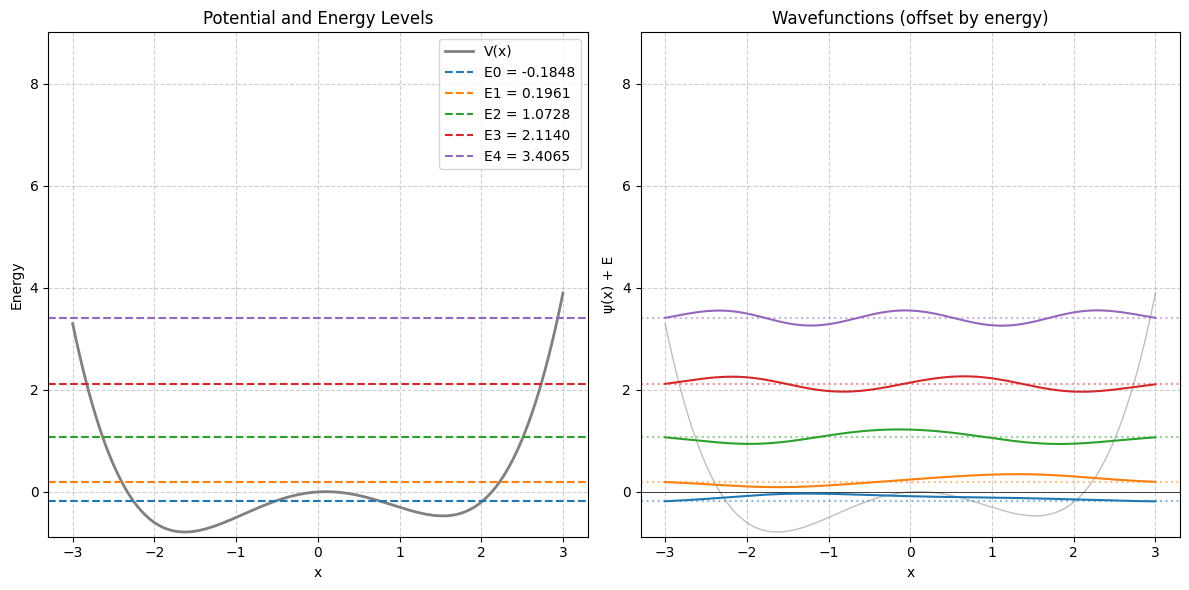


Calculated Energies (Asymmetric Potential):
  E0: -0.184839
  E1: 0.196073
  E2: 1.072809
  E3: 2.113979
  E4: 3.406510


In [201]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

def solve_schrodinger_dvr(potential_func, xmin, xmax, N, m=1.0, hbar=1.0, num_eigenvalues=5):
    """
    Solves the 1D time-independent Schrödinger equation numerically using DVR
    (finite-difference based) and plots the results.

    Args:
        potential_func (callable): A function V(x) that takes a numpy array of x values
                                   and returns the potential energy V.
        xmin (float): Minimum value of the spatial domain.
        xmax (float): Maximum value of the spatial domain.
        N (int): Number of grid points. Must be >= 2.
        m (float, optional): Mass of the particle. Defaults to 1.0.
        hbar (float, optional): Reduced Planck constant. Defaults to 1.0.
        num_eigenvalues (int, optional): Number of lowest eigenvalues/eigenfunctions
                                         to compute and plot. Defaults to 5.

    Returns:
        tuple: A tuple containing:
            - energies (np.ndarray): Array of the lowest 'num_eigenvalues' energy eigenvalues.
            - wavefunctions (np.ndarray): Array where each column corresponds to a
                                          normalized wavefunction evaluated at the grid points.
                                          Shape (N, num_eigenvalues).
            - x_grid (np.ndarray): The spatial grid points.
    """
    if N < 2:
        raise ValueError("Number of grid points N must be at least 2.")
    if xmin >= xmax:
        raise ValueError("xmin must be less than xmax.")
    if num_eigenvalues < 1:
        raise ValueError("num_eigenvalues must be at least 1.")
    if num_eigenvalues > N:
        print(f"Warning: Requesting {num_eigenvalues} eigenvalues, but grid size is only {N}. "
              f"Will return {N} eigenvalues.")
        num_eigenvalues = N

    # 1. Create the spatial grid
    x_grid = np.linspace(xmin, xmax, N)
    dx = x_grid[1] - x_grid[0]

    # 2. Potential Energy Matrix (Diagonal)
    V_diagonal = potential_func(x_grid)
    V_matrix = np.diag(V_diagonal)

    # 3. Kinetic Energy Matrix (Tridiagonal using finite difference)
    # T = - (hbar^2 / 2m) * d^2/dx^2
    # d^2/dx^2 approximated by [psi(i+1) - 2*psi(i) + psi(i-1)] / dx^2
    T_const = -hbar**2 / (2.0 * m * dx**2)
    # Create diagonals
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N - 1)
    # Construct T matrix (ensure it's symmetric/Hermitian)
    T_matrix = T_const * (np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1))

    # 4. Hamiltonian Matrix
    H_matrix = T_matrix + V_matrix

    # 5. Diagonalize the Hamiltonian
    # Use eigh for Hermitian matrices - faster and returns sorted eigenvalues
    eigenvalues, eigenvectors = scipy.linalg.eigh(H_matrix)

    # 6. Select and Normalize Eigenstates
    energies = eigenvalues[:num_eigenvalues]
    # Eigenvectors are columns of the returned matrix
    wavefunctions_raw = eigenvectors[:, :num_eigenvalues]

    # Normalize wavefunctions: integral |psi|^2 dx = 1  => sum |psi_i|^2 * dx = 1
    # Eigenvectors from eigh are normalized such that sum |psi_i|^2 = 1
    # So, divide by sqrt(dx) to get the desired normalization.
    wavefunctions = wavefunctions_raw / np.sqrt(dx)

    # Ensure ground state (lowest energy) wavefunction is positive at its max
    # (This is just a convention for plotting consistency)
    for i in range(num_eigenvalues):
         max_abs_idx = np.argmax(np.abs(wavefunctions[:, i]))
         if wavefunctions[max_abs_idx, i] < 0:
             wavefunctions[:, i] *= -1


    # --- Plotting ---
    plt.figure(figsize=(12, 6))

    # Plot Potential and Energy Levels
    plt.subplot(1, 2, 1)
    plt.plot(x_grid, V_diagonal, label="V(x)", color="grey", linewidth=2)
    plt.title("Potential and Energy Levels")
    plt.xlabel("x")
    plt.ylabel("Energy")
    plt.grid(True, linestyle='--', alpha=0.6)
    # Adjust y-limits for visibility
    plot_emin = min(V_diagonal.min(), energies[0]) - abs(energies[0])*0.5
    plot_emax = max(V_diagonal[V_diagonal < energies[-1] + abs(energies[-1])*2].max() , energies[-1]) + abs(energies[-1])*1.5 # Avoid extreme potential values
    # Ensure plot_emax is substantially larger than plot_emin if they are close
    if plot_emax - plot_emin < abs(energies[0]):
         plot_emax = plot_emin + 2*abs(energies[0]) if energies[0] != 0 else plot_emin + 1.0
    plt.ylim(plot_emin, plot_emax)


    for i in range(num_eigenvalues):
        plt.axhline(energies[i], linestyle="--", color=f"C{i}",
                    label=f"E{i} = {energies[i]:.4f}")
    plt.legend(loc='upper right')

    # Plot Wavefunctions (offset by energy)
    plt.subplot(1, 2, 2)
    plt.plot(x_grid, V_diagonal, label="V(x)", color="grey", linewidth=1, alpha=0.5) # Show potential lightly
    plt.title("Wavefunctions (offset by energy)")
    plt.xlabel("x")
    plt.ylabel("ψ(x) + E")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5) # Zero line

    # Determine appropriate scaling factor for wavefunctions for visibility
    # Let's scale them based on the energy difference between levels
    if num_eigenvalues > 1:
        max_scale = abs(energies[1] - energies[0]) * 0.4
    else:
        max_scale = abs(energies[0]) * 0.4 if energies[0] != 0 else 1.0

    if max_scale == 0: # Handle degenerate cases if they occur
        max_scale = 1.0

    for i in range(num_eigenvalues):
        # Find max absolute value to scale appropriately
        max_psi = np.max(np.abs(wavefunctions[:, i]))
        if max_psi == 0: continue # Avoid division by zero for null vector (shouldn't happen)

        # Scale wavefunction for plotting visibility
        # We want the typical peak height to be around 'max_scale'
        scaled_psi = (wavefunctions[:, i] / max_psi) * max_scale

        plt.plot(x_grid, scaled_psi + energies[i], label=f"ψ{i}(x)", color=f"C{i}")
        # Optional: draw the energy level line faintly on this plot too
        plt.axhline(energies[i], linestyle=":", color=f"C{i}", alpha=0.5)

    # Use the same y-limits as the first plot for consistency
    plt.ylim(plot_emin, plot_emax)
    # Don't need legend here if colors match E levels, or add a minimal one
    # plt.legend()

    plt.tight_layout() # Adjust subplot params for nice layout
    plt.show()

    return energies, wavefunctions, x_grid

# --- Example Usage ---

# 1. Quantum Harmonic Oscillator Potential
def harmonic_potential(x, m=1.0, omega=1.0):
    return 0.5 * m * omega**2 * x**2

print("--- Solving for Harmonic Oscillator ---")
qho_energies, qho_wavefuncs, qho_x = solve_schrodinger_dvr(
    potential_func=harmonic_potential,
    xmin=-5.0,
    xmax=5.0,
    N=200, # Number of grid points
    m=1.0,
    hbar=1.0,
    num_eigenvalues=5
)

print("\nCalculated Energies (Harmonic Oscillator):")
for i, E in enumerate(qho_energies):
    analytical_E = 1.0 * (i + 0.5) # hbar*omega*(n+0.5) with hbar=1, omega=1
    print(f"  E{i}: {E:.6f} (Analytical: {analytical_E:.6f}, Error: {abs(E-analytical_E):.2e})")


# 2. Finite Square Well Potential
def finite_square_well(x, V0=50.0, width=2.0):
    half_width = width / 2.0
    potential = np.zeros_like(x)
    potential[x < -half_width] = V0
    potential[x > half_width] = V0
    return potential

print("\n--- Solving for Finite Square Well ---")
fsw_energies, fsw_wavefuncs, fsw_x = solve_schrodinger_dvr(
    potential_func=lambda x: finite_square_well(x, V0=50.0, width=2.0),
    xmin=-3.0,
    xmax=3.0,
    N=300,
    m=1.0,
    hbar=1.0,
    num_eigenvalues=4
)

print("\nCalculated Energies (Finite Square Well):")
for i, E in enumerate(fsw_energies):
    print(f"  E{i}: {E:.6f}")

# 3. Asymmetric Potential Example (e.g., linear + quadratic)
def asymmetric_potential(x):
    return 0.1 * x**4 - 0.5 * x**2 + 0.1 * x

print("\n--- Solving for Asymmetric Potential ---")
asym_energies, asym_wavefuncs, asym_x = solve_schrodinger_dvr(
    potential_func=asymmetric_potential,
    xmin=-3.0,
    xmax=3.0,
    N=300,
    m=1.0,
    hbar=1.0,
    num_eigenvalues=5
)

print("\nCalculated Energies (Asymmetric Potential):")
for i, E in enumerate(asym_energies):
    print(f"  E{i}: {E:.6f}")

In [246]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

def solve_schrodinger_dvr(potential_func, xmin, xmax, N, m=1.0, hbar=1.0, num_eigenvalues=5):
    """
    Solves the 1D time-independent Schrödinger equation numerically using DVR
    (finite-difference based) and plots the results.

    Args:
        potential_func (callable): A function V(x) that takes a numpy array of x values
                                   and returns the potential energy V.
        xmin (float): Minimum value of the spatial domain.
        xmax (float): Maximum value of the spatial domain.
        N (int): Number of grid points. Must be >= 2.
        m (float, optional): Mass of the particle. Defaults to 1.0.
        hbar (float, optional): Reduced Planck constant. Defaults to 1.0.
        num_eigenvalues (int, optional): Number of lowest eigenvalues/eigenfunctions
                                         to compute and plot. Defaults to 5.

    Returns:
        tuple: A tuple containing:
            - energies (np.ndarray): Array of the lowest 'num_eigenvalues' energy eigenvalues.
            - wavefunctions (np.ndarray): Array where each column corresponds to a
                                          normalized wavefunction evaluated at the grid points.
                                          Shape (N, num_eigenvalues).
            - x_grid (np.ndarray): The spatial grid points.
    """
    if N < 2:
        raise ValueError("Number of grid points N must be at least 2.")
    if xmin >= xmax:
        raise ValueError("xmin must be less than xmax.")
    if num_eigenvalues < 1:
        raise ValueError("num_eigenvalues must be at least 1.")
    if num_eigenvalues > N:
        print(f"Warning: Requesting {num_eigenvalues} eigenvalues, but grid size is only {N}. "
              f"Will return {N} eigenvalues.")
        num_eigenvalues = N

    # 1. Create the spatial grid
    x_grid = np.linspace(xmin, xmax, N)
    dx = x_grid[1] - x_grid[0]

    # 2. Potential Energy Matrix (Diagonal)
    V_diagonal = np.array([potential_func(x) for x in x_grid])
    V_matrix = np.diag(V_diagonal)

    # 3. Kinetic Energy Matrix (Tridiagonal using finite difference)
    # T = - (hbar^2 / 2m) * d^2/dx^2
    # d^2/dx^2 approximated by [psi(i+1) - 2*psi(i) + psi(i-1)] / dx^2
    T_const = -hbar**2 / (2.0 * m * dx**2)
    # Create diagonals
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N - 1)
    # Construct T matrix (ensure it's symmetric/Hermitian)
    T_matrix = T_const * (np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1))

    # 4. Hamiltonian Matrix
    H_matrix = T_matrix + V_matrix

    # 5. Diagonalize the Hamiltonian
    # Use eigh for Hermitian matrices - faster and returns sorted eigenvalues
    eigenvalues, eigenvectors = scipy.linalg.eigh(H_matrix)

    # 6. Select and Normalize Eigenstates
    energies = eigenvalues[:num_eigenvalues]
    # Eigenvectors are columns of the returned matrix
    wavefunctions_raw = eigenvectors[:, :num_eigenvalues]

    # Normalize wavefunctions: integral |psi|^2 dx = 1  => sum |psi_i|^2 * dx = 1
    # Eigenvectors from eigh are normalized such that sum |psi_i|^2 = 1
    # So, divide by sqrt(dx) to get the desired normalization.
    wavefunctions = wavefunctions_raw / np.sqrt(dx)

    # Ensure ground state (lowest energy) wavefunction is positive at its max
    # (This is just a convention for plotting consistency)
    for i in range(num_eigenvalues):
         max_abs_idx = np.argmax(np.abs(wavefunctions[:, i]))
         if wavefunctions[max_abs_idx, i] < 0:
             wavefunctions[:, i] *= -1


    # --- Plotting ---
    plt.figure(figsize=(12, 6))

    # Plot Potential and Energy Levels
    plt.subplot(1, 2, 1)
    plt.plot(x_grid, V_diagonal, label="V(x)", color="grey", linewidth=2)
    plt.title("Potential and Energy Levels")
    plt.xlabel("x")
    plt.ylabel("Energy")
    plt.grid(True, linestyle='--', alpha=0.6)
    # Adjust y-limits for visibility
    plot_emin = min(V_diagonal.min(), energies[0]) - abs(energies[0])*0.5
    plot_emax = max(V_diagonal[V_diagonal < energies[-1] + abs(energies[-1])*2].max() , energies[-1]) + abs(energies[-1])*1.5 # Avoid extreme potential values
    # Ensure plot_emax is substantially larger than plot_emin if they are close
    if plot_emax - plot_emin < abs(energies[0]):
         plot_emax = plot_emin + 2*abs(energies[0]) if energies[0] != 0 else plot_emin + 1.0
    plt.ylim(plot_emin, plot_emax)


    for i in range(num_eigenvalues):
        plt.axhline(energies[i], linestyle="--", color=f"C{i}",
                    label=f"E{i} = {energies[i]:.4f}")
    plt.legend(loc='upper right')

    # Plot Wavefunctions (offset by energy)
    plt.subplot(1, 2, 2)
    plt.plot(x_grid, V_diagonal, label="V(x)", color="grey", linewidth=1, alpha=0.5) # Show potential lightly
    plt.title("Wavefunctions (offset by energy)")
    plt.xlabel("x")
    plt.ylabel("ψ(x) + E")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5) # Zero line

    # Determine appropriate scaling factor for wavefunctions for visibility
    # Let's scale them based on the energy difference between levels
    if num_eigenvalues > 1:
        max_scale = abs(energies[1] - energies[0]) * 0.4
    else:
        max_scale = abs(energies[0]) * 0.4 if energies[0] != 0 else 1.0

    if max_scale == 0: # Handle degenerate cases if they occur
        max_scale = 1.0

    for i in range(num_eigenvalues):
        # Find max absolute value to scale appropriately
        max_psi = np.max(np.abs(wavefunctions[:, i]))
        if max_psi == 0: continue # Avoid division by zero for null vector (shouldn't happen)

        # Scale wavefunction for plotting visibility
        # We want the typical peak height to be around 'max_scale'
        scaled_psi = (wavefunctions[:, i] / max_psi) * max_scale

        plt.plot(x_grid, scaled_psi + energies[i], label=f"ψ{i}(x)", color=f"C{i}")
        # Optional: draw the energy level line faintly on this plot too
        plt.axhline(energies[i], linestyle=":", color=f"C{i}", alpha=0.5)

    # Use the same y-limits as the first plot for consistency
    plt.ylim(plot_emin, plot_emax)
    # Don't need legend here if colors match E levels, or add a minimal one
    # plt.legend()

    plt.tight_layout() # Adjust subplot params for nice layout
    plt.show()

    return energies, wavefunctions, x_grid

In [247]:
## Random init values
V = 0.015936  # Electronic coupling [kcal/mol] -> au
w1 = 0.0110287   # Frecuencies of the harmonic proton potentials [cm^-1] -> au
w2 = 0.0141751   # Frecuencies of the harmonic proton potentials [cm^-1] -> au
l = 0.00755816  # Amplitude of the energy bias [kcal/mol] -> au
x_eq = 0.00891848  # Equilibrium energy bias [kcal/mol] -> au
w_x = 0.000357994   # Frequency of the energy bias oscillations [fs^-1] -> au
th_x = 5.7759  # Initial phase. Zero for the time-independent potentials
R_eq = 1.51438  # Equilibrium distance between the minima of the harmonic potential [0.1nm] -> au 
R_0 = 1.17396  # Initial displacement from equilibrium
w_R = 0.00103848  # Frecuency of the proton-donor-acceptor distance oscillation [cm^-1] -> au
th_R =0.429406  # Random initial phase 
m = 1836  #The proton mass [au] '''

In [248]:
#Generate the potential in jax

def X(t):
    
    """Calculate the energy gap coordinate as a function of time.
    
    Args:
        t (float): Time in atomic units
        
    Returns:
        float: Energy gap coordinate value at time t, oscillating around x_eq
    """
    return l*jnp.cos(w_x*t+th_x) + x_eq

    
def R(t):
    """Calculate the donor-acceptor vibration as a function of time.
    
    Args:
        t (float): Time in atomic units
        
    Returns:
        float: Donor-acceptor distance at time t, oscillating around R_eq
    """
    return (R_0 - R_eq)*jnp.cos(w_R*t+th_R) + R_eq
    
def u1(r, t):
    """Calculate the harmonic potential for branch 1.
    
    Args:
        r (float): Position coordinate
        t (float): Time in atomic units
        
    Returns:
        float: Harmonic potential energy for branch 1 at position r and time t
    """
    return 0.5*m*(w1**2)*(r + (R(t)/2))**2

def u2(r, t):
    """Calculate the harmonic potential for branch 2.
    
    Args:
        r (float): Position coordinate
        t (float): Time in atomic units
        
    Returns:
        float: Harmonic potential energy for branch 2 at position r and time t
    """
    return 0.5*m*(w2**2)*(r - (R(t)/2))**2

def matrix_potential(r, t):
    """Construct the 2x2 potential energy matrix.
    
    Args:
        r (float): Position coordinate
        t (float): Time in atomic units
        
    Returns:
        ndarray: 2x2 potential energy matrix with coupling V between branches
    """
    return jnp.array([[u1(r,t), V],
                      [V, u2(r,t) + X(t)]])

def potential(r,t):
    """Calculate the lowest eigenvalue of the instantaneous potential.
    
    Args:
        r (float): Position coordinate
        t (float): Time in atomic units
        
    Returns:
        float: Lowest eigenvalue of the potential energy matrix at r and t
    """
    e_val = jnp.linalg.eigvals(matrix_potential(r,t))
    return jnp.minimum(e_val[0], e_val[1])

In [253]:
def potential_func(r):
    t = 50
    X = l*np.cos(w_x*t+th_x) + x_eq
    R = (R_0 - R_eq)*np.cos(w_R*t+th_R) + R_eq
    u1 = 0.5*m*(w1**2)*(r + (R/2))**2
    u2 = 0.5*m*(w2**2)*(r - (R/2))**2
    # print(X.shape, R.shape, u1.shape, u2.shape)
    matrix_potential = np.array([[u1, V],
                      [V, u2 + X]])
    e_val = np.linalg.eigvals(matrix_potential)
    return np.minimum(e_val[0], e_val[1])

--- Solving for Harmonic Oscillator ---


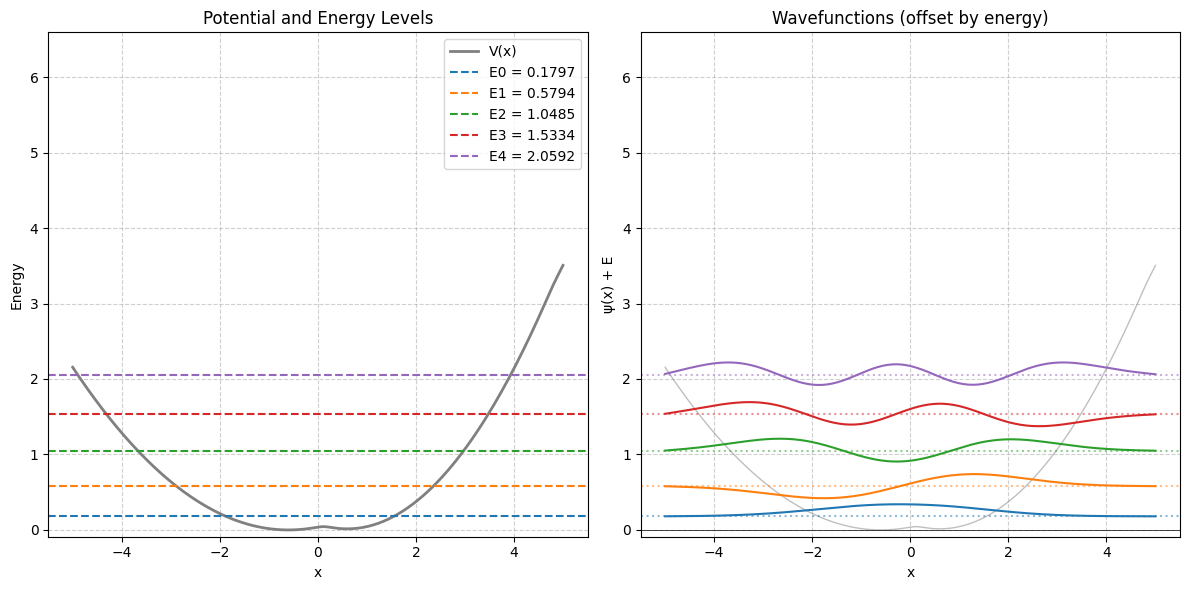


Calculated Energies (Harmonic Oscillator):
  E0: 0.179675 (Analytical: 0.500000, Error: 3.20e-01)
  E1: 0.579442 (Analytical: 1.500000, Error: 9.21e-01)
  E2: 1.048472 (Analytical: 2.500000, Error: 1.45e+00)
  E3: 1.533443 (Analytical: 3.500000, Error: 1.97e+00)
  E4: 2.059180 (Analytical: 4.500000, Error: 2.44e+00)


In [254]:
# def jessica_potential(x):
#     return np.array(float(potential(x, t=50).real))

print("--- Solving for Harmonic Oscillator ---")
qho_energies, qho_wavefuncs, qho_x = solve_schrodinger_dvr(
    potential_func=potential_func,
    xmin=-5.0,
    xmax=5.0,
    N=200, # Number of grid points
    m=1.0,
    hbar=1.0,
    num_eigenvalues=5
)

print("\nCalculated Energies (Harmonic Oscillator):")
for i, E in enumerate(qho_energies):
    analytical_E = 1.0 * (i + 0.5) # hbar*omega*(n+0.5) with hbar=1, omega=1
    print(f"  E{i}: {E:.6f} (Analytical: {analytical_E:.6f}, Error: {abs(E-analytical_E):.2e})")

In [237]:
print((jessica_potential(10)))

print(type(jessica_potential(10)))
# x_grid = np.linspace(-5., 5., 10)
# jessica_potential(x_grid)

12.560831069946289
<class 'numpy.ndarray'>


In [153]:
# 1. policy net

class PolicyNet(nn.Module):
    """a simple ffnn policy network (eq 30, appendix B.4)
    
    Args:
        features: sequence of int, the number of units in each layer. The last must be same dim as input (psi: d -> d)
    
    Returns:
        phi_theta: jnp.ndarray shape (batch_size, space_dim)

    """
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        # ffnn for psi_θ (psi: d -> d)
        psi = x
        for feat in self.features[:-1]:
            psi = nn.Dense(feat)(psi)
            psi = nn.relu(psi)
        psi = nn.Dense(self.features[-1])(psi)


        # psi_theta(x) is the output of the last layer, so we want to return
        # phi_theta(x) = phi_theta(x) + gamma_C(x)[x - psi_theta(x)]
        # where gamma_C(x) is a smooth transition function that goes from 0 to 1
        # as ||x|| increases, and C is a compact set

        # here, we use a simple norm to define the compact set
        # and a sigmoid function to define the smooth transition
        norm_x = jnp.linalg.norm(x)
        threshold = 10.0  # radius of compact set C
        gamma = jax.nn.sigmoid((norm_x - threshold) * 0.5)  # smooth transition function (1 when x is outside C, 0 when inside C)
        
        # Combine to get phi_theta(x)
        phi = psi + gamma * (x - psi)
        return phi

In [ ]:
# 7.5. Adaptive Metropolis-Hastings (AMH) (algo 1 in appendix B.3) for warmup

import jax
import jax.numpy as jnp
import numpy as np
from jax import random
from functools import partial

def adaptive_metropolis(
    key,
    logpdf,
    d,
    n=1000,
    rate=0.5,
    stop_learning_iters=None,
):
    if stop_learning_iters is None:
        stop_learning_iters = n + 1

    # Initialization
    x = jnp.zeros((n, d))
    mu = jnp.zeros((n, d))
    Sigma = jnp.zeros((n, d, d)).at[0].set(jnp.eye(d))
    log_lambda = jnp.zeros(n)
    reward = jnp.zeros(n)
    accept_status = jnp.zeros(n, dtype=bool)

    def gamma(i): return 0.5 * i ** (-rate)
    alpha_goal = 0.234

    def step(carry, i):
        key, x_prev, mu_prev, Sigma_prev, log_lambda_prev = carry

        # Ensure positive definite
        scaled_cov = jnp.exp(log_lambda_prev) * Sigma_prev
        scaled_cov = 0.5 * (scaled_cov + scaled_cov.T)  # symmetrize

        key, subkey = random.split(key)
        eps = random.multivariate_normal(subkey, jnp.zeros(d), scaled_cov)
        x_star = x_prev + eps

        log_alpha = jnp.minimum(0.0, logpdf(x_star) - logpdf(x_prev))
        accept = jnp.log(random.uniform(key)) < log_alpha
        x_new = jnp.where(accept, x_star, x_prev)

        rew = 2 * jnp.log(jnp.linalg.norm(x_prev - x_star) + 1e-6) + log_alpha

        do_adapt = i < stop_learning_iters
        g = gamma(i)

        exp_alpha = jnp.exp(log_alpha)
        log_lambda_new = log_lambda_prev + g * (exp_alpha - alpha_goal)
        mu_new = mu_prev + g * (x_new - mu_prev)
        dx = (x_new - mu_prev).reshape(-1, 1)
        Sigma_new = Sigma_prev + g * (dx @ dx.T - Sigma_prev)

        log_lambda_new = jnp.where(do_adapt, log_lambda_new, log_lambda_prev)
        mu_new = jnp.where(do_adapt, mu_new, mu_prev)
        Sigma_new = jnp.where(do_adapt, Sigma_new, Sigma_prev)

        outputs = (x_new, mu_new, Sigma_new, log_lambda_new, rew, accept)
        carry = (key, x_new, mu_new, Sigma_new, log_lambda_new)
        return carry, outputs

    carry = (key, jnp.zeros(d), jnp.zeros(d), jnp.eye(d), 0.0)
    _, (xs, mus, Sigmas, log_lambdas, rewards, acc) = jax.lax.scan(
        step, carry, jnp.arange(1, n)
    )

    # Add initial values
    x = x.at[1:].set(xs)
    mu = mu.at[1:].set(mus)
    Sigma = Sigma.at[1:].set(Sigmas)
    log_lambda = log_lambda.at[1:].set(log_lambdas)
    reward = reward.at[1:].set(rewards)
    accept_status = accept_status.at[1:].set(acc)

    return x, mu, Sigma, log_lambda, reward, accept_status

In [23]:
test = jnp.ones((5,))
test_exp = test[:, None]
test_exp_2 = test[None, :]
print(test_exp)
print(test_exp_2)
print(0.3 * test_exp @ test_exp_2)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1. 1. 1. 1. 1.]]
[[0.3 0.3 0.3 0.3 0.3]
 [0.3 0.3 0.3 0.3 0.3]
 [0.3 0.3 0.3 0.3 0.3]
 [0.3 0.3 0.3 0.3 0.3]
 [0.3 0.3 0.3 0.3 0.3]]


In [123]:
# 1. policy net

class PolicyNet(nn.Module):
    """a simple ffnn policy network (eq 30, appendix B.4)
    
    Args:
        features: sequence of int, the number of units in each layer. The last must be same dim as input (psi: d -> d)
    
    Returns:
        phi_theta: jnp.ndarray shape (batch_size, space_dim)

    """
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        # ffnn for psi_θ (psi: d -> d)
        psi = x
        for feat in self.features[:-1]:
            psi = nn.Dense(feat)(psi)
            psi = nn.relu(psi)
        psi = nn.Dense(self.features[-1])(psi)


        # psi_theta(x) is the output of the last layer, so we want to return
        # phi_theta(x) = phi_theta(x) + gamma_C(x)[x - psi_theta(x)]
        # where gamma_C(x) is a smooth transition function that goes from 0 to 1
        # as ||x|| increases, and C is a compact set

        # here, we use a simple norm to define the compact set
        # and a sigmoid function to define the smooth transition
        norm_x = jnp.linalg.norm(x)
        threshold = 10.0  # radius of compact set C
        gamma = jax.nn.sigmoid((norm_x - threshold) * 0.5)  # smooth transition function (1 when x is outside C, 0 when inside C)
        
        # Combine to get phi_theta(x)
        phi = psi + gamma * (x - psi)
        return phi

In [ ]:
# 2. critic net for DDPG
class CriticNet(nn.Module):
    """a simple ffnn critic network (see appendix B.4)"
    
    Args:
        features: sequence of int, the number of units in each layer. The first must be 2*d x 2*d (Q: 2d x 2d -> 1)

    Returns:
        q_value: jnp.ndarray shape (batch_size, 1)

    """
    features: Sequence[int]

    @nn.compact
    def __call__(self, state, action):
        
        # state = s_n = (x_n, x^*_n+1) (shape = 2*d)
        # action = a_n = pi(s_n) = (phi_theta(x_n), phi_theta(x^*_n+1)) (shape = 2*d)
        
        # concatenate state and action
        x = jnp.concatenate([state, action], axis=-1)
        for feat in self.features[:-1]:
            x = nn.Dense(feat)(x)
            x = nn.relu(x)
        q_value = nn.Dense(1)(x)
        return q_value.squeeze()

In [125]:
# 3. target distribution (density up to normalizing constant)
def target_density(x):
    """example: gaussian mixture"""
    # two component gaussian mixture, each component at (-5, 0) and (5, 0)

    mu1 = jnp.array([-5.0])
    mu2 = jnp.array([5.0])
    sigma = 1.0
    
    log_p1 = -0.5 * jnp.sum(((x - mu1) / sigma) ** 2)
    log_p2 = -0.5 * jnp.sum(((x - mu2) / sigma) ** 2)
    return jnp.logaddexp(log_p1, log_p2)  # log(exp(log_p1) + exp(log_p2))

In [126]:
# 4. laplace proposal distribution
def laplace_proposal_logprob(y, x, phi_x, Sigma):
    """computes log probability of laplace proposal q(y|x) with mean phi_x (eq 6)
    
    Args:
        y: proposed vector - jnp.ndarray shape (batch_size, d)
        x: current vector - jnp.ndarray shape (batch_size, d)
        phi_x: mean of proposal - jnp.ndarray shape (batch_size, d)
        Sigma: covariance matrix - jnp.ndarray shape (d, d)
    Returns:
        log_prob: jnp.ndarray shape (batch_size,)
    """

    # Laplace distribution with mean phi_x and scale parameter Sigma
    # q(y|x) ∝ exp(-||y - phi_x||_1,Sigma)
    # where ||y - phi_x||_1,Sigma is the associated norm
    # with respect to the covariance matrix Sigma
    # given by ||x||_1,Sigma = ||Sigma^{-1/2} x||_1 where Sigma^{-1/2} is the square root of the inverse of Sigma
    # This is equivalent to computing the L1 norm of the transformed vector
    
    # compute Sigma^{-1}
    precision = jnp.linalg.inv(Sigma)

    # compute the square root of the precision matrix
    precision_sqrt = jax.scipy.linalg.sqrtm(precision)

    # compute the L1 norm with respect to the covariance matrix
    norm = jnp.sum(jnp.abs(precision_sqrt @ (y - phi_x)))

    # constant term depends on det(Sigma) which cancels in MH ratio, so we omit it
    return -norm

In [127]:
# MH acceptance probability (eq 2)

def compute_acceptance_prob(x, y, phi_x, phi_y, Sigma):
    """compute acceptance probability for phi-MH (secc 2.1)
    
    Args:
        x: current vector - jnp.ndarray shape (batch_size, d)
        y: proposed vector - jnp.ndarray shape (batch_size, d)
        phi_x: mean of proposal - jnp.ndarray shape (batch_size, d)
        phi_y: mean of proposal - jnp.ndarray shape (batch_size, d)
        Sigma: covariance matrix - jnp.ndarray shape (d, d)
    Returns:
        log_alpha: jnp.ndarray shape (batch_size,), log acceptance probability
        alpha: jnp.ndarray shape (batch_size,), acceptance probability

    """
    
    # acceptance prob for proposal y: alpha_theta(x, y) = min(1, p(y)/p(x) * q(x|y)/q(y|x))
    # where p(y) is the target density and q(x|y) is the proposal density

    # log p(y) - log p(x)
    log_target_ratio = target_density(y) - target_density(x)
    
    # log q(x|y) - log q(y|x)
    log_proposal_ratio = laplace_proposal_logprob(x, y, phi_y, Sigma) - \
                          laplace_proposal_logprob(y, x, phi_x, Sigma)
    
    # min(1, p(y)/p(x) * q(x|y)/q(y|x))
    log_alpha = log_target_ratio + log_proposal_ratio
    return jnp.minimum(0.0, log_alpha), jnp.exp(jnp.minimum(0.0, log_alpha))

In [128]:
# 6. reward function (expected squared jump distance) (secc 2.2)
def compute_reward(x, y_star, log_alpha):
    """compute reward based on ESJD
    
    Args:
        x: current vector - jnp.ndarray shape (batch_size, d)
        y_star: proposed vector - jnp.ndarray shape (batch_size, d)
        log_alpha: log acceptance probability - jnp.ndarray shape (batch_size,)
    Returns:
        reward: jnp.ndarray shape (batch_size,), reward value
    
    """
    # r = 2 log ||x - y*|| + log α
    distance = jnp.linalg.norm(x - y_star)

    # add a small constant to avoid log(0)
    reward = 2.0 * jnp.log(distance + 1e-10) + log_alpha
    return reward

In [129]:
# 7. create replay buffer for DDPG ( algo 2 in appendix B.2)

# it is written only on numpy. TODO: convert to jax.numpy for jit acceleration
class ReplayBuffer:
    def __init__(self, state_dim, max_size=100000):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        
        self.states = np.zeros((max_size, 2 * state_dim))
        self.actions = np.zeros((max_size, 2 * state_dim))
        self.rewards = np.zeros((max_size, 1))
        self.next_states = np.zeros((max_size, 2 * state_dim))
        
    def add(self, state, action, reward, next_state):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            self.states[ind],
            self.actions[ind],
            self.rewards[ind],
            self.next_states[ind]
        )

In [20]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import cholesky
from jax.random import exponential
from typing import Union

def laplace(rng_key, *args: Union[jnp.ndarray]):
    """
    Implements the multivariate Laplace distribution.

    Usage:
    - laplace(rng_key, mu, Sigma) → returns a sample
    - laplace(None, x, mu, Sigma) → returns log-pdf (up to constant)

    Parameters:
    - rng_key: jax.random.PRNGKey, required only for sampling
    - x: point to evaluate (optional)
    - mu: mean vector
    - Sigma: scale matrix

    Returns:
    - sample OR log-pdf up to a constant
    """
    if len(args) == 2:
        mu, Sigma = args
        d = Sigma.shape[0]

        # Cholesky decomposition: Sigma = R.T @ R
        R = cholesky(Sigma, lower=False)

        # Sample standard Laplace: z = Exp(1) - Exp(1)
        z1 = exponential(rng_key, shape=(d,))
        z2 = exponential(jax.random.split(rng_key)[1], shape=(d,))
        z = z1 - z2

        # Return correlated Laplace sample
        return mu + R.T @ z

    elif len(args) == 3:
        x, mu, Sigma = args
        x = x.flatten()

        # Cholesky decomposition
        R = cholesky(Sigma, lower=False)

        # Compute log-pdf up to constant
        diff = x - mu
        transformed = jax.scipy.linalg.solve_triangular(R.T, diff, lower=True)
        return -jnp.sum(jnp.abs(transformed))

    else:
        raise ValueError("Invalid number of arguments.")



In [ ]:
# 8. define the RLMH algorithm
def rlmh(key, 
         init_state,
         policy_network,
         critic_network,
         n_iterations,
         learning_rate=1e-4,
         tau=0.005,
         gamma=0.99,
         batch_size=64,
         grad_clip_threshold=1.0):
    """
    reinforcement learning Metropolis-Hastings (RLMH) algorithm
    
    Args:
        key: jax random key
        init_state: initial state of the Markov chain
        policy_network: nn for the proposal mean function
        critic_network: nn for value function
        n_iterations: number of MCMC iterations
        learning_rate: learning rate for policy update
        tau: soft update parameter for target networks
        gamma: discount factor for rl algo
        batch_size: batch size for rl training
        grad_clip_threshold: threshold for gradient clipping (avoid exploding gradients)
    
    Returns:
        samples: generated MCMC samples
        rewards: sequence of rewards
        policy params: trained policy network parameters
    """

    state_dim = init_state.shape[0]
    action_dim = state_dim
    
    # init nets
    policy_key, critic_key, next_key = jax.random.split(key, 3)
    
    policy_params = policy_network.init(policy_key, jnp.zeros(state_dim))
    critic_params = critic_network.init(critic_key, jnp.zeros(2*state_dim), jnp.zeros(2*action_dim))
    
    
    # create target networks (for DDPG)
    target_policy_params = policy_params
    target_critic_params = critic_params
    
    # create optimizers
    policy_optimizer = optax.adam(learning_rate)
    critic_optimizer = optax.adam(learning_rate)
    
    policy_opt_state = policy_optimizer.init(policy_params)
    critic_opt_state = critic_optimizer.init(critic_params)
    
    # init the covariance matrix for the proposal (identity matrix)
    #Sigma = jnp.eye(state_dim)
    Sigma = sigmis[-1]  # use the last learned covariance matrix from AMH
    
    # init the replay buffer
    buffer = ReplayBuffer(state_dim, action_dim)
    
    # define the policy inference function
    def apply_policy(params, x):
        return policy_network.apply(params, x)
    
    # define the critic inference function
    def apply_critic(params, state, action):
        return critic_network.apply(params, state, action)
    
    # define policy update function
    @jax.jit
    def update_policy(policy_params, critic_params, states):
        def policy_loss(params):
            # compute actions using the policy
            # batch_x = (x_n) (shape = 2*d)
            batch_x = states[:, :state_dim]

            # compute actions for current states
            # actions = phi_theta(x_n)
            actions = jax.vmap(apply_policy, in_axes=(None, 0))(params, batch_x)

            # compute actions for next states
            # next_actions = phi_theta(x^*_n+1)
            next_actions = jax.vmap(apply_policy, in_axes=(None, 0))(params, states[:, state_dim:])

            # concatenate actions and next actions
            full_actions = jnp.concatenate([actions, next_actions], axis=1)
            
            # calculate critic values
            # q_values = Q(x_n, x^*_n+1, phi_theta(x_n), phi_theta(x^*_n+1))
            q_values = jax.vmap(apply_critic, in_axes=(None, 0, 0))(critic_params, states, full_actions)
            
            # policy loss is negative of the mean Q-value
            return -jnp.mean(q_values)
        
        # compute gradients
        
        # gradients of J_theta (mean of rewards) (eq 28 in paper)
        # the gradioent of the J_theta is also E_{s~D_{pi}}[nabla_theta Q_pi (s, pi(s)]

        # def det_policy_grad(policy_params, critic_params, states):
        #     # compute actions using the policy
        #     batch_x = states[:, :state_dim]
        #     actions = jax.vmap(apply_policy, in_axes=(None, 0))(policy_params, batch_x)
        #     next_actions = jax.vmap(apply_policy, in_axes=(None, 0))(policy_params, states[:, state_dim:])
        #     full_actions = jnp.concatenate([actions, next_actions], axis=1)

        #     # calculate critic values
            
        #     grad_q = jax.grad(apply_critic, argnums=2)(critic_params, states, full_actions)

        #     grad_pi = jax.grad(apply_policy, argnums=0)(policy_params, batch_x)

        #     return jnp.mean(grad_q * grad_pi)
        
        grad_fn = jax.value_and_grad(policy_loss)
        loss, grads = grad_fn(policy_params)

        # loss = policy_loss(policy_params)
        # grads = det_policy_grad(policy_params, critic_params, states)

        # clip gradients by norm if they exceed the threshold (avoid exploding gradients)
        grad_norm = optax.global_norm(grads)
        clipped_grads = jax.tree_map(
            lambda g: g * jnp.minimum(1.0, grad_clip_threshold / (grad_norm + 1e-8)), 
            grads
        )
        
        # Apply updates
        updates, new_policy_opt_state = policy_optimizer.update(clipped_grads, policy_opt_state)
        new_policy_params = optax.apply_updates(policy_params, updates)
        
        return new_policy_params, new_policy_opt_state, loss
    
    # define critic update function
    @jax.jit
    def update_critic(critic_params, target_policy_params, target_critic_params,
                      states, actions, rewards, next_states):
        # compute target actions using target policy network
        batch_next_x = next_states[:, :state_dim]
        next_actions = jax.vmap(apply_policy, in_axes=(None, 0))(target_policy_params, batch_next_x)
        next_next_actions = jax.vmap(apply_policy, in_axes=(None, 0))(target_policy_params, next_states[:, state_dim:])
        next_full_actions = jnp.concatenate([next_actions, next_next_actions], axis=1)
        
        # compute target q values
        next_q = jax.vmap(apply_critic, in_axes=(None, 0, 0))(
            target_critic_params, next_states, next_full_actions
        )
        target_q = rewards + gamma * next_q
        
        # Compute critic loss
        def critic_loss(params):
            predicted_q = jax.vmap(apply_critic, in_axes=(None, 0, 0))(params, states, actions)
            return jnp.mean((predicted_q - target_q) ** 2)
        
        # Compute gradients and update critic
        grad_fn = jax.value_and_grad(critic_loss)
        loss, grads = grad_fn(critic_params)
        
        updates, new_critic_opt_state = critic_optimizer.update(grads, critic_opt_state)
        new_critic_params = optax.apply_updates(critic_params, updates)
        
        return new_critic_params, new_critic_opt_state, loss
    
    # Define soft update for target networks
    @jax.jit
    def soft_update(params, target_params):
        return jax.tree_map(
            lambda p, tp: (1 - tau) * tp + tau * p,
            params, target_params
        )
    
    # Define metropolis step with RL-based proposal
    def metropolis_step(key, state, policy_params, Sigma):
        x = state[:state_dim]
        
        # Propose new state
        key, proposal_key = jax.random.split(key)
        phi_x = apply_policy(policy_params, x)
        
        # Sample from Laplace distribution
        # For simplicity, we approximate with a Gaussian for this implementation
        y_star = phi_x + laplace(proposal_key, phi_x, Sigma)
        
        # Compute phi for the proposed state
        phi_y_star = apply_policy(policy_params, y_star)
        
        # Compute acceptance probability
        log_alpha, alpha = compute_acceptance_prob(x, y_star, phi_x, phi_y_star, Sigma)
        
        # Accept or reject
        key, accept_key = jax.random.split(key)
        u = jax.random.uniform(accept_key)
        accept = u < alpha
        
        # Update state
        next_x = jnp.where(accept, y_star, x)
        
        # Prepare next candidate (for RL state)
        key, next_proposal_key = jax.random.split(key)
        phi_next_x = apply_policy(policy_params, next_x)
        next_y_star = phi_next_x + jax.random.multivariate_normal(
            next_proposal_key, jnp.zeros_like(next_x), Sigma
        )
        
        # Current and next states for RL
        current_rl_state = jnp.concatenate([x, y_star])
        next_rl_state = jnp.concatenate([next_x, next_y_star])
        
        # Actions (phi values)
        action = jnp.concatenate([phi_x, phi_y_star])
        
        # Compute reward
        reward = compute_reward(x, y_star, log_alpha)
        
        return key, next_x, current_rl_state, action, reward, next_rl_state, accept
    
    # Main RLMH loop
    samples = np.zeros((n_iterations+1, state_dim))
    samples[0] = init_state
    rewards = np.zeros(n_iterations)
    acceptance_rate = np.zeros(n_iterations)
    
    current_state = init_state
    
    # Initial step to get first proposed state
    key, proposal_key = jax.random.split(next_key)
    phi_x = apply_policy(policy_params, current_state)
    y_star = phi_x + jax.random.multivariate_normal(
        proposal_key, jnp.zeros_like(current_state), Sigma
    )
    
    # Define RL state
    rl_state = jnp.concatenate([current_state, y_star])
    
    # Training loop
    for t in range(n_iterations):
        # Anneal learning rate (diminishing adaptation)
        current_lr = learning_rate / (1 + 0.0000001 * t)
        
        # Take MH step
        key, current_state, rl_state, action, reward, next_rl_state, accept = metropolis_step(
            key, rl_state, policy_params, Sigma
        )
        
        # Store the sample and reward
        samples[t+1] = current_state
        rewards[t] = reward
        acceptance_rate[t] = float(accept)
        
        # Add to replay buffer
        buffer.add(rl_state, action, reward, next_rl_state)
        
        # After collecting enough samples, start training
        if buffer.size > batch_size:
            # Sample from replay buffer
            batch_states, batch_actions, batch_rewards, batch_next_states = buffer.sample(batch_size)
            
            # Convert to JAX arrays
            batch_states = jnp.array(batch_states)
            batch_actions = jnp.array(batch_actions)
            batch_rewards = jnp.array(batch_rewards)
            batch_next_states = jnp.array(batch_next_states)
            
            # Update critic
            critic_params, critic_opt_state, critic_loss = update_critic(
                critic_params, target_policy_params, target_critic_params,
                batch_states, batch_actions, batch_rewards, batch_next_states
            )
            
            # Update policy
            policy_params, policy_opt_state, policy_loss = update_policy(
                policy_params, critic_params, batch_states
            )
            
            # Update target networks
            target_policy_params = soft_update(policy_params, target_policy_params)
            target_critic_params = soft_update(critic_params, target_critic_params)
            
        # Print progress
        if (t+1) % 1000 == 0:
            print(f"Iteration {t+1}/{n_iterations}, " 
                  f"Avg Reward: {np.mean(rewards[max(0, t-999):t+1]):.4f}, "
                  f"Acceptance Rate: {np.mean(acceptance_rate[max(0, t-999):t+1]):.4f}")
    
    return samples, rewards, policy_params

Iteration 1000/10000, Avg Reward: -4.4467, Acceptance Rate: 0.8730
Iteration 2000/10000, Avg Reward: -4.7787, Acceptance Rate: 0.8600
Iteration 3000/10000, Avg Reward: -4.9842, Acceptance Rate: 0.8600
Iteration 4000/10000, Avg Reward: -4.3809, Acceptance Rate: 0.8610
Iteration 5000/10000, Avg Reward: -6.3445, Acceptance Rate: 0.8700
Iteration 6000/10000, Avg Reward: -5.9297, Acceptance Rate: 0.8690
Iteration 7000/10000, Avg Reward: -9.2211, Acceptance Rate: 0.8330
Iteration 8000/10000, Avg Reward: -6.4571, Acceptance Rate: 0.8650
Iteration 9000/10000, Avg Reward: -5.0998, Acceptance Rate: 0.8540
Iteration 10000/10000, Avg Reward: -6.5143, Acceptance Rate: 0.8530


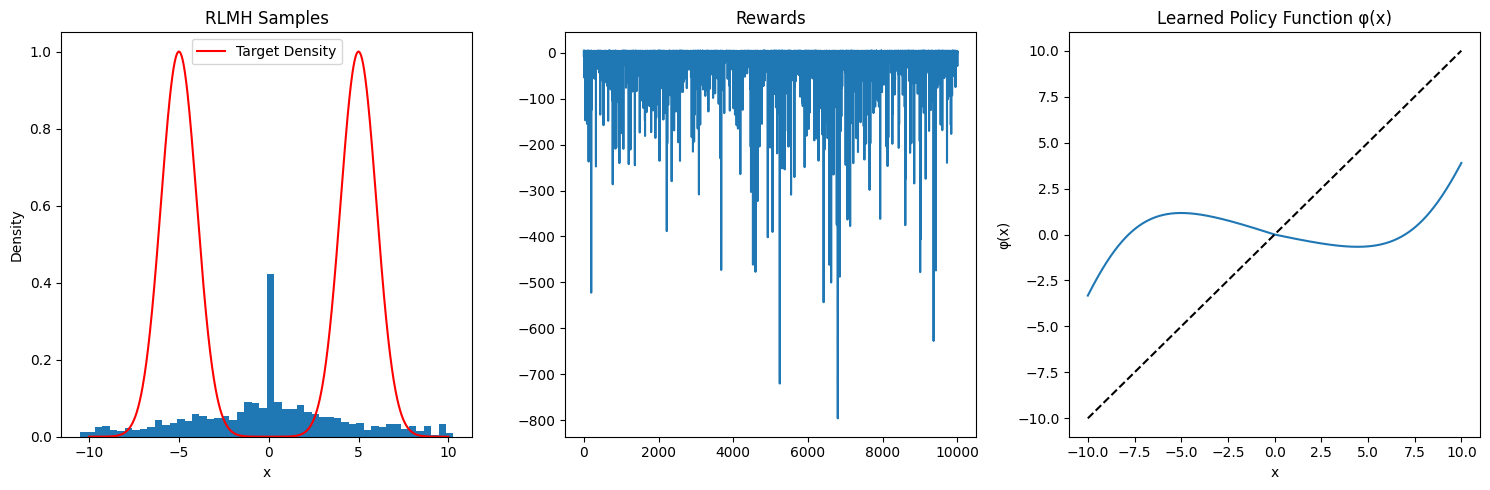

In [141]:
# 9. Run the algorithm
def run_experiment():
    state_dim = 1  # 1D example
    init_state = jnp.array([0.0])  # Start at origin
    
    # Set random seed
    key = jax.random.PRNGKey(0)

    # Define the network architectures
    policy_network = PolicyNet(features=[32, 32, state_dim])
    critic_network = CriticNet(features=[64, 64, 1])
    
    # Run RLMH
    key, subkey = jax.random.split(key)
    samples, rewards, final_policy_params = rlmh(
        subkey,
        init_state,
        policy_network,
        critic_network,
        n_iterations=10_000,
        learning_rate=1e-4,
        batch_size=64
    )
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot samples
    plt.subplot(1, 3, 1)
    plt.hist(samples[-1_000:], bins=50, density=True)
    plt.title('RLMH Samples')
    x_n = np.linspace(-10, 10, 1000)
    plt.plot(x_n, jnp.array([np.exp(target_density(x)) for x in x_n]), label='Target Density', color='red')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    
    # Plot rewards
    plt.subplot(1, 3, 2)
    plt.plot(rewards)
    plt.title('Rewards')
    
    # Plot learned policy function
    x_grid = np.linspace(-10, 10, 1000).reshape(-1, 1)
    phi_x = jax.vmap(lambda x: policy_network.apply(final_policy_params, x))(jnp.array(x_grid))
    
    plt.subplot(1, 3, 3)
    plt.plot(x_grid, phi_x)
    plt.plot(x_grid, x_grid, 'k--')  # Identity line for reference
    plt.title('Learned Policy Function φ(x)')
    plt.xlabel('x')
    plt.ylabel('φ(x)')
    
    plt.tight_layout()
    plt.show()

# Run the experiment
if __name__ == "__main__":
    run_experiment()

/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_14222/2748300516.py:212: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  clipped_grads = jax.tree_map(
/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_14222/2748300516.py:256: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(
/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_14222/2748300516.py:256: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(


Iteration 1000/100000, Avg Reward: -1.2834, Acceptance Rate: 0.9990
Iteration 2000/100000, Avg Reward: -1.3726, Acceptance Rate: 1.0000
Iteration 3000/100000, Avg Reward: -1.1316, Acceptance Rate: 1.0000
Iteration 4000/100000, Avg Reward: -1.3553, Acceptance Rate: 1.0000
Iteration 5000/100000, Avg Reward: -1.3396, Acceptance Rate: 1.0000
Iteration 6000/100000, Avg Reward: -1.2726, Acceptance Rate: 1.0000
Iteration 7000/100000, Avg Reward: -1.2196, Acceptance Rate: 1.0000
Iteration 8000/100000, Avg Reward: -1.2083, Acceptance Rate: 0.9980
Iteration 9000/100000, Avg Reward: -1.1950, Acceptance Rate: 1.0000
Iteration 10000/100000, Avg Reward: -1.2551, Acceptance Rate: 0.9770
Iteration 11000/100000, Avg Reward: -1.4425, Acceptance Rate: 0.9760
Iteration 12000/100000, Avg Reward: -1.3139, Acceptance Rate: 0.9800
Iteration 13000/100000, Avg Reward: -1.3468, Acceptance Rate: 0.9900
Iteration 14000/100000, Avg Reward: -1.3307, Acceptance Rate: 0.9800
Iteration 15000/100000, Avg Reward: -1.2342

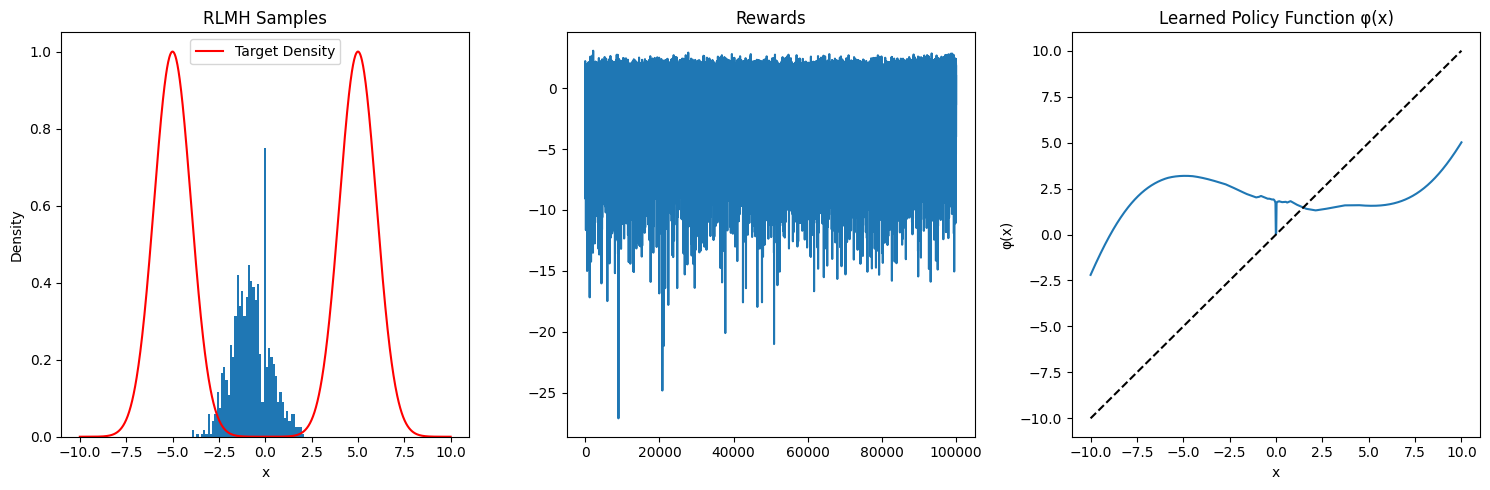

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Callable, Tuple
import optax
from flax.training import train_state
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
key = jax.random.PRNGKey(0)

# 1. Define the neural network for the policy (ϕ_θ)
class PolicyNetwork(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        # Neural network for ψ_θ
        ψ = x
        for feat in self.features[:-1]:
            ψ = nn.Dense(feat)(ψ)
            ψ = nn.relu(ψ)
        ψ = nn.Dense(self.features[-1])(ψ)
        
        # Implementation of ϕ_θ(x) = ψ_θ(x) + γ_C(x)[x - ψ_θ(x)]
        # For simplicity, we'll use a smooth transition function based on norm
        # γ_C(x) goes from 0 to 1 as ||x|| increases
        norm_x = jnp.linalg.norm(x)
        threshold = 10.0  # Radius of compact set C
        γ = jax.nn.sigmoid((norm_x - threshold) * 0.5)  # Smooth transition function
        
        # Combine to get ϕ_θ(x)
        ϕ = ψ + γ * (x - ψ)
        return ϕ

# 2. Define the critic network for DDPG
class CriticNetwork(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, state, action):
        # Concatenate state and action
        x = jnp.concatenate([state, action], axis=-1)
        for feat in self.features[:-1]:
            x = nn.Dense(feat)(x)
            x = nn.relu(x)
        q_value = nn.Dense(1)(x)
        return q_value.squeeze()

# 3. Define the target distribution (density up to normalizing constant)
def target_density(x):
    """Example: Gaussian mixture model"""
    # Two-component Gaussian mixture, each component at (-5, 0) and (5, 0)
    mu1 = jnp.array([-5.0])
    mu2 = jnp.array([5.0])
    sigma = 1.0
    
    log_p1 = -0.5 * jnp.sum(((x - mu1) / sigma) ** 2)
    log_p2 = -0.5 * jnp.sum(((x - mu2) / sigma) ** 2)
    return jnp.logaddexp(log_p1, log_p2)  # log(exp(log_p1) + exp(log_p2))

# 4. Define the Laplace proposal distribution
def laplace_proposal_logprob(y, x, phi_x, Sigma):
    """Log probability of Laplace proposal q(y|x) with mean phi_x"""
    # Laplace distribution with mean phi_x and scale parameter Sigma
    # q(y|x) ∝ exp(-||y - phi_x||_1,Sigma)
    precision = jnp.linalg.inv(Sigma)
    precision_sqrt = jax.scipy.linalg.sqrtm(precision)
    norm = jnp.sum(jnp.abs(precision_sqrt @ (y - phi_x)))
    # Constant term depends on det(Sigma) which cancels in MH ratio, so we omit it
    return -norm

# 5. Define the Metropolis-Hastings acceptance probability
def compute_acceptance_prob(x, y, phi_x, phi_y, Sigma):
    """Compute acceptance probability for ϕ-MH"""
    # log p(y) - log p(x)
    log_target_ratio = target_density(y) - target_density(x)
    
    # log q(x|y) - log q(y|x)
    log_proposal_ratio = laplace_proposal_logprob(x, y, phi_y, Sigma) - \
                          laplace_proposal_logprob(y, x, phi_x, Sigma)
    
    # min(1, p(y)/p(x) * q(x|y)/q(y|x))
    log_alpha = log_target_ratio + log_proposal_ratio
    return jnp.minimum(0.0, log_alpha), jnp.exp(jnp.minimum(0.0, log_alpha))

# 6. Define the reward function (expected squared jump distance)
def compute_reward(x, y_star, log_alpha):
    """Compute reward based on ESJD"""
    # r = 2 log ||x - y*|| + log α
    distance = jnp.linalg.norm(x - y_star)
    reward = 2.0 * jnp.loqg(distance + 1e-10) + log_alpha
    return reward

# 7. Create the DDPG replay buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=100000):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        
        self.states = np.zeros((max_size, 2 * state_dim))
        self.actions = np.zeros((max_size, 2 * state_dim))
        self.rewards = np.zeros((max_size, 1))
        self.next_states = np.zeros((max_size, 2 * state_dim))
        
    def add(self, state, action, reward, next_state):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            self.states[ind],
            self.actions[ind],
            self.rewards[ind],
            self.next_states[ind]
        )

# 8. Define the RLMH algorithm
def rlmh(key, 
         init_state,
         policy_network,
         critic_network,
         n_iterations,
         learning_rate=1e-4,
         tau=0.005,
         gamma=0.99,
         batch_size=64,
         grad_clip_threshold=1.0):
    """
    Reinforcement Learning Metropolis-Hastings (RLMH) algorithm
    
    Args:
        key: JAX random key
        init_state: Initial state of the Markov chain
        policy_network: NN for the proposal mean function
        critic_network: NN for value function
        n_iterations: Number of MCMC iterations
        learning_rate: Learning rate for policy update
        tau: Soft update parameter for target networks
        gamma: Discount factor for RL
        batch_size: Mini-batch size for RL training
        grad_clip_threshold: Threshold for gradient clipping
    
    Returns:
        samples: Generated MCMC samples
        rewards: Sequence of rewards
    """
    state_dim = init_state.shape[0]
    action_dim = state_dim
    
    # Initialize networks
    policy_key, critic_key, next_key = jax.random.split(key, 3)
    
    policy_params = policy_network.init(policy_key, jnp.zeros(state_dim))
    critic_params = critic_network.init(critic_key, jnp.zeros(2*state_dim), jnp.zeros(2*action_dim))
    
    # Create target networks (for DDPG)
    target_policy_params = policy_params
    target_critic_params = critic_params
    
    # Create optimizers
    policy_optimizer = optax.adam(learning_rate)
    critic_optimizer = optax.adam(learning_rate)
    
    policy_opt_state = policy_optimizer.init(policy_params)
    critic_opt_state = critic_optimizer.init(critic_params)
    
    # Initialize the covariance matrix for the proposal
    Sigma = jnp.eye(state_dim)
    
    # Initialize the replay buffer
    buffer = ReplayBuffer(state_dim, action_dim)
    
    # Define the policy inference function
    def apply_policy(params, x):
        return policy_network.apply(params, x)
    
    # Define the critic inference function
    def apply_critic(params, state, action):
        return critic_network.apply(params, state, action)
    
    # Define policy update function
    @jax.jit
    def update_policy(policy_params, critic_params, states):
        def policy_loss(params):
            # Compute actions using the policy
            batch_x = states[:, :state_dim]
            actions = jax.vmap(apply_policy, in_axes=(None, 0))(params, batch_x)
            next_actions = jax.vmap(apply_policy, in_axes=(None, 0))(params, states[:, state_dim:])
            full_actions = jnp.concatenate([actions, next_actions], axis=1)
            
            # Calculate critic values
            q_values = jax.vmap(apply_critic, in_axes=(None, 0, 0))(critic_params, states, full_actions)
            
            # Policy loss is negative of the mean Q-value
            return -jnp.mean(q_values)
        
        # Compute gradients
        grad_fn = jax.value_and_grad(policy_loss)
        loss, grads = grad_fn(policy_params)
        
        # Clip gradients by norm if they exceed the threshold
        grad_norm = optax.global_norm(grads)
        clipped_grads = jax.tree_map(
            lambda g: g * jnp.minimum(1.0, grad_clip_threshold / (grad_norm + 1e-8)), 
            grads
        )
        
        # Apply updates
        updates, new_policy_opt_state = policy_optimizer.update(clipped_grads, policy_opt_state)
        new_policy_params = optax.apply_updates(policy_params, updates)
        
        return new_policy_params, new_policy_opt_state, loss
    
    # Define critic update function
    @jax.jit
    def update_critic(critic_params, target_policy_params, target_critic_params,
                      states, actions, rewards, next_states):
        # Compute target actions using target policy network
        batch_next_x = next_states[:, :state_dim]
        next_actions = jax.vmap(apply_policy, in_axes=(None, 0))(target_policy_params, batch_next_x)
        next_next_actions = jax.vmap(apply_policy, in_axes=(None, 0))(target_policy_params, next_states[:, state_dim:])
        next_full_actions = jnp.concatenate([next_actions, next_next_actions], axis=1)
        
        # Compute target Q-values
        next_q = jax.vmap(apply_critic, in_axes=(None, 0, 0))(
            target_critic_params, next_states, next_full_actions
        )
        target_q = rewards + gamma * next_q
        
        # Compute critic loss
        def critic_loss(params):
            predicted_q = jax.vmap(apply_critic, in_axes=(None, 0, 0))(params, states, actions)
            return jnp.mean((predicted_q - target_q) ** 2)
        
        # Compute gradients and update critic
        grad_fn = jax.value_and_grad(critic_loss)
        loss, grads = grad_fn(critic_params)
        
        updates, new_critic_opt_state = critic_optimizer.update(grads, critic_opt_state)
        new_critic_params = optax.apply_updates(critic_params, updates)
        
        return new_critic_params, new_critic_opt_state, loss
    
    # Define soft update for target networks
    @jax.jit
    def soft_update(params, target_params):
        return jax.tree_map(
            lambda p, tp: (1 - tau) * tp + tau * p,
            params, target_params
        )
    
    # Define metropolis step with RL-based proposal
    def metropolis_step(key, state, policy_params, Sigma):
        x = state[:state_dim]
        
        # Propose new state
        key, proposal_key = jax.random.split(key)
        phi_x = apply_policy(policy_params, x)
        
        # Sample from Laplace distribution
        # For simplicity, we approximate with a Gaussian for this implementation
        y_star = phi_x + jax.random.multivariate_normal(
            proposal_key, jnp.zeros_like(x), Sigma
        )
        
        # Compute phi for the proposed state
        phi_y_star = apply_policy(policy_params, y_star)
        
        # Compute acceptance probability
        log_alpha, alpha = compute_acceptance_prob(x, y_star, phi_x, phi_y_star, Sigma)
        
        # Accept or reject
        key, accept_key = jax.random.split(key)
        u = jax.random.uniform(accept_key)
        accept = u < alpha
        
        # Update state
        next_x = jnp.where(accept, y_star, x)
        
        # Prepare next candidate (for RL state)
        key, next_proposal_key = jax.random.split(key)
        phi_next_x = apply_policy(policy_params, next_x)
        next_y_star = phi_next_x + jax.random.multivariate_normal(
            next_proposal_key, jnp.zeros_like(next_x), Sigma
        )
        
        # Current and next states for RL
        current_rl_state = jnp.concatenate([x, y_star])
        next_rl_state = jnp.concatenate([next_x, next_y_star])
        
        # Actions (phi values)
        action = jnp.concatenate([phi_x, phi_y_star])
        
        # Compute reward
        reward = compute_reward(x, y_star, log_alpha)
        
        return key, next_x, current_rl_state, action, reward, next_rl_state, accept
    
    # Main RLMH loop
    samples = np.zeros((n_iterations+1, state_dim))
    samples[0] = init_state
    rewards = np.zeros(n_iterations)
    acceptance_rate = np.zeros(n_iterations)
    
    current_state = init_state
    
    # Initial step to get first proposed state
    key, proposal_key = jax.random.split(next_key)
    phi_x = apply_policy(policy_params, current_state)
    y_star = phi_x + jax.random.multivariate_normal(
        proposal_key, jnp.zeros_like(current_state), Sigma
    )
    
    # Define RL state
    rl_state = jnp.concatenate([current_state, y_star])
    
    # Training loop
    for t in range(n_iterations):
        # Anneal learning rate (diminishing adaptation)
        current_lr = learning_rate / (1 + 0.01 * t)
        
        # Take MH step
        key, current_state, rl_state, action, reward, next_rl_state, accept = metropolis_step(
            key, rl_state, policy_params, Sigma
        )
        
        # Store the sample and reward
        samples[t+1] = current_state
        rewards[t] = reward
        acceptance_rate[t] = float(accept)
        
        # Add to replay buffer
        buffer.add(rl_state, action, reward, next_rl_state)
        
        # After collecting enough samples, start training
        if buffer.size > batch_size:
            # Sample from replay buffer
            batch_states, batch_actions, batch_rewards, batch_next_states = buffer.sample(batch_size)
            
            # Convert to JAX arrays
            batch_states = jnp.array(batch_states)
            batch_actions = jnp.array(batch_actions)
            batch_rewards = jnp.array(batch_rewards)
            batch_next_states = jnp.array(batch_next_states)
            
            # Update critic
            critic_params, critic_opt_state, critic_loss = update_critic(
                critic_params, target_policy_params, target_critic_params,
                batch_states, batch_actions, batch_rewards, batch_next_states
            )
            
            # Update policy
            policy_params, policy_opt_state, policy_loss = update_policy(
                policy_params, critic_params, batch_states
            )
            
            # Update target networks
            target_policy_params = soft_update(policy_params, target_policy_params)
            target_critic_params = soft_update(critic_params, target_critic_params)
            
        # Print progress
        if (t+1) % 1000 == 0:
            print(f"Iteration {t+1}/{n_iterations}, " 
                  f"Avg Reward: {np.mean(rewards[max(0, t-999):t+1]):.4f}, "
                  f"Acceptance Rate: {np.mean(acceptance_rate[max(0, t-999):t+1]):.4f}")
    
    return samples, rewards, policy_params

# 9. Run the algorithm
def run_experiment():
    state_dim = 1  # 1D example
    init_state = jnp.array([0.0])  # Start at origin
    
    # Set random seed
    key = jax.random.PRNGKey(0)

    # Define the network architectures
    policy_network = PolicyNetwork(features=[32, 32, state_dim])
    critic_network = CriticNetwork(features=[64, 64, 1])
    
    # Run RLMH
    key, subkey = jax.random.split(key)
    samples, rewards, final_policy_params = rlmh(
        subkey,
        init_state,
        policy_network,
        critic_network,
        n_iterations=100_000,
        learning_rate=1e-4,
        batch_size=64
    )
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot samples
    plt.subplot(1, 3, 1)
    plt.hist(samples[-1_000:], bins=50, density=True)
    plt.title('RLMH Samples')
    x_n = np.linspace(-10, 10, 1000)
    plt.plot(x_n, jnp.array([np.exp(target_density(x)) for x in x_n]), label='Target Density', color='red')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    
    # Plot rewards
    plt.subplot(1, 3, 2)
    plt.plot(rewards)
    plt.title('Rewards')
    
    # Plot learned policy function
    x_grid = np.linspace(-10, 10, 1000).reshape(-1, 1)
    phi_x = jax.vmap(lambda x: policy_network.apply(final_policy_params, x))(jnp.array(x_grid))
    
    plt.subplot(1, 3, 3)
    plt.plot(x_grid, phi_x)
    plt.plot(x_grid, x_grid, 'k--')  # Identity line for reference
    plt.title('Learned Policy Function φ(x)')
    plt.xlabel('x')
    plt.ylabel('φ(x)')
    
    plt.tight_layout()
    plt.show()

# Run the experiment
if __name__ == "__main__":
    run_experiment()

In [19]:
x_n = jnp.linspace(-10, 10, 1000)
target_density_values = jnp.array([target_density(x) for x in x_n])
print(target_density_values)

[-1.25000000e+01 -1.24000978e+01 -1.23006020e+01 -1.22015009e+01
 -1.21028061e+01 -1.20045071e+01 -1.19066143e+01 -1.18091173e+01
 -1.17120256e+01 -1.16153297e+01 -1.15190401e+01 -1.14231453e+01
 -1.13276567e+01 -1.12325649e+01 -1.11378775e+01 -1.10435877e+01
 -1.09497023e+01 -1.08562126e+01 -1.07631292e+01 -1.06704416e+01
 -1.05781593e+01 -1.04862738e+01 -1.03947926e+01 -1.03037090e+01
 -1.02130299e+01 -1.01227474e+01 -1.00328693e+01 -9.94338894e+00
 -9.85431290e+00 -9.76563358e+00 -9.67735958e+00 -9.58948135e+00
 -9.50200844e+00 -9.41493225e+00 -9.32826138e+00 -9.24198723e+00
 -9.15611744e+00 -9.07064438e+00 -8.98557663e+00 -8.90090561e+00
 -8.81663895e+00 -8.73276901e+00 -8.64930439e+00 -8.56623650e+00
 -8.48357296e+00 -8.40130711e+00 -8.31944561e+00 -8.23798084e+00
 -8.15692043e+00 -8.07625771e+00 -7.99599886e+00 -7.91613722e+00
 -7.83667660e+00 -7.75762081e+00 -7.67896175e+00 -7.60070705e+00
 -7.52284956e+00 -7.44539642e+00 -7.36834097e+00 -7.29168940e+00
 -7.21543503e+00 -7.13958

In [2]:
# actor.py
class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(self.action_dim)(x)
        x = nn.tanh(x)  # Assuming action is scaled between -1 and 1
        return x

In [3]:
# critic.py
class Critic(nn.Module):
    @nn.compact
    def __call__(self, state, action):
        x = jnp.concatenate([state, action], axis=-1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [4]:
class ReplayBuffer:
    def __init__(self, size, obs_dim, action_dim):
        self.size = size
        self.ptr = 0
        self.full = False
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.acts_buf = np.zeros((size, action_dim), dtype=np.float32)
        self.rews_buf = np.zeros((size,), dtype=np.float32)
        self.done_buf = np.zeros((size,), dtype=np.float32)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.size
        self.full = self.full or self.ptr == 0

    def sample(self, batch_size):
        max_idx = self.size if self.full else self.ptr
        idxs = np.random.randint(0, max_idx, size=batch_size)
        return dict(
            obs=self.obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            done=self.done_buf[idxs]
        )

In [5]:
def critic_loss_fn(actor, critic, critic_params, target_critic_params, target_actor_params, batch, gamma):
    next_actions = actor.apply({'params': target_actor_params}, batch['next_obs'])
    target_q = critic.apply({'params': target_critic_params}, batch['next_obs'], next_actions)
    target = batch['rews'] + gamma * (1. - batch['done']) * target_q.squeeze()
    current_q = critic.apply({'params': critic_params}, batch['obs'], batch['acts']).squeeze()
    loss = jnp.mean((current_q - target) ** 2)
    return loss

In [6]:
def actor_loss_fn(actor, critic, actor_params, critic_params, batch):
    actions = actor.apply({'params': actor_params}, batch['obs'])
    q_values = critic.apply({'params': critic_params}, batch['obs'], actions)
    return -jnp.mean(q_values)

Running AMH Warm-up...
AMH finished. Final Mean: [-5.02854472], Acceptance Rate: 0.444


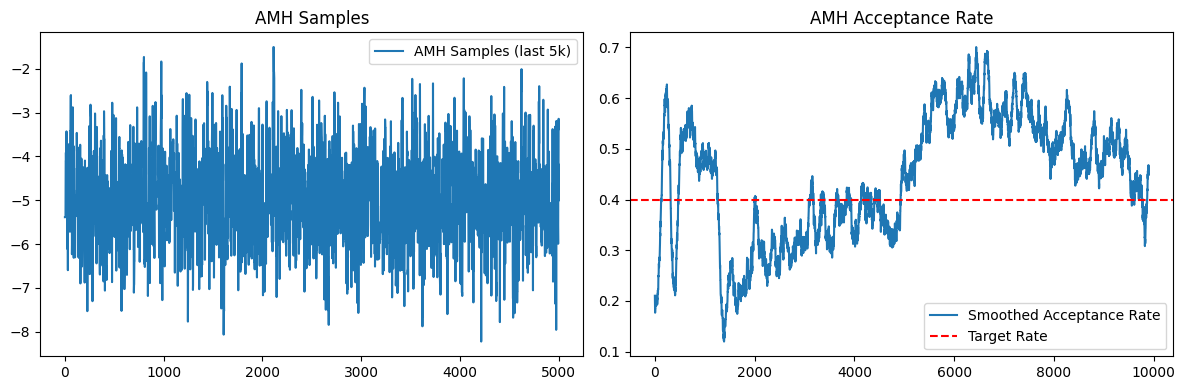

Pre-training Actor network...
Starting actor pre-training...
Pre-train Step 0, Loss: 5.6916
Pre-train Step 100, Loss: 0.0263
Pre-train Step 200, Loss: 0.0175
Pre-train Step 300, Loss: 0.0119
Pre-train Step 400, Loss: 0.0085
Pre-train Step 500, Loss: 0.0066
Pre-train Step 600, Loss: 0.0056
Pre-train Step 700, Loss: 0.0049
Pre-train Step 800, Loss: 0.0045
Pre-train Step 900, Loss: 0.0042
Pre-training finished.
Actor pre-training complete.
Starting RLMH + DDPG training...
Iteration 0/100000, Avg Reward (last 1k): 0.094, Avg Accept (last 1k): 1.000, Buffer Size: 1, Time/1k iter: 0.15s


/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_1887/4097851905.py:312: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  new_target_actor_params = jax.tree_map(
/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_1887/4097851905.py:316: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  new_target_critic_params = jax.tree_map(


Iteration 1000/100000, Avg Reward (last 1k): -6.014, Avg Accept (last 1k): 0.843, Buffer Size: 1001, Time/1k iter: 0.31s
  Critic Loss: 120.976, Actor Loss: -0.618
Iteration 2000/100000, Avg Reward (last 1k): -11.858, Avg Accept (last 1k): 0.611, Buffer Size: 2001, Time/1k iter: 3.84s
  Critic Loss: 159.976, Actor Loss: 3.118
Iteration 3000/100000, Avg Reward (last 1k): -13.956, Avg Accept (last 1k): 0.511, Buffer Size: 3001, Time/1k iter: 3.94s
  Critic Loss: 219.639, Actor Loss: 5.893
Iteration 4000/100000, Avg Reward (last 1k): -21.388, Avg Accept (last 1k): 0.260, Buffer Size: 4001, Time/1k iter: 3.84s
  Critic Loss: 295.989, Actor Loss: 7.787
Iteration 5000/100000, Avg Reward (last 1k): -24.996, Avg Accept (last 1k): 0.106, Buffer Size: 5001, Time/1k iter: 3.86s
  Critic Loss: 320.589, Actor Loss: 10.898
Iteration 6000/100000, Avg Reward (last 1k): -23.670, Avg Accept (last 1k): 0.142, Buffer Size: 6001, Time/1k iter: 3.90s
  Critic Loss: 386.754, Actor Loss: 11.993
Iteration 7000

TypeError: unsupported format string passed to numpy.ndarray.__format__

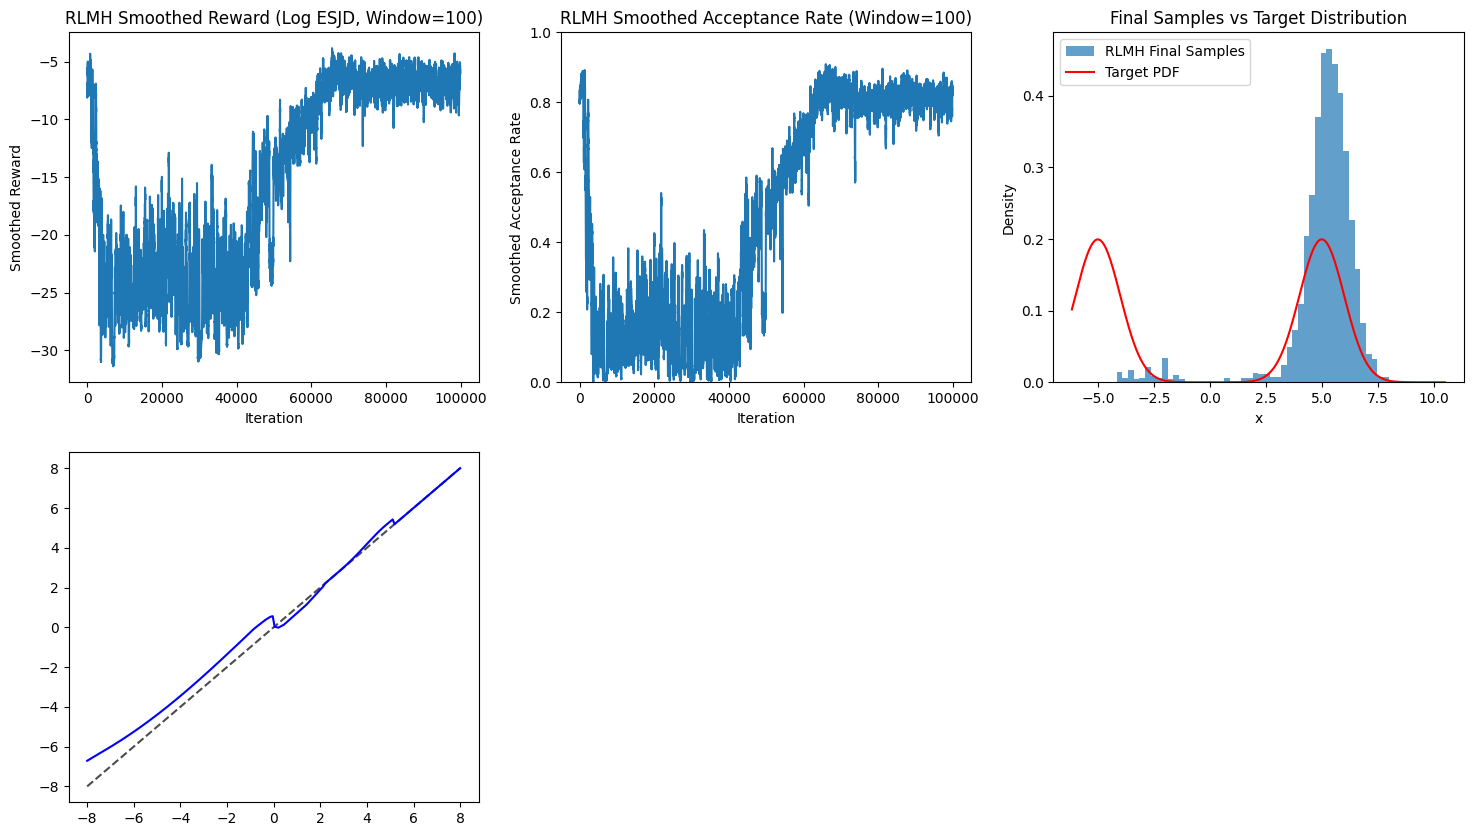

In [260]:
# %% Imports
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
from functools import partial
from typing import Sequence, Callable, Any
from flax.training import train_state  # Simple TrainState for managing params/opt
import random
import collections
import time
import numpy as np # For plotting and buffer

# Configure JAX for CPU/GPU
# jax.config.update('jax_platform_name', 'cpu') # Or 'gpu'
jax.config.update("jax_enable_x64", True) # Use float64 for more MCMC stability

# %% Target Distribution (Example: Gaussian Mixture Model from Fig 1)
class GMMTarget:
    def __init__(self, means=jnp.array([-5.0, 5.0]), stds=jnp.array([1.0, 1.0]), weights=jnp.array([0.5, 0.5])):
        self.means = means
        self.stds = stds
        self.weights = weights
        self.dim = 1 # Hardcoded for 1D example
        # Precompute log weights and inverse variances
        self.log_weights = jnp.log(weights)
        self.inv_vars = 1.0 / (stds**2)
        self.log_norm_consts = -0.5 * jnp.log(2 * jnp.pi * stds**2)

    @partial(jax.jit, static_argnums=(0,))
    def log_prob(self, x):
        # Assumes x is a scalar or (1,) array for 1D
        x = jnp.squeeze(x) # Ensure scalar for broadcasting
        log_probs_components = self.log_norm_consts - 0.5 * (x - self.means)**2 * self.inv_vars
        log_likelihoods = self.log_weights + log_probs_components
        return jax.scipy.special.logsumexp(log_likelihoods)

    # Helper for plotting
    def pdf(self, x_grid):
         return jnp.exp(jax.vmap(self.log_prob)(x_grid))

# Instantiate the target
target = GMMTarget()
target_log_prob = target.log_prob
target_dim = target.dim

# %% Adaptive Metropolis-Hastings (AMH) - Algorithm 3 Warm-up

# %% Adaptive Metropolis-Hastings (AMH) - Algorithm 3 Warm-up

# Correct decorator
@partial(jax.jit, static_argnums=(1, 2)) # Only m and target_log_prob are static
def run_amh(key, m, target_log_prob, initial_mean, initial_cov, target_acceptance=0.234, beta=0.7):
    """Runs the AMH algorithm (Alg 3)."""

    # Ensure dimensions are treated statically if needed inside,
    # but initial_mean/cov values are dynamic.
    dim = initial_mean.shape[0] # This is fine, shape can be used dynamically
    Sigma_init = jnp.atleast_2d(initial_cov) # Ensure 2D

    def amh_scan_body(carry, i):
        key, x_prev, mu_prev, Sigma_prev, log_lambda_prev = carry
        key, subkey = jax.random.split(key)

        # --- Proposal ---
        lambda_prev = jnp.exp(log_lambda_prev)
        # Ensure Sigma_prev is PSD for Cholesky
        # Get dim dynamically inside scan if needed, or pass as static if necessary
        # dim_scan = Sigma_prev.shape[0] # Example dynamic dim access
        jitter = 1e-6 * jnp.eye(dim) # Use dim derived from initial_mean outside scan
        chol_prev = jnp.linalg.cholesky(Sigma_prev + jitter)

        # Proposal: x* ~ N(x_{i-1}, lambda_{i-1}^2 * Sigma_{i-1})
        z = jax.random.normal(subkey, shape=(dim,)) # Use dim derived outside
        x_star = x_prev + lambda_prev * jnp.dot(chol_prev, z)

        # --- Acceptance ---
        log_prob_star = target_log_prob(x_star)
        log_prob_prev = target_log_prob(x_prev)
        log_alpha = jnp.minimum(0.0, log_prob_star - log_prob_prev)
        acceptance_prob = jnp.exp(log_alpha)

        # --- Accept/Reject ---
        key, subkey = jax.random.split(key)
        accept = jax.random.uniform(subkey) < acceptance_prob
        x_curr = jnp.where(accept, x_star, x_prev)

        # --- Adaptation ---
        gamma_i = 1.0 / ((i + 1)**beta) # Learning rate (Eq. 32 simplified)

        # Update log_lambda
        log_lambda_curr = log_lambda_prev + gamma_i * (acceptance_prob - target_acceptance)

        # Update mean
        mu_curr = mu_prev + gamma_i * (x_curr - mu_prev)

        # Update covariance (ensure correct shapes for outer product)
        diff = x_curr - mu_prev
        outer_prod = jnp.outer(diff, diff) # Should be dim x dim
        Sigma_curr = Sigma_prev + gamma_i * (outer_prod - Sigma_prev)

        # Ensure Sigma remains symmetric (optional, but good practice)
        Sigma_curr = 0.5 * (Sigma_curr + Sigma_curr.T)

        next_carry = (key, x_curr, mu_curr, Sigma_curr, log_lambda_curr)
        outputs = (x_curr, acceptance_prob) # Store samples and acceptance rate
        return next_carry, outputs

    # Initial state for the scan
    key, subkey = jax.random.split(key)
    # dim = initial_mean.shape[0] # Get dim here
    x0 = jnp.zeros_like(initial_mean) # Use initial_mean shape info
    mu0 = initial_mean
    log_lambda0 = jnp.log(2.38 / jnp.sqrt(dim)) # Use dim

    initial_carry = (subkey, x0, mu0, Sigma_init, log_lambda0)
    indices = jnp.arange(m) # m is static

    final_carry, outputs = jax.lax.scan(amh_scan_body, initial_carry, indices)

    _, _, final_mu, final_Sigma, final_log_lambda = final_carry
    samples, accept_probs = outputs
    return samples, final_mu, final_Sigma, accept_probs

# %% Flax Networks

class Actor(nn.Module):
    features: Sequence[int]
    action_dim: int
    max_action: float = 10.0 # Add a scaling factor

    @nn.compact
    def __call__(self, x):
        x = jnp.atleast_1d(x)
        for feat in self.features:
            x = nn.relu(nn.Dense(features=feat)(x))
        # Use tanh to bound output between -1 and 1
        psi_unscaled = nn.tanh(nn.Dense(features=self.action_dim)(x))
        # Scale to [-max_action, max_action]
        psi = self.max_action * psi_unscaled
        return psi

class Critic(nn.Module):
    features: Sequence[int] # Hidden layer sizes

    @nn.compact
    def __call__(self, x, action):
        # Input x: state (dim,)
        # Input action: psi (dim,)
        x = jnp.atleast_1d(x)
        action = jnp.atleast_1d(action)
        # Concatenate state and action
        concat = jnp.concatenate([x, action], axis=-1)
        for feat in self.features:
            concat = nn.relu(nn.Dense(features=feat)(concat))
        q_value = nn.Dense(features=1)(concat)
        return jnp.squeeze(q_value) # Output scalar Q-value


# %% Policy Construction and Helper Functions (Eq. 30, App B.3/B.4)

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq',))
def gamma_C(x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Smooth transition function gamma_C(x)."""
    diff = x - x_bar
    eta_num = jnp.dot(diff, jnp.dot(Sigma_inv_sqrt.T, jnp.dot(Sigma_inv_sqrt, diff))) # ||Sigma^{-1/2}(x-x_bar)||^2
    eta = eta_num / ellipsoid_radius_sq # eta(x) = ||...||^2 / l^2

    # Piecewise function gamma(eta) from Appendix B.4
    val_case1 = 0.0                                 # eta < 0.5
    val_case2 = 1.0 / (1.0 + jnp.exp(-(4*eta - 3) / (4*eta**2 - 6*eta + 2 + 1e-8))) # 0.5 <= eta <= 1.0 (added epsilon for stability)
    val_case3 = 1.0                                 # eta > 1.0

    gamma = jnp.where(eta < 0.5, val_case1, jnp.where(eta <= 1.0, val_case2, val_case3))
    return gamma

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq',))
def construct_phi(psi, x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Constructs phi_theta(x) from psi_theta(x) using Eq. 30."""
    g = gamma_C(x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    phi = psi + g * (x - psi)
    return phi

@jax.jit
def calculate_l1_sigma_norm(y, mu, Sigma_inv_sqrt):
    """Calculates ||y - mu||_{1, Sigma} = ||Sigma^{-1/2}(y - mu)||_1."""
    diff = y - mu
    transformed_diff = jnp.dot(Sigma_inv_sqrt, diff)
    return jnp.sum(jnp.abs(transformed_diff))

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq', 'actor_apply')) # ADD actor_apply
def proposal_log_prob_laplace(y, x, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Calculates log q(y|x) based on Laplace density (Eq. 6, ignoring normalization)."""
    psi = actor_apply({'params': actor_params}, x)
    phi = construct_phi(psi, x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    norm_val = calculate_l1_sigma_norm(y, phi, Sigma_inv_sqrt)
    return -norm_val

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq','target_log_prob', 'actor_apply')) # ADD actor_apply and target_log_prob
def calculate_acceptance_log_prob(x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq, target_log_prob):
    """Calculates the log MH acceptance probability log alpha_phi (Eq. 2)."""
    # Log target ratio
    log_target_ratio = target_log_prob(x_star) - target_log_prob(x_n)

    # Log proposal ratio: log( q(x_n | x_star) / q(x_star | x_n) )
    log_q_reverse = proposal_log_prob_laplace(x_n, x_star, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    log_q_forward = proposal_log_prob_laplace(x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    log_proposal_ratio = log_q_reverse - log_q_forward

    return jnp.minimum(0.0, log_target_ratio + log_proposal_ratio) # log(min(1, ratio))


@jax.jit
def calculate_reward(x_next, x_n, log_acceptance_prob):
    """Calculates the log ESJD reward."""
    # Ensure inputs are treated as vectors for norm
    x_next = jnp.atleast_1d(x_next)
    x_n = jnp.atleast_1d(x_n)

    sq_jump_dist = jnp.sum((x_next - x_n)**2)
    # Reward = log( E[||jump||^2] ) = log( ||jump||^2 * alpha )
    # Reward = log( ||x_star - x_n||^2 * alpha_phi(x_n, x_star) ) if accepted
    # Reward = log( 0 ) if rejected? The paper uses expectation over accept/reject.
    # r_n = log( ||x*_n+1 - x_n||^2 * alpha(x_n, x*_n+1) + 0 * (1-alpha) )
    # r_n = log( ||x*_n+1 - x_n||^2 ) + log(alpha(x_n, x*_n+1)) ??
    # Let's use the paper's definition from Sec 2.2:
    # r_n = 2 * log ||x_n - x_{n+1}|| + log alpha_phi(x_n, x^*_{n+1})
    # Where x_{n+1} is the state AFTER accept/reject. alpha is based on proposal x*.
    # Need ||x_n - x_{n+1}|| > 0 for log. Add small epsilon.
    log_sq_jump = jnp.log(sq_jump_dist + 1e-10) # Add epsilon for stability
    # The acceptance probability used here should be for the *proposed* step x*_n+1
    reward = log_sq_jump + log_acceptance_prob
    # The paper mentions 2*log||...||. Is it ||x_n - x_{n+1}|| or ||x_n - x^*_{n+1}||?
    # Let's assume it's the actual jump distance x_n -> x_{n+1}.
    # reward = 2 * 0.5 * jnp.log(sq_jump_dist + 1e-10) + log_acceptance_prob

    # Let's re-read Sec 2.2 carefully:
    # "r_n = 2log ||Xn - Xn+1|| + log α_φ(Xn, X*n+1)"
    # Xn+1 is the state after accept/reject.
    # X*n+1 is the proposal.
    # alpha_phi is calculated based on Xn and X*n+1.
    # Okay, the formula seems correct.

    # Clamp reward for stability? Maybe not necessary if log_alpha is handled well.
    return reward


# %% Replay Buffer

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        # Store as numpy arrays for easier handling outside JAX
        self.buffer.append((np.array(state), np.array(action), reward, np.array(next_state), done))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*(self.buffer[i] for i in indices))
        return jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(next_states), jnp.array(dones)

    def __len__(self):
        return len(self.buffer)

# %% DDPG Training Step

@partial(jax.jit, static_argnames=('actor_apply', 'critic_apply', 'discount', 'tau_polyak'))
def ddpg_update(
    key,
    actor_state, critic_state, # Flax TrainState (params + opt_state)
    target_actor_params, target_critic_params, # Just params
    actor_apply, critic_apply, # Network apply functions
    batch, # Sampled from replay buffer
    discount, # Gamma (DDPG discount factor)
    tau_polyak, # For updating target networks
    ):
    states, actions, rewards, next_states, dones = batch
    rewards = jnp.clip(rewards, -50.0, 50.0) # Adjust bounds as needed

    # --- Critic Update ---
    # Target Q value using target networks
    next_actions = actor_apply({'params': target_actor_params}, next_states)
    next_q = critic_apply({'params': target_critic_params}, next_states, next_actions)
    target_q = rewards + discount * (1. - dones) * next_q

    def critic_loss_fn(critic_params):
        current_q = critic_apply({'params': critic_params}, states, actions)
        loss = jnp.mean((current_q - target_q)**2)
        return loss

    critic_loss_val, critic_grads = jax.value_and_grad(critic_loss_fn)(critic_state.params)
    critic_state = critic_state.apply_gradients(grads=critic_grads)

    # --- Actor Update ---
    def actor_loss_fn(actor_params):
        # We want to maximize Q(s, actor(s)), so minimize -Q
        current_actions = actor_apply({'params': actor_params}, states)
        current_q = critic_apply({'params': critic_state.params}, states, current_actions) # Use updated critic params? DDPG paper uses frozen critic params here. Let's use updated.
        loss = -jnp.mean(current_q)
        return loss

    actor_loss_val, actor_grads = jax.value_and_grad(actor_loss_fn)(actor_state.params)

    # --- Gradient Clipping (as per RLMH Algo 1) ---
    # Optax handles clipping during apply_gradients if configured in the optimizer chain
    actor_state = actor_state.apply_gradients(grads=actor_grads)


    # --- Update Target Networks (Polyak Averaging) ---
    new_target_actor_params = jax.tree_map(
        lambda target, online: target * (1.0 - tau_polyak) + online * tau_polyak,
        target_actor_params, actor_state.params
    )
    new_target_critic_params = jax.tree_map(
        lambda target, online: target * (1.0 - tau_polyak) + online * tau_polyak,
        target_critic_params, critic_state.params
    )

    metrics = {'critic_loss': critic_loss_val, 'actor_loss': actor_loss_val}
    return actor_state, critic_state, new_target_actor_params, new_target_critic_params, metrics


# %% RLMH Environment Step Function

@partial(jax.jit, static_argnames=(
    'actor_apply', 'ellipsoid_radius_sq', 'target_log_prob', 'proposal_scale'
)) # ADD actor_apply and target_log_prob here too
def rlmh_step(
    key,
    x_n, # Current MCMC state
    actor_params, # Current actor parameters
    actor_apply, # <<<< STATIC
    x_bar, Sigma_sqrt, Sigma_inv_sqrt, # From AMH
    ellipsoid_radius_sq, # <<<< STATIC
    target_log_prob, # <<<< STATIC
    proposal_scale # <<<< STATIC
    ):
    """Performs one step of the RLMH algorithm."""
    key, proposal_key, accept_key = jax.random.split(key, 3)

    # 1. Get policy output and construct proposal mean phi
    psi_n = actor_apply({'params': actor_params}, x_n)
    phi_n = construct_phi(psi_n, x_n, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)

    # 2. Propose x*_{n+1} ~ N(phi_n, proposal_scale^2 * Sigma)
    z = jax.random.normal(proposal_key, shape=x_n.shape)
    x_star = phi_n + proposal_scale * jnp.dot(Sigma_sqrt, z)

    # 3. Calculate acceptance log probability using LAPLACE densities
    log_alpha = calculate_acceptance_log_prob(
        x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq, target_log_prob
    )
    acceptance_prob = jnp.exp(log_alpha)

    # 4. Accept or reject
    accept = jax.random.uniform(accept_key) < acceptance_prob
    x_next = jnp.where(accept, x_star, x_n)

    # 5. Calculate reward (based on x_n, x_next, and log_alpha for x_star)
    reward = calculate_reward(x_next, x_n, log_alpha)

    # Need state/action for DDPG buffer
    state = x_n
    action = psi_n # The action the policy took at state x_n
    next_state = x_next
    done = False

    return state, action, reward, next_state, done, acceptance_prob # Return acceptance prob for monitoring

# %% Pre-training Function

# REMOVE or COMMENT OUT the JIT decorator if you NEED the print
# @partial(jax.jit, static_argnames=('actor_apply', 'pretrain_steps'))
def pretrain_actor(key, actor_state, amh_samples, x_bar, actor_apply, pretrain_steps):
    """Pre-trains the actor psi_theta(x) to approximate x."""
    n_samples = amh_samples.shape[0]

    # Define loss function inside or outside, doesn't matter much here
    @jax.jit # JIT the loss/grad calculation itself for efficiency
    def train_step(actor_state):
        def loss_fn(params):
            # Predict psi for all AMH samples
            psi_pred = jax.vmap(lambda x: actor_apply({'params': params}, x))(amh_samples)
            # Target is simply the input sample x itself
            target_psi = amh_samples
            loss = jnp.mean((psi_pred - target_psi)**2)
            return loss
        loss, grads = jax.value_and_grad(loss_fn)(actor_state.params)
        actor_state = actor_state.apply_gradients(grads=grads)
        return actor_state, loss

    print("Starting actor pre-training...")
    for step in range(pretrain_steps):
        # Run the JITted training step
        actor_state, loss = train_step(actor_state)
        # Now loss is a concrete value *after* the step is executed
        if step % 100 == 0:
            # Print OUTSIDE the JITted part
            print(f"Pre-train Step {step}, Loss: {loss:.4f}")

    print("Pre-training finished.")
    return actor_state


# %% Main Setup and Training Loop

def main_rlmh_training():
    # --- Hyperparameters ---
    # AMH
    amh_iterations = 10000
    amh_target_acceptance = 0.4 # Often better for adaptation than 0.234
    amh_beta = 0.7

    # RLMH
    rlmh_iterations = 100000
    proposal_scale = 0.5 # Scaling for the Gaussian proposal *sampling* variance
    ellipsoid_radius = 10.0 # Radius 'l' for gamma_C, App B.4
    gradient_clip_tau = 1.0 # RLMH gradient clipping threshold (applied via Optax)

    # DDPG
    replay_capacity = 100000
    batch_size = 64
    ddpg_discount = 0.99 # Reward discount factor gamma
    actor_lr = 1e-6 # RLMH policy learning rate alpha_n (constant here)
    critic_lr = 1e-5
    tau_polyak = 0.005 # Target network update rate
    warmup_steps = 1000 # Steps to fill buffer before DDPG updates start

    # Pre-training
    pretrain_steps = 1000
    pretrain_lr = 1e-3

    # Network Arch
    actor_features = [32, 32]
    critic_features = [64, 64]

    # Random Key
    key = jax.random.PRNGKey(42)

    # --- 1. AMH Warm-up ---
    print("Running AMH Warm-up...")
    key, amh_key = jax.random.split(key)
    amh_initial_mean = jnp.zeros(target_dim)
    amh_initial_cov = jnp.eye(target_dim) * 1.0

    amh_samples, final_mu, final_Sigma, amh_accept_probs = run_amh(
        amh_key, amh_iterations, target_log_prob, amh_initial_mean, amh_initial_cov,
        target_acceptance=amh_target_acceptance, beta=amh_beta
    )
    print(f"AMH finished. Final Mean: {final_mu}, Acceptance Rate: {jnp.mean(amh_accept_probs):.3f}")
    # print(f"Final Sigma: {final_Sigma}") # Can be large output

    # Store warm-up results (ensure Sigma is PD)
    x_bar = final_mu
    jitter = 1e-6 * jnp.eye(target_dim)
    Sigma = 0.5 * (final_Sigma + final_Sigma.T) + jitter # Ensure symmetry and PD
    Sigma_sqrt = jnp.linalg.cholesky(Sigma)
    Sigma_inv_sqrt = jnp.linalg.inv(Sigma_sqrt)
    ellipsoid_radius_sq = ellipsoid_radius**2

    # Plot AMH results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(amh_samples[-5000:], label='AMH Samples (last 5k)')
    plt.title('AMH Samples')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(jnp.convolve(amh_accept_probs, jnp.ones(100)/100, mode='valid'), label='Smoothed Acceptance Rate')
    plt.axhline(amh_target_acceptance, color='r', linestyle='--', label='Target Rate')
    plt.title('AMH Acceptance Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # --- 2. Initialize Networks and Optimizers ---
    key, actor_key, critic_key = jax.random.split(key, 3)
    dummy_state = jnp.zeros((target_dim,))
    dummy_action = jnp.zeros((target_dim,)) # psi has same dim as state

    actor = Actor(features=actor_features, action_dim=target_dim)
    critic = Critic(features=critic_features)

    actor_params = actor.init(actor_key, dummy_state)['params']
    critic_params = critic.init(critic_key, dummy_state, dummy_action)['params']

    # Optimizers with gradient clipping for actor
    actor_optimizer = optax.chain(
        optax.clip_by_global_norm(gradient_clip_tau),
        optax.adam(learning_rate=actor_lr)
    )
    critic_optimizer = optax.chain(
        optax.clip_by_global_norm(10.0), # Clip critic grads too (adjust value if needed)
        optax.adam(learning_rate=critic_lr)
    )

    actor_state = train_state.TrainState.create(apply_fn=actor.apply, params=actor_params, tx=actor_optimizer)
    critic_state = train_state.TrainState.create(apply_fn=critic.apply, params=critic_params, tx=critic_optimizer)

    # Target networks
    target_actor_params = actor_params
    target_critic_params = critic_params

    # --- 3. Pre-train Actor ---
    print("Pre-training Actor network...")
    key, pretrain_key = jax.random.split(key)
    # Use a separate optimizer for pre-training
    pretrain_optimizer = optax.adam(learning_rate=pretrain_lr)
    pretrain_actor_state = train_state.TrainState.create(apply_fn=actor.apply, params=actor_state.params, tx=pretrain_optimizer)

    # Select subset of AMH samples for pre-training if needed
    pretrain_samples = amh_samples # Use all for now

    pretrain_actor_state = pretrain_actor(pretrain_key, pretrain_actor_state, pretrain_samples, x_bar, actor.apply, pretrain_steps)

    # Transfer pre-trained params back to main actor state
    actor_state = actor_state.replace(params=pretrain_actor_state.params)
    target_actor_params = actor_state.params # Update target network too
    print("Actor pre-training complete.")


    # --- 4. RLMH + DDPG Training Loop ---
    print("Starting RLMH + DDPG training...")
    replay_buffer = ReplayBuffer(replay_capacity)
    rewards_history = []
    accept_history = []

    # Initial state for RLMH chain
    current_x = amh_samples[-1] # Start from last AMH sample

    start_time = time.time()
    for i in range(rlmh_iterations):
        key, step_key, buffer_key, update_key = jax.random.split(key, 4)

        # --- RLMH Environment Step ---
        state, action, reward, next_state, done, accept_prob = rlmh_step(
            step_key, current_x, actor_state.params, actor.apply,
            x_bar, Sigma_sqrt, Sigma_inv_sqrt, ellipsoid_radius_sq,
            target_log_prob, proposal_scale
        )

        # Add to replay buffer
        replay_buffer.add(state, action, reward, next_state, done)
        rewards_history.append(reward)
        accept_history.append(accept_prob)

        # Update current state
        current_x = next_state

        # --- DDPG Update Step ---
        if len(replay_buffer) > warmup_steps and i % 1 == 0: # Update every step after warmup
             batch = replay_buffer.sample(batch_size)
             actor_state, critic_state, target_actor_params, target_critic_params, metrics = ddpg_update(
                 update_key,
                 actor_state, critic_state,
                 target_actor_params, target_critic_params,
                 actor.apply, critic.apply,
                 batch,
                 ddpg_discount, tau_polyak
             )

        # --- Logging ---
        if i % 1000 == 0:
            end_time = time.time()
            print(f"Iteration {i}/{rlmh_iterations}, Avg Reward (last 1k): {jnp.mean(jnp.array(rewards_history[-1000:])):.3f}, "
                  f"Avg Accept (last 1k): {jnp.mean(jnp.array(accept_history[-1000:])):.3f}, "
                  f"Buffer Size: {len(replay_buffer)}, "
                  f"Time/1k iter: {end_time - start_time:.2f}s")
            if len(replay_buffer) > warmup_steps:
                 print(f"  Critic Loss: {metrics['critic_loss']:.3f}, Actor Loss: {metrics['actor_loss']:.3f}")
            start_time = time.time() # Reset timer


    print("RLMH training finished.")

    # --- 5. Generate Final Samples & Visualize ---
    print("Generating final samples with learned policy...")
    final_samples = []
    key, final_sample_key = jax.random.split(key)
    current_x = amh_samples[-1] # Start from a reasonable point
    n_final_samples = 5000

    for _ in range(n_final_samples):
        final_sample_key, step_key = jax.random.split(final_sample_key)
        _, _, _, next_state, _, _ = rlmh_step(
            step_key, current_x, actor_state.params, actor.apply,
            x_bar, Sigma_sqrt, Sigma_inv_sqrt, ellipsoid_radius_sq,
            target_log_prob, proposal_scale
        )
        final_samples.append(next_state)
        current_x = next_state

    final_samples = jnp.array(final_samples)

    # --- Visualization ---
    plt.figure(figsize=(18, 10))

    # Reward History
    plt.subplot(2, 3, 1)
    # Smooth rewards for better visibility
    smoothing_window = 100
    smoothed_rewards = np.convolve(rewards_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
    plt.plot(smoothed_rewards)
    plt.title(f'RLMH Smoothed Reward (Log ESJD, Window={smoothing_window})')
    plt.xlabel('Iteration')
    plt.ylabel('Smoothed Reward')

    # Acceptance Rate History
    plt.subplot(2, 3, 2)
    smoothed_accept = np.convolve(accept_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
    plt.plot(smoothed_accept)
    plt.title(f'RLMH Smoothed Acceptance Rate (Window={smoothing_window})')
    plt.xlabel('Iteration')
    plt.ylabel('Smoothed Acceptance Rate')
    plt.ylim(0, 1)


    # Final Sample Histogram vs Target PDF
    plt.subplot(2, 3, 3)
    x_plot = jnp.linspace(jnp.min(final_samples) - 2, jnp.max(final_samples) + 2, 500)
    target_pdf_plot = target.pdf(x_plot)
    plt.hist(np.array(final_samples), bins=50, density=True, alpha=0.7, label='RLMH Final Samples')
    plt.plot(x_plot, target_pdf_plot, 'r-', label='Target PDF')
    plt.title('Final Samples vs Target Distribution')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()

    # Learned phi(x) function
    plt.subplot(2, 3, 4)
    x_plot_phi = jnp.linspace(-8, 8, 200) # Widen plot range a bit

    # Recalculate final learned phi for the new range
    psi_learned = jax.vmap(lambda x: actor.apply({'params': actor_state.params}, x))(x_plot_phi[:, None])
    phi_learned = jax.vmap(construct_phi, in_axes=(0, 0, None, None, None))(
        psi_learned, x_plot_phi, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq
    )
    plt.plot(x_plot_phi, x_plot_phi, 'k--', label='y=x (Random Walk Mean)', alpha=0.7)
    plt.plot(x_plot_phi, phi_learned, 'b-', label='Learned phi(x)')


    # --- DEBUG: Plot initial phi(x) ---
    pretrain_actor_params_final = pretrain_actor_state.params # Params after pretraining
    # Print inputs to be sure
    print("\n--- Plotting Initial Phi ---")
    print(f"Using x_bar: {x_bar}")
    # print(f"Using Sigma_inv_sqrt: {Sigma_inv_sqrt}") # Can be large
    print(f"Using ellipsoid_radius_sq: {ellipsoid_radius_sq}")

    # Calculate psi_initial
    psi_initial = jax.vmap(lambda x: actor.apply({'params': pretrain_actor_params_final}, x))(x_plot_phi[:, None])

    # Calculate phi_initial
    phi_initial = jax.vmap(construct_phi, in_axes=(0, 0, None, None, None))(
        psi_initial, x_plot_phi, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq
    )

    # Print intermediate values for a point (e.g., x=0)
    test_x_plot_index = jnp.argmin(jnp.abs(x_plot_phi - 0.0))
    test_x = x_plot_phi[test_x_plot_index]
    test_psi = psi_initial[test_x_plot_index]
    test_gamma = gamma_C(test_x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    test_phi = phi_initial[test_x_plot_index]
    print(f"Example point x={test_x:.2f}: psi_initial={test_psi:.2f}, gamma_C={test_gamma:.2f}, phi_initial={test_phi:.2f} (Should be approx {test_x:.2f})")
    # --- END DEBUG ---

    plt.plot(x_plot_phi, phi_initial, 'g:', label='Initial phi(x) (post-pretrain)')
    plt.title('Proposal Mean Function phi(x)')
    plt.xlabel('x')
    plt.ylabel('phi(x)')
    plt.legend()
    # Set sensible y-limits if phi explodes
    plt.ylim(min(jnp.min(x_plot_phi)-5, jnp.min(phi_learned)-5),
            max(jnp.max(x_plot_phi)+5, jnp.max(phi_learned)+5) if jnp.max(phi_learned) < 500 else 50) # Limit crazy y-axis

    # Placeholder for critic loss / actor loss if needed
    plt.subplot(2, 3, 5)
    plt.title('Placeholder for DDPG Losses')


    plt.tight_layout()
    plt.show()


# %% Run Training
if __name__ == "__main__":
    main_rlmh_training()

Running AMH Warm-up...
AMH finished. Final Mean: [-5.02854472], Acceptance Rate: 0.444


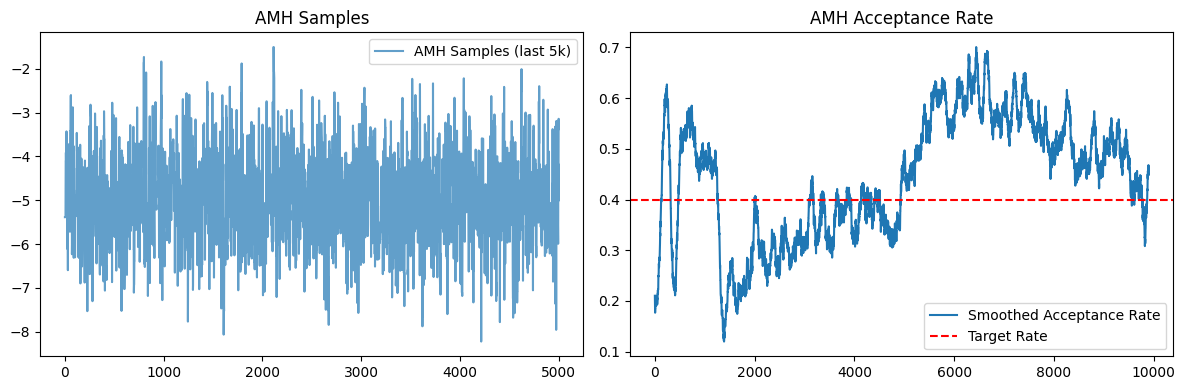

Pre-training Actor network...
Starting actor pre-training...


AttributeError: 'function' object has no attribute 'max_action'

In [261]:
# %% Imports
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
from functools import partial
from typing import Sequence, Callable, Any
from flax.training import train_state  # Simple TrainState for managing params/opt
import random
import collections
import time
import numpy as np # For plotting and buffer

# Configure JAX for CPU/GPU
# jax.config.update('jax_platform_name', 'cpu') # Or 'gpu'
jax.config.update("jax_enable_x64", True) # Use float64 for more MCMC stability

# %% Target Distribution (Example: Gaussian Mixture Model from Fig 1)
class GMMTarget:
    def __init__(self, means=jnp.array([-5.0, 5.0]), stds=jnp.array([1.0, 1.0]), weights=jnp.array([0.5, 0.5])):
        self.means = means
        self.stds = stds
        self.weights = weights
        self.dim = 1 # Hardcoded for 1D example
        # Precompute log weights and inverse variances
        self.log_weights = jnp.log(weights)
        self.inv_vars = 1.0 / (stds**2)
        self.log_norm_consts = -0.5 * jnp.log(2 * jnp.pi * stds**2)

    @partial(jax.jit, static_argnums=(0,))
    def log_prob(self, x):
        # Assumes x is a scalar or (1,) array for 1D
        x = jnp.squeeze(x) # Ensure scalar for broadcasting
        log_probs_components = self.log_norm_consts - 0.5 * (x - self.means)**2 * self.inv_vars
        log_likelihoods = self.log_weights + log_probs_components
        return jax.scipy.special.logsumexp(log_likelihoods)

    # Helper for plotting
    def pdf(self, x_grid):
         # Use vmap on the instance method
         return jnp.exp(jax.vmap(self.log_prob)(x_grid))

# Instantiate the target
target = GMMTarget()
target_log_prob = target.log_prob # Pass the method directly
target_dim = target.dim

# %% Adaptive Metropolis-Hastings (AMH) - Algorithm 3 Warm-up

# Correct decorator - Only m and target_log_prob are static
@partial(jax.jit, static_argnums=(1, 2))
def run_amh(key, m, target_log_prob, initial_mean, initial_cov, target_acceptance=0.234, beta=0.7):
    """Runs the AMH algorithm (Alg 3)."""

    dim = initial_mean.shape[0]
    Sigma_init = jnp.atleast_2d(initial_cov)

    def amh_scan_body(carry, i):
        key, x_prev, mu_prev, Sigma_prev, log_lambda_prev = carry
        key, subkey = jax.random.split(key)

        # --- Proposal ---
        lambda_prev = jnp.exp(log_lambda_prev)
        jitter = 1e-6 * jnp.eye(dim)
        chol_prev = jnp.linalg.cholesky(Sigma_prev + jitter)
        z = jax.random.normal(subkey, shape=(dim,))
        x_star = x_prev + lambda_prev * jnp.dot(chol_prev, z)

        # --- Acceptance ---
        log_prob_star = target_log_prob(x_star)
        log_prob_prev = target_log_prob(x_prev)
        log_alpha = jnp.minimum(0.0, log_prob_star - log_prob_prev)
        acceptance_prob = jnp.exp(log_alpha)

        # --- Accept/Reject ---
        key, subkey = jax.random.split(key)
        accept = jax.random.uniform(subkey) < acceptance_prob
        x_curr = jnp.where(accept, x_star, x_prev)

        # --- Adaptation ---
        gamma_i = 1.0 / ((i + 1)**beta)

        # Update log_lambda
        log_lambda_curr = log_lambda_prev + gamma_i * (acceptance_prob - target_acceptance)

        # Update mean
        mu_curr = mu_prev + gamma_i * (x_curr - mu_prev)

        # Update covariance
        diff = x_curr - mu_prev
        outer_prod = jnp.outer(diff, diff)
        Sigma_curr = Sigma_prev + gamma_i * (outer_prod - Sigma_prev)
        Sigma_curr = 0.5 * (Sigma_curr + Sigma_curr.T) # Ensure symmetry

        next_carry = (key, x_curr, mu_curr, Sigma_curr, log_lambda_curr)
        outputs = (x_curr, acceptance_prob)
        return next_carry, outputs

    # Initial state for the scan
    key, subkey = jax.random.split(key)
    x0 = jnp.zeros_like(initial_mean)
    mu0 = initial_mean
    log_lambda0 = jnp.log(2.38 / jnp.sqrt(dim))

    initial_carry = (subkey, x0, mu0, Sigma_init, log_lambda0)
    indices = jnp.arange(m)

    final_carry, outputs = jax.lax.scan(amh_scan_body, initial_carry, indices)

    _, _, final_mu, final_Sigma, final_log_lambda = final_carry
    samples, accept_probs = outputs
    return samples, final_mu, final_Sigma, accept_probs

# %% Flax Networks

class Actor(nn.Module):
    features: Sequence[int]
    action_dim: int
    max_action: float = 10.0 # FIX: Add max_action scaling

    @nn.compact
    def __call__(self, x):
        x = jnp.atleast_1d(x)
        for feat in self.features:
            x = nn.relu(nn.Dense(features=feat)(x))
        # FIX: Use tanh to bound output and scale
        psi_unscaled = nn.tanh(nn.Dense(features=self.action_dim)(x))
        psi = self.max_action * psi_unscaled
        return psi

class Critic(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, action):
        x = jnp.atleast_1d(x)
        action = jnp.atleast_1d(action)
        concat = jnp.concatenate([x, action], axis=-1)
        for feat in self.features:
            concat = nn.relu(nn.Dense(features=feat)(concat))
        q_value = nn.Dense(features=1)(concat)
        return jnp.squeeze(q_value)


# %% Policy Construction and Helper Functions (Eq. 30, App B.3/B.4)

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq',))
def gamma_C(x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Smooth transition function gamma_C(x)."""
    x = jnp.atleast_1d(x) # Ensure vector ops work
    x_bar = jnp.atleast_1d(x_bar)
    diff = x - x_bar
    # Correct matrix multiplication for vector diff
    eta_num = jnp.dot(diff.T, Sigma_inv_sqrt.T @ Sigma_inv_sqrt @ diff)
    eta = eta_num / ellipsoid_radius_sq

    val_case1 = 0.0
    # Add epsilon for stability in denominator
    val_case2 = 1.0 / (1.0 + jnp.exp(-(4*eta - 3) / (4*eta**2 - 6*eta + 2 + 1e-8)))
    val_case3 = 1.0

    gamma = jnp.where(eta < 0.5, val_case1, jnp.where(eta <= 1.0, val_case2, val_case3))
    return gamma

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq',))
def construct_phi(psi, x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Constructs phi_theta(x) from psi_theta(x) using Eq. 30."""
    psi = jnp.atleast_1d(psi)
    x = jnp.atleast_1d(x)
    g = gamma_C(x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    phi = psi + g * (x - psi)
    return phi

@jax.jit
def calculate_l1_sigma_norm(y, mu, Sigma_inv_sqrt):
    """Calculates ||y - mu||_{1, Sigma} = ||Sigma^{-1/2}(y - mu)||_1."""
    y = jnp.atleast_1d(y)
    mu = jnp.atleast_1d(mu)
    diff = y - mu
    transformed_diff = jnp.dot(Sigma_inv_sqrt, diff)
    return jnp.sum(jnp.abs(transformed_diff))

# Correct decorator - actor_apply is static
@partial(jax.jit, static_argnames=('ellipsoid_radius_sq', 'actor_apply'))
def proposal_log_prob_laplace(y, x, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Calculates log q(y|x) based on Laplace density (Eq. 6, ignoring normalization)."""
    psi = actor_apply({'params': actor_params}, x)
    phi = construct_phi(psi, x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    norm_val = calculate_l1_sigma_norm(y, phi, Sigma_inv_sqrt)
    return -norm_val

# Correct decorator - actor_apply and target_log_prob are static
@partial(jax.jit, static_argnames=('ellipsoid_radius_sq','target_log_prob', 'actor_apply'))
def calculate_acceptance_log_prob(x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq, target_log_prob):
    """Calculates the log MH acceptance probability log alpha_phi (Eq. 2)."""
    log_target_ratio = target_log_prob(x_star) - target_log_prob(x_n)

    log_q_reverse = proposal_log_prob_laplace(x_n, x_star, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    log_q_forward = proposal_log_prob_laplace(x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    log_proposal_ratio = log_q_reverse - log_q_forward

    return jnp.minimum(0.0, log_target_ratio + log_proposal_ratio)

@jax.jit
def calculate_reward(x_next, x_n, log_acceptance_prob):
    """Calculates the log ESJD reward."""
    x_next = jnp.atleast_1d(x_next)
    x_n = jnp.atleast_1d(x_n)

    sq_jump_dist = jnp.sum((x_next - x_n)**2)
    log_sq_jump = jnp.log(sq_jump_dist + 1e-10) # Add epsilon for stability
    reward = log_sq_jump + log_acceptance_prob # Formula from Sec 2.2

    # Optional: Clip reward if experiencing instability, though clipping before buffer is preferred
    # reward = jnp.clip(reward, -100.0, 100.0) # Example clipping inside calc
    return reward


# %% Replay Buffer

class ReplayBuffer:
    def __init__(self, capacity, reward_clip_range=(-50.0, 50.0)): # FIX: Add reward clipping
        self.buffer = collections.deque(maxlen=capacity)
        self.reward_clip_range = reward_clip_range

    def add(self, state, action, reward, next_state, done):
        # FIX: Clip reward here before storing
        reward_clipped = np.clip(reward, self.reward_clip_range[0], self.reward_clip_range[1])
        self.buffer.append((np.array(state), np.array(action), reward_clipped, np.array(next_state), done))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*(self.buffer[i] for i in indices))
        return jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(next_states), jnp.array(dones)

    def __len__(self):
        return len(self.buffer)

# %% DDPG Training Step

# Correct decorator - actor_apply and critic_apply are static
@partial(jax.jit, static_argnames=('actor_apply', 'critic_apply', 'discount', 'tau_polyak'))
def ddpg_update(
    key,
    actor_state, critic_state, # Flax TrainState (params + opt_state)
    target_actor_params, target_critic_params, # Just params
    actor_apply, critic_apply, # Network apply functions
    batch, # Sampled from replay buffer
    discount, # Gamma (DDPG discount factor)
    tau_polyak, # For updating target networks
    ):
    states, actions, rewards, next_states, dones = batch

    # --- Critic Update ---
    next_actions = actor_apply({'params': target_actor_params}, next_states)
    next_q = critic_apply({'params': target_critic_params}, next_states, next_actions)
    target_q = rewards + discount * (1. - dones) * next_q

    def critic_loss_fn(critic_params):
        current_q = critic_apply({'params': critic_params}, states, actions)
        loss = jnp.mean((current_q - target_q)**2)
        return loss

    critic_loss_val, critic_grads = jax.value_and_grad(critic_loss_fn)(critic_state.params)
    critic_state = critic_state.apply_gradients(grads=critic_grads)

    # --- Actor Update ---
    def actor_loss_fn(actor_params):
        current_actions = actor_apply({'params': actor_params}, states)
        # Use updated critic params for actor gradient calculation
        current_q = critic_apply({'params': critic_state.params}, states, current_actions)
        loss = -jnp.mean(current_q)
        return loss

    actor_loss_val, actor_grads = jax.value_and_grad(actor_loss_fn)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=actor_grads) # Clipping handled by optimizer


    # --- Update Target Networks (Polyak Averaging) ---
    # Use jax.tree.map instead of deprecated jax.tree_map
    new_target_actor_params = jax.tree.map(
        lambda target, online: target * (1.0 - tau_polyak) + online * tau_polyak,
        target_actor_params, actor_state.params
    )
    new_target_critic_params = jax.tree.map(
        lambda target, online: target * (1.0 - tau_polyak) + online * tau_polyak,
        target_critic_params, critic_state.params
    )

    metrics = {'critic_loss': critic_loss_val, 'actor_loss': actor_loss_val}
    return actor_state, critic_state, new_target_actor_params, new_target_critic_params, metrics


# %% RLMH Environment Step Function

# Correct decorator - actor_apply and target_log_prob are static
@partial(jax.jit, static_argnames=(
    'actor_apply', 'ellipsoid_radius_sq', 'target_log_prob', 'proposal_scale'
))
def rlmh_step(
    key,
    x_n, # Current MCMC state
    actor_params, # Current actor parameters
    actor_apply, # <<<< STATIC
    x_bar, Sigma_sqrt, Sigma_inv_sqrt, # From AMH
    ellipsoid_radius_sq, # <<<< STATIC
    target_log_prob, # <<<< STATIC
    proposal_scale # <<<< STATIC
    ):
    """Performs one step of the RLMH algorithm."""
    key, proposal_key, accept_key = jax.random.split(key, 3)

    psi_n = actor_apply({'params': actor_params}, x_n)
    phi_n = construct_phi(psi_n, x_n, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)

    # Propose x* ~ N(phi_n, proposal_scale^2 * Sigma)
    z = jax.random.normal(proposal_key, shape=x_n.shape)
    x_star = phi_n + proposal_scale * jnp.dot(Sigma_sqrt, z)

    # Calculate acceptance log probability using LAPLACE densities
    log_alpha = calculate_acceptance_log_prob(
        x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq, target_log_prob
    )
    acceptance_prob = jnp.exp(log_alpha)

    # Accept or reject
    accept = jax.random.uniform(accept_key) < acceptance_prob
    x_next = jnp.where(accept, x_star, x_n)

    # Calculate reward
    reward = calculate_reward(x_next, x_n, log_alpha)

    state = x_n
    action = psi_n
    next_state = x_next
    done = False

    return state, action, reward, next_state, done, acceptance_prob

# %% Pre-training Function

# Correct JIT handling - JIT the inner step, print outside
def pretrain_actor(key, actor_state, amh_samples, actor_apply, pretrain_steps):
    """Pre-trains the actor psi_theta(x) to approximate x."""
    n_samples = amh_samples.shape[0]

    @jax.jit # JIT the core training step
    def train_step(current_actor_state):
        def loss_fn(params):
            # Predict psi for all AMH samples
            psi_pred = jax.vmap(lambda x: actor_apply({'params': params}, x))(amh_samples)
            # Target is the input sample x itself (potentially clipped by max_action)
            # Target should match the scaled output range of the actor
            target_psi = jnp.clip(amh_samples, -actor_state.apply_fn.max_action, actor_state.apply_fn.max_action)
            # Or, more simply, just train towards x and let the actor scale it
            # target_psi = amh_samples # Let's try this simpler version first
            loss = jnp.mean((psi_pred - target_psi)**2)
            return loss

        loss, grads = jax.value_and_grad(loss_fn)(current_actor_state.params)
        new_actor_state = current_actor_state.apply_gradients(grads=grads)
        return new_actor_state, loss

    print("Starting actor pre-training...")
    total_loss = 0.0
    for step in range(pretrain_steps):
        actor_state, loss = train_step(actor_state) # Call the JITted step
        total_loss += loss
        if (step + 1) % 100 == 0:
            avg_loss = total_loss / 100
            print(f"Pre-train Step {step + 1}, Avg Loss (last 100): {avg_loss:.6f}")
            total_loss = 0.0 # Reset loss accumulator

    print("Pre-training finished.")
    return actor_state


# %% Main Setup and Training Loop

def main_rlmh_training():
    # --- Hyperparameters ---
    amh_iterations = 10000
    amh_target_acceptance = 0.4
    amh_beta = 0.7
    rlmh_iterations = 50000
    proposal_scale = 0.5
    ellipsoid_radius = 10.0
    gradient_clip_tau_actor = 1.0   # FIX: Actor grad clipping
    gradient_clip_tau_critic = 10.0 # FIX: Critic grad clipping
    reward_clip_range = (-50.0, 50.0) # FIX: Reward clipping range

    replay_capacity = 100000
    batch_size = 64
    ddpg_discount = 0.99
    actor_lr = 1e-6 # FIX: Reduced LR
    critic_lr = 1e-5 # FIX: Reduced LR
    tau_polyak = 0.005
    warmup_steps = 1000

    pretrain_steps = 1000
    pretrain_lr = 1e-3

    actor_features = [32, 32]
    critic_features = [64, 64]
    actor_max_action = 15.0 # FIX: Set max action bound (adjust based on target range)

    key = jax.random.PRNGKey(42)

    # --- 1. AMH Warm-up ---
    print("Running AMH Warm-up...")
    key, amh_key = jax.random.split(key)
    amh_initial_mean = jnp.zeros(target_dim)
    amh_initial_cov = jnp.eye(target_dim) * 1.0

    amh_samples, final_mu, final_Sigma, amh_accept_probs = run_amh(
        amh_key, amh_iterations, target_log_prob, amh_initial_mean, amh_initial_cov,
        target_acceptance=amh_target_acceptance, beta=amh_beta
    )
    print(f"AMH finished. Final Mean: {final_mu}, Acceptance Rate: {jnp.mean(amh_accept_probs):.3f}")

    x_bar = final_mu
    jitter = 1e-6 * jnp.eye(target_dim)
    Sigma = 0.5 * (final_Sigma + final_Sigma.T) + jitter
    try:
        Sigma_sqrt = jnp.linalg.cholesky(Sigma)
        Sigma_inv = jnp.linalg.inv(Sigma)
        Sigma_inv_sqrt = jnp.linalg.cholesky(Sigma_inv).T # Inverse of sqrt is transpose of cholesky of inverse
    except jnp.linalg.LinAlgError:
         print("Warning: Final Sigma from AMH not positive definite. Using Identity.")
         Sigma = jnp.eye(target_dim)
         Sigma_sqrt = jnp.eye(target_dim)
         Sigma_inv_sqrt = jnp.eye(target_dim)

    ellipsoid_radius_sq = ellipsoid_radius**2

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(amh_samples[-5000:], label='AMH Samples (last 5k)', alpha=0.7)
    plt.title('AMH Samples')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(jnp.convolve(amh_accept_probs, jnp.ones(100)/100, mode='valid'), label='Smoothed Acceptance Rate')
    plt.axhline(amh_target_acceptance, color='r', linestyle='--', label='Target Rate')
    plt.title('AMH Acceptance Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 2. Initialize Networks and Optimizers ---
    key, actor_key, critic_key = jax.random.split(key, 3)
    dummy_state = jnp.zeros((target_dim,))
    dummy_action = jnp.zeros((target_dim,))

    # FIX: Instantiate actor with max_action
    actor = Actor(features=actor_features, action_dim=target_dim, max_action=actor_max_action)
    critic = Critic(features=critic_features)

    actor_params = actor.init(actor_key, dummy_state)['params']
    critic_params = critic.init(critic_key, dummy_state, dummy_action)['params']

    # FIX: Optimizers with gradient clipping
    actor_optimizer = optax.chain(
        optax.clip_by_global_norm(gradient_clip_tau_actor),
        optax.adam(learning_rate=actor_lr)
    )
    critic_optimizer = optax.chain(
        optax.clip_by_global_norm(gradient_clip_tau_critic),
        optax.adam(learning_rate=critic_lr)
    )

    actor_state = train_state.TrainState.create(apply_fn=actor.apply, params=actor_params, tx=actor_optimizer)
    critic_state = train_state.TrainState.create(apply_fn=critic.apply, params=critic_params, tx=critic_optimizer)

    target_actor_params = actor_params
    target_critic_params = critic_params

    # --- 3. Pre-train Actor ---
    print("Pre-training Actor network...")
    key, pretrain_key = jax.random.split(key)
    pretrain_optimizer = optax.adam(learning_rate=pretrain_lr)
    # Pass actor.apply (the method) correctly
    pretrain_actor_state = train_state.TrainState.create(apply_fn=actor.apply, params=actor_state.params, tx=pretrain_optimizer)
    pretrain_samples = amh_samples
    # Pass actor.apply here
    pretrain_actor_state = pretrain_actor(pretrain_key, pretrain_actor_state, pretrain_samples, actor.apply, pretrain_steps)
    actor_state = actor_state.replace(params=pretrain_actor_state.params)
    target_actor_params = actor_state.params
    print("Actor pre-training complete.")

    # --- 4. RLMH + DDPG Training Loop ---
    print("Starting RLMH + DDPG training...")
    # FIX: Initialize buffer with reward clipping range
    replay_buffer = ReplayBuffer(replay_capacity, reward_clip_range=reward_clip_range)
    rewards_history = []
    accept_history = []
    critic_loss_history = []
    actor_loss_history = []

    current_x = amh_samples[-1]

    start_time_loop = time.time()
    for i in range(rlmh_iterations):
        key, step_key, buffer_key, update_key = jax.random.split(key, 4)

        # --- RLMH Environment Step ---
        state, action, reward, next_state, done, accept_prob = rlmh_step(
            step_key, current_x, actor_state.params, actor.apply,
            x_bar, Sigma_sqrt, Sigma_inv_sqrt, ellipsoid_radius_sq,
            target_log_prob, proposal_scale
        )

        replay_buffer.add(state, action, reward, next_state, done) # Reward clipped inside buffer.add
        rewards_history.append(reward) # Store original reward for monitoring
        accept_history.append(accept_prob)
        current_x = next_state

        # --- DDPG Update Step ---
        if len(replay_buffer) > warmup_steps:
             # Pass apply methods correctly
             batch = replay_buffer.sample(batch_size)
             actor_state, critic_state, target_actor_params, target_critic_params, metrics = ddpg_update(
                 update_key,
                 actor_state, critic_state,
                 target_actor_params, target_critic_params,
                 actor.apply, critic.apply, # Pass methods
                 batch,
                 ddpg_discount, tau_polyak
             )
             critic_loss_history.append(metrics['critic_loss'])
             actor_loss_history.append(metrics['actor_loss'])

        # --- Logging ---
        if (i + 1) % 1000 == 0:
            end_time_loop = time.time()
            print(f"Iteration {i+1}/{rlmh_iterations}, "
                  f"Avg Reward (last 1k): {jnp.mean(jnp.array(rewards_history[-1000:])):.3f}, "
                  f"Avg Accept (last 1k): {jnp.mean(jnp.array(accept_history[-1000:])):.3f}, "
                  f"Buffer Size: {len(replay_buffer)}, "
                  f"Time/1k iter: {end_time_loop - start_time_loop:.2f}s")
            if len(critic_loss_history) > 0:
                 print(f"  Avg Critic Loss (last batch): {metrics['critic_loss']:.3f}, "
                       f"Avg Actor Loss (last batch): {metrics['actor_loss']:.3f}")
            start_time_loop = time.time()

    print("RLMH training finished.")

    # --- 5. Generate Final Samples & Visualize ---
    print("Generating final samples with learned policy...")
    final_samples = []
    key, final_sample_key = jax.random.split(key)
    current_x = amh_samples[-1]
    n_final_samples = 5000

    for _ in range(n_final_samples):
        final_sample_key, step_key = jax.random.split(final_sample_key)
        _, _, _, next_state, _, _ = rlmh_step(
            step_key, current_x, actor_state.params, actor.apply,
            x_bar, Sigma_sqrt, Sigma_inv_sqrt, ellipsoid_radius_sq,
            target_log_prob, proposal_scale
        )
        final_samples.append(next_state)
        current_x = next_state

    final_samples = jnp.array(final_samples)

    # --- Visualization ---
    plt.figure(figsize=(18, 10))
    smoothing_window = 100

    # Reward History
    plt.subplot(2, 3, 1)
    if len(rewards_history) >= smoothing_window:
        smoothed_rewards = np.convolve(rewards_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
        plt.plot(smoothed_rewards, label=f'Smoothed (w={smoothing_window})')
    # plt.plot(rewards_history, alpha=0.3, label='Raw') # Optional: Plot raw reward
    plt.title('RLMH Reward (Log ESJD)')
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.legend()

    # Acceptance Rate History
    plt.subplot(2, 3, 2)
    if len(accept_history) >= smoothing_window:
        smoothed_accept = np.convolve(accept_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
        plt.plot(smoothed_accept)
    plt.title(f'RLMH Smoothed Acceptance Rate (Window={smoothing_window})')
    plt.xlabel('Iteration')
    plt.ylabel('Smoothed Acceptance Rate')
    plt.ylim(0, 1)

    # Final Sample Histogram vs Target PDF
    plt.subplot(2, 3, 3)
    hist_min = min(jnp.min(final_samples), -8) - 1
    hist_max = max(jnp.max(final_samples), 8) + 1
    x_plot_pdf = jnp.linspace(hist_min, hist_max, 500)
    target_pdf_plot = target.pdf(x_plot_pdf)
    plt.hist(np.array(final_samples), bins=50, density=True, alpha=0.7, label='RLMH Final Samples', range=(hist_min, hist_max))
    plt.plot(x_plot_pdf, target_pdf_plot, 'r-', label='Target PDF')
    plt.title('Final Samples vs Target Distribution')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(hist_min, hist_max)


    # Learned phi(x) function
    plt.subplot(2, 3, 4)
    x_plot_phi = jnp.linspace(hist_min, hist_max, 200) # Use consistent range

    # Final learned phi
    psi_learned = jax.vmap(lambda x: actor.apply({'params': actor_state.params}, x))(x_plot_phi[:, None])
    phi_learned = jax.vmap(construct_phi, in_axes=(0, 0, None, None, None))(
        psi_learned, x_plot_phi, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq
    )
    plt.plot(x_plot_phi, x_plot_phi, 'k--', label='y=x (Random Walk Mean)', alpha=0.7)
    plt.plot(x_plot_phi, phi_learned, 'b-', label='Learned phi(x)')

    # Initial phi(x) after pre-training
    pretrain_actor_params_final = pretrain_actor_state.params
    print("\n--- Plotting Initial Phi ---")
    print(f"Using x_bar: {x_bar}")
    print(f"Using ellipsoid_radius_sq: {ellipsoid_radius_sq}")
    psi_initial = jax.vmap(lambda x: actor.apply({'params': pretrain_actor_params_final}, x))(x_plot_phi[:, None])
    phi_initial = jax.vmap(construct_phi, in_axes=(0, 0, None, None, None))(
        psi_initial, x_plot_phi, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq
    )
    test_x_plot_index = jnp.argmin(jnp.abs(x_plot_phi - 0.0))
    test_x = x_plot_phi[test_x_plot_index]
    test_psi = psi_initial[test_x_plot_index][0] # Extract scalar
    test_gamma = gamma_C(jnp.array([test_x]), x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq) # Ensure input is array for gamma_C
    test_phi = phi_initial[test_x_plot_index][0] # Extract scalar
    print(f"Example point x={test_x:.2f}: psi_initial={test_psi:.2f}, gamma_C={test_gamma:.2f}, phi_initial={test_phi:.2f} (Should be approx {test_x:.2f})")

    plt.plot(x_plot_phi, phi_initial, 'g:', label='Initial phi(x) (post-pretrain)')
    plt.title('Proposal Mean Function phi(x)')
    plt.xlabel('x')
    plt.ylabel('phi(x)')
    plt.legend()
    # Adaptive y-limits
    phi_min = min(jnp.min(phi_learned), jnp.min(phi_initial), hist_min) - 1
    phi_max = max(jnp.max(phi_learned), jnp.max(phi_initial), hist_max) + 1
    plt.ylim(phi_min, phi_max)
    plt.xlim(hist_min, hist_max)


    # DDPG Losses
    plt.subplot(2, 3, 5)
    if critic_loss_history:
        plt.plot(critic_loss_history, label='Critic Loss', alpha=0.8)
        # Use secondary y-axis for actor loss if scales differ vastly
        ax2 = plt.gca().twinx()
        plt.plot(actor_loss_history, label='Actor Loss (right axis)', color='orange', alpha=0.8)
        plt.title('DDPG Losses (Raw, Per Update)')
        plt.xlabel('DDPG Update Step')
        plt.ylabel('Critic Loss (left axis)', color='tab:blue')
        ax2.set_ylabel('Actor Loss (right axis)', color='orange')
        # Optional: Use log scale if losses explode
        plt.gca().set_yscale('symlog') # Use symlog for potentially negative actor loss
        ax2.set_yscale('symlog')
        # Add legends together
        lines, labels = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)
    else:
        plt.title("DDPG Losses (No updates yet)")


    plt.tight_layout()
    plt.show()


# %% Run Training
if __name__ == "__main__":
    main_rlmh_training()

Running AMH Warm-up...
AMH finished. Final Mean: [-5.02854472], Acceptance Rate: 0.444


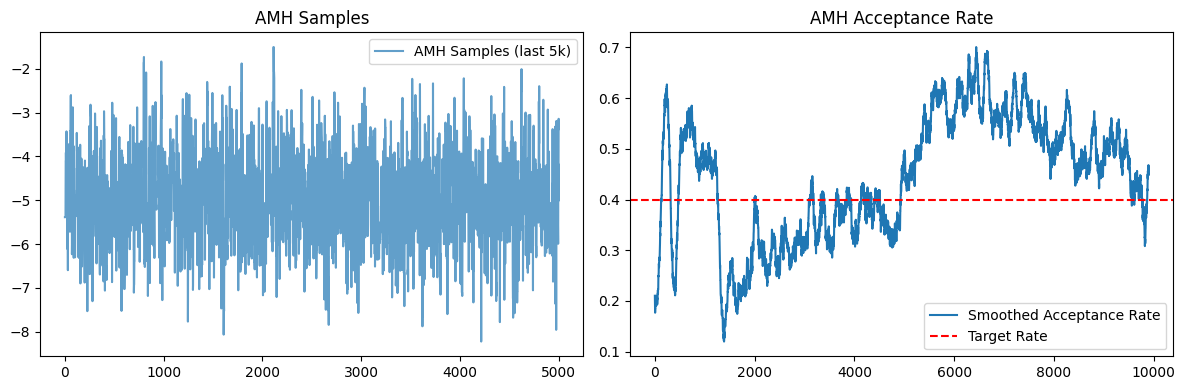

Pre-training Actor network...
Starting actor pre-training...
Pre-train Step 100, Avg Loss (last 100): 0.426961
Pre-train Step 200, Avg Loss (last 100): 0.002795
Pre-train Step 300, Avg Loss (last 100): 0.001793
Pre-train Step 400, Avg Loss (last 100): 0.001398
Pre-train Step 500, Avg Loss (last 100): 0.001243
Pre-train Step 600, Avg Loss (last 100): 0.001191
Pre-train Step 700, Avg Loss (last 100): 0.001177
Pre-train Step 800, Avg Loss (last 100): 0.001174
Pre-train Step 900, Avg Loss (last 100): 0.001174
Pre-train Step 1000, Avg Loss (last 100): 0.001174
Pre-train Step 1100, Avg Loss (last 100): 0.001174
Pre-train Step 1200, Avg Loss (last 100): 0.001174
Pre-train Step 1300, Avg Loss (last 100): 0.001174
Pre-train Step 1400, Avg Loss (last 100): 0.001174
Pre-train Step 1500, Avg Loss (last 100): 0.001174
Pre-train Step 1600, Avg Loss (last 100): 0.001174
Pre-train Step 1700, Avg Loss (last 100): 0.001174
Pre-train Step 1800, Avg Loss (last 100): 0.001174
Pre-train Step 1900, Avg Loss 

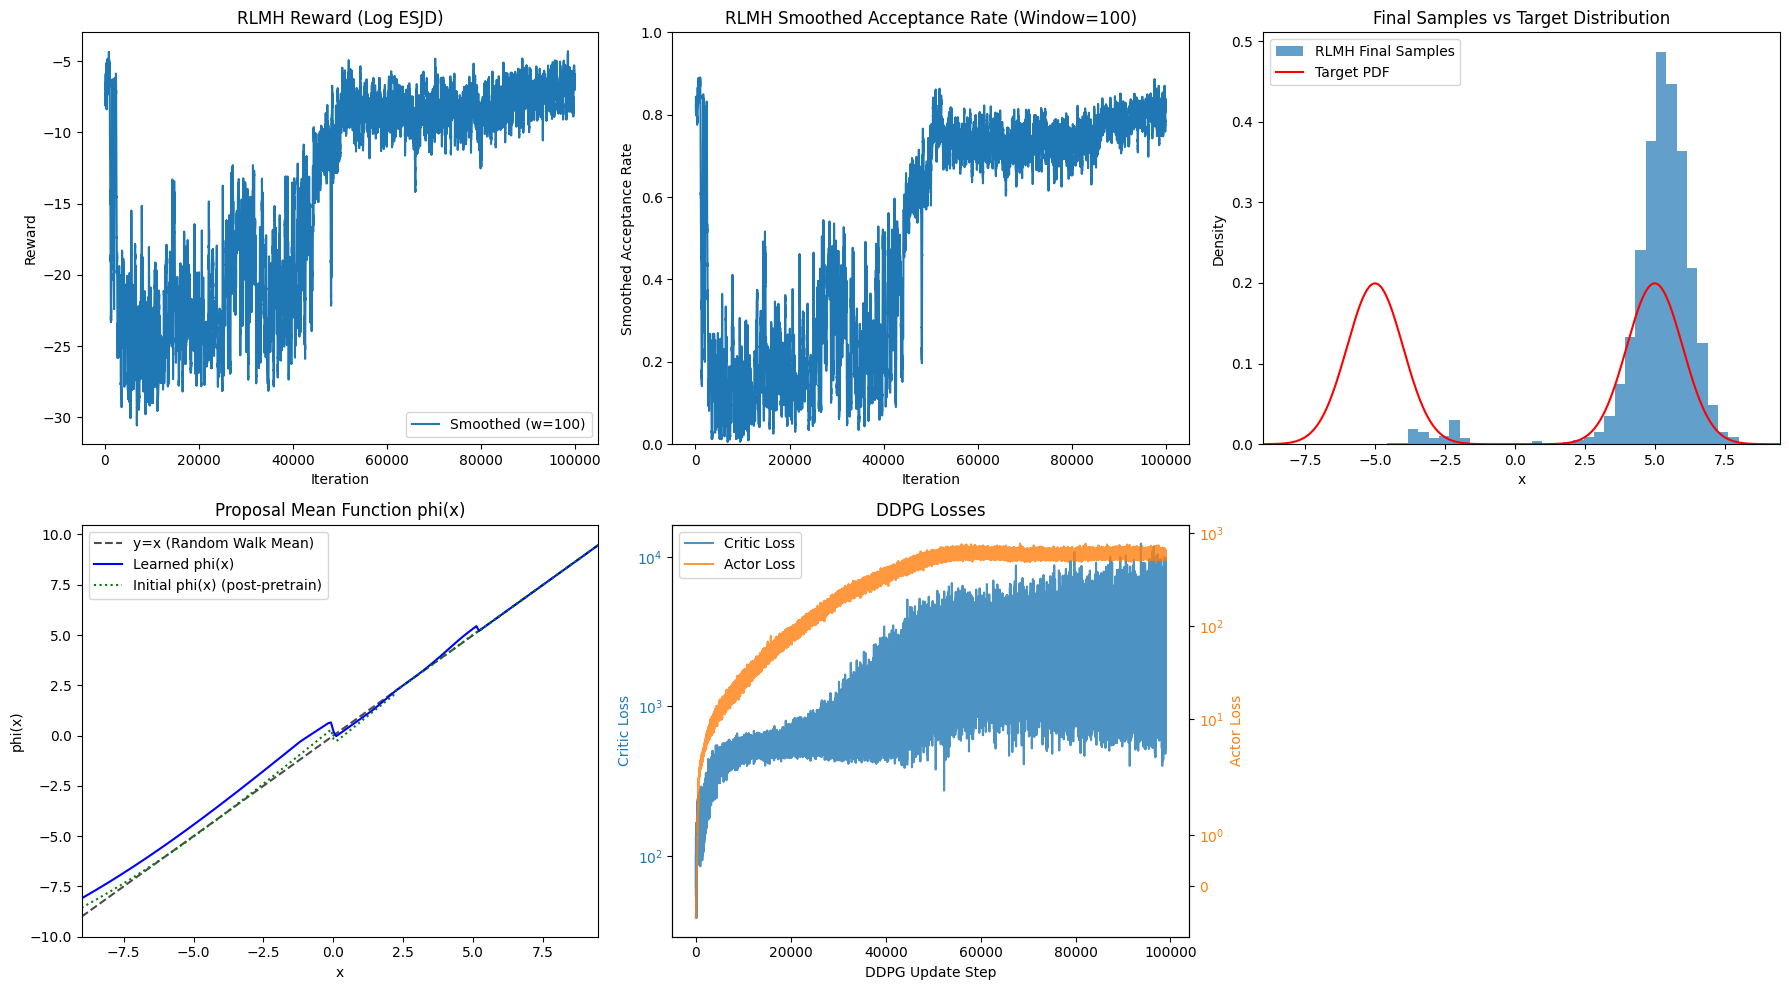

In [265]:
# %% Imports
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
from functools import partial
from typing import Sequence, Callable, Any
from flax.training import train_state  # Simple TrainState for managing params/opt
import random
import collections
import time
import numpy as np # For plotting and buffer
# Add these imports at the top of your main script
from flax.training import checkpoints # Or flax.serialization directly for older Flax
import os

# Configure JAX for CPU/GPU
# jax.config.update('jax_platform_name', 'cpu') # Or 'gpu'
jax.config.update("jax_enable_x64", True) # Use float64 for more MCMC stability

# %% Target Distribution (Example: Gaussian Mixture Model from Fig 1)
class GMMTarget:
    def __init__(self, means=jnp.array([-5.0, 5.0]), stds=jnp.array([1.0, 1.0]), weights=jnp.array([0.5, 0.5])):
        self.means = means
        self.stds = stds
        self.weights = weights
        self.dim = 1 # Hardcoded for 1D example
        # Precompute log weights and inverse variances
        self.log_weights = jnp.log(weights)
        self.inv_vars = 1.0 / (stds**2)
        self.log_norm_consts = -0.5 * jnp.log(2 * jnp.pi * stds**2)

    @partial(jax.jit, static_argnums=(0,))
    def log_prob(self, x):
        # Assumes x is a scalar or (1,) array for 1D
        x = jnp.squeeze(x) # Ensure scalar for broadcasting
        log_probs_components = self.log_norm_consts - 0.5 * (x - self.means)**2 * self.inv_vars
        log_likelihoods = self.log_weights + log_probs_components
        return jax.scipy.special.logsumexp(log_likelihoods)

    # Helper for plotting
    def pdf(self, x_grid):
         # Use vmap on the instance method
         return jnp.exp(jax.vmap(self.log_prob)(x_grid))

# Instantiate the target
target = GMMTarget()
target_log_prob = target.log_prob # Pass the method directly
target_dim = target.dim

# %% Adaptive Metropolis-Hastings (AMH) - Algorithm 3 Warm-up

# Correct decorator - Only m and target_log_prob are static
@partial(jax.jit, static_argnums=(1, 2))
def run_amh(key, m, target_log_prob, initial_mean, initial_cov, target_acceptance=0.234, beta=0.7):
    """Runs the AMH algorithm (Alg 3)."""

    dim = initial_mean.shape[0]
    Sigma_init = jnp.atleast_2d(initial_cov)

    def amh_scan_body(carry, i):
        key, x_prev, mu_prev, Sigma_prev, log_lambda_prev = carry
        key, subkey = jax.random.split(key)

        # --- Proposal ---
        lambda_prev = jnp.exp(log_lambda_prev)
        jitter = 1e-6 * jnp.eye(dim)
        chol_prev = jnp.linalg.cholesky(Sigma_prev + jitter)
        z = jax.random.normal(subkey, shape=(dim,))
        x_star = x_prev + lambda_prev * jnp.dot(chol_prev, z)

        # --- Acceptance ---
        log_prob_star = target_log_prob(x_star)
        log_prob_prev = target_log_prob(x_prev)
        log_alpha = jnp.minimum(0.0, log_prob_star - log_prob_prev)
        acceptance_prob = jnp.exp(log_alpha)

        # --- Accept/Reject ---
        key, subkey = jax.random.split(key)
        accept = jax.random.uniform(subkey) < acceptance_prob
        x_curr = jnp.where(accept, x_star, x_prev)

        # --- Adaptation ---
        gamma_i = 1.0 / ((i + 1)**beta)

        # Update log_lambda
        log_lambda_curr = log_lambda_prev + gamma_i * (acceptance_prob - target_acceptance)

        # Update mean
        mu_curr = mu_prev + gamma_i * (x_curr - mu_prev)

        # Update covariance
        diff = x_curr - mu_prev
        outer_prod = jnp.outer(diff, diff)
        Sigma_curr = Sigma_prev + gamma_i * (outer_prod - Sigma_prev)
        Sigma_curr = 0.5 * (Sigma_curr + Sigma_curr.T) # Ensure symmetry

        next_carry = (key, x_curr, mu_curr, Sigma_curr, log_lambda_curr)
        outputs = (x_curr, acceptance_prob)
        return next_carry, outputs

    # Initial state for the scan
    key, subkey = jax.random.split(key)
    x0 = jnp.zeros_like(initial_mean)
    mu0 = initial_mean
    log_lambda0 = jnp.log(2.38 / jnp.sqrt(dim))

    initial_carry = (subkey, x0, mu0, Sigma_init, log_lambda0)
    indices = jnp.arange(m)

    final_carry, outputs = jax.lax.scan(amh_scan_body, initial_carry, indices)

    _, _, final_mu, final_Sigma, final_log_lambda = final_carry
    samples, accept_probs = outputs
    return samples, final_mu, final_Sigma, accept_probs

# %% Flax Networks

class Actor(nn.Module):
    features: Sequence[int]
    action_dim: int
    max_action: float = 10.0 # FIX: Add max_action scaling

    @nn.compact
    def __call__(self, x):
        x = jnp.atleast_1d(x)
        for feat in self.features:
            x = nn.relu(nn.Dense(features=feat)(x))
        # FIX: Use tanh to bound output and scale
        psi_unscaled = nn.tanh(nn.Dense(features=self.action_dim)(x))
        psi = self.max_action * psi_unscaled
        return psi

class Critic(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, action):
        x = jnp.atleast_1d(x)
        action = jnp.atleast_1d(action)
        concat = jnp.concatenate([x, action], axis=-1)
        for feat in self.features:
            concat = nn.relu(nn.Dense(features=feat)(concat))
        q_value = nn.Dense(features=1)(concat)
        return jnp.squeeze(q_value)


# %% Policy Construction and Helper Functions (Eq. 30, App B.3/B.4)

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq',))
def gamma_C(x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Smooth transition function gamma_C(x)."""
    x = jnp.atleast_1d(x) # Ensure vector ops work
    x_bar = jnp.atleast_1d(x_bar)
    diff = x - x_bar
    # Ensure Sigma_inv_sqrt is 2D
    Sigma_inv_sqrt_2d = jnp.atleast_2d(Sigma_inv_sqrt)
    # Correct matrix multiplication for vector diff
    eta_num = jnp.dot(diff.T, Sigma_inv_sqrt_2d.T @ Sigma_inv_sqrt_2d @ diff)
    eta = eta_num / ellipsoid_radius_sq

    val_case1 = 0.0
    # Add epsilon for stability in denominator
    val_case2 = 1.0 / (1.0 + jnp.exp(-(4*eta - 3) / (4*eta**2 - 6*eta + 2 + 1e-8)))
    val_case3 = 1.0

    gamma = jnp.where(eta < 0.5, val_case1, jnp.where(eta <= 1.0, val_case2, val_case3))
    return gamma

@partial(jax.jit, static_argnames=('ellipsoid_radius_sq',))
def construct_phi(psi, x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Constructs phi_theta(x) from psi_theta(x) using Eq. 30."""
    psi = jnp.atleast_1d(psi)
    x = jnp.atleast_1d(x)
    g = gamma_C(x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    phi = psi + g * (x - psi)
    return phi

@jax.jit
def calculate_l1_sigma_norm(y, mu, Sigma_inv_sqrt):
    """Calculates ||y - mu||_{1, Sigma} = ||Sigma^{-1/2}(y - mu)||_1."""
    y = jnp.atleast_1d(y)
    mu = jnp.atleast_1d(mu)
    diff = y - mu
    # Ensure Sigma_inv_sqrt is 2D
    Sigma_inv_sqrt_2d = jnp.atleast_2d(Sigma_inv_sqrt)
    transformed_diff = jnp.dot(Sigma_inv_sqrt_2d, diff)
    return jnp.sum(jnp.abs(transformed_diff))

# Correct decorator - actor_apply is static
@partial(jax.jit, static_argnames=('ellipsoid_radius_sq', 'actor_apply'))
def proposal_log_prob_laplace(y, x, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq):
    """Calculates log q(y|x) based on Laplace density (Eq. 6, ignoring normalization)."""
    psi = actor_apply({'params': actor_params}, x)
    phi = construct_phi(psi, x, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    norm_val = calculate_l1_sigma_norm(y, phi, Sigma_inv_sqrt)
    return -norm_val

# Correct decorator - actor_apply and target_log_prob are static
@partial(jax.jit, static_argnames=('ellipsoid_radius_sq','target_log_prob', 'actor_apply'))
def calculate_acceptance_log_prob(x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq, target_log_prob):
    """Calculates the log MH acceptance probability log alpha_phi (Eq. 2)."""
    log_target_ratio = target_log_prob(x_star) - target_log_prob(x_n)

    log_q_reverse = proposal_log_prob_laplace(x_n, x_star, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    log_q_forward = proposal_log_prob_laplace(x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    log_proposal_ratio = log_q_reverse - log_q_forward

    return jnp.minimum(0.0, log_target_ratio + log_proposal_ratio)

@jax.jit
def calculate_reward(x_next, x_n, log_acceptance_prob):
    """Calculates the log ESJD reward."""
    x_next = jnp.atleast_1d(x_next)
    x_n = jnp.atleast_1d(x_n)

    sq_jump_dist = jnp.sum((x_next - x_n)**2)
    log_sq_jump = jnp.log(sq_jump_dist + 1e-10) # Add epsilon for stability
    reward = log_sq_jump + log_acceptance_prob # Formula from Sec 2.2

    return reward


# %% Replay Buffer

class ReplayBuffer:
    def __init__(self, capacity, reward_clip_range=(-50.0, 50.0)): # FIX: Add reward clipping
        self.buffer = collections.deque(maxlen=capacity)
        self.reward_clip_range = reward_clip_range

    def add(self, state, action, reward, next_state, done):
        # FIX: Clip reward here before storing
        # Ensure reward is a numpy scalar/array before clipping
        reward_np = np.array(reward)
        reward_clipped = np.clip(reward_np, self.reward_clip_range[0], self.reward_clip_range[1])
        self.buffer.append((np.array(state), np.array(action), reward_clipped, np.array(next_state), done))

    def sample(self, batch_size):
        if batch_size > len(self.buffer): # Avoid error if buffer not full
             batch_size = len(self.buffer)
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*(self.buffer[i] for i in indices))
        return jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(next_states), jnp.array(dones)

    def __len__(self):
        return len(self.buffer)

# %% DDPG Training Step

# Correct decorator - actor_apply and critic_apply are static
@partial(jax.jit, static_argnames=('actor_apply', 'critic_apply', 'discount', 'tau_polyak'))
def ddpg_update(
    key,
    actor_state, critic_state, # Flax TrainState (params + opt_state)
    target_actor_params, target_critic_params, # Just params
    actor_apply, critic_apply, # Network apply functions
    batch, # Sampled from replay buffer
    discount, # Gamma (DDPG discount factor)
    tau_polyak, # For updating target networks
    ):
    states, actions, rewards, next_states, dones = batch

    # --- Critic Update ---
    next_actions = actor_apply({'params': target_actor_params}, next_states)
    next_q = critic_apply({'params': target_critic_params}, next_states, next_actions)
    target_q = rewards + discount * (1. - dones) * next_q

    def critic_loss_fn(critic_params):
        current_q = critic_apply({'params': critic_params}, states, actions)
        loss = jnp.mean((current_q - target_q)**2)
        return loss

    critic_loss_val, critic_grads = jax.value_and_grad(critic_loss_fn)(critic_state.params)
    critic_state = critic_state.apply_gradients(grads=critic_grads)

    # --- Actor Update ---
    def actor_loss_fn(actor_params):
        current_actions = actor_apply({'params': actor_params}, states)
        # Use updated critic params for actor gradient calculation
        current_q = critic_apply({'params': critic_state.params}, states, current_actions)
        loss = -jnp.mean(current_q)
        return loss

    actor_loss_val, actor_grads = jax.value_and_grad(actor_loss_fn)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=actor_grads) # Clipping handled by optimizer


    # --- Update Target Networks (Polyak Averaging) ---
    # Use jax.tree.map instead of deprecated jax.tree_map
    new_target_actor_params = jax.tree.map(
        lambda target, online: target * (1.0 - tau_polyak) + online * tau_polyak,
        target_actor_params, actor_state.params
    )
    new_target_critic_params = jax.tree.map(
        lambda target, online: target * (1.0 - tau_polyak) + online * tau_polyak,
        target_critic_params, critic_state.params
    )

    metrics = {'critic_loss': critic_loss_val, 'actor_loss': actor_loss_val}
    return actor_state, critic_state, new_target_actor_params, new_target_critic_params, metrics


# %% RLMH Environment Step Function

# Correct decorator - actor_apply and target_log_prob are static
@partial(jax.jit, static_argnames=(
    'actor_apply', 'ellipsoid_radius_sq', 'target_log_prob', 'proposal_scale'
))
def rlmh_step(
    key,
    x_n, # Current MCMC state
    actor_params, # Current actor parameters
    actor_apply, # <<<< STATIC
    x_bar, Sigma_sqrt, Sigma_inv_sqrt, # From AMH
    ellipsoid_radius_sq, # <<<< STATIC
    target_log_prob, # <<<< STATIC
    proposal_scale # <<<< STATIC
    ):
    """Performs one step of the RLMH algorithm."""
    key, proposal_key, accept_key = jax.random.split(key, 3)

    psi_n = actor_apply({'params': actor_params}, x_n)
    phi_n = construct_phi(psi_n, x_n, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)

    # Propose x* ~ N(phi_n, proposal_scale^2 * Sigma)
    z = jax.random.normal(proposal_key, shape=x_n.shape)
    # Ensure Sigma_sqrt is 2D
    Sigma_sqrt_2d = jnp.atleast_2d(Sigma_sqrt)
    x_star = phi_n + proposal_scale * jnp.dot(Sigma_sqrt_2d, z)

    # Calculate acceptance log probability using LAPLACE densities
    log_alpha = calculate_acceptance_log_prob(
        x_star, x_n, actor_apply, actor_params, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq, target_log_prob
    )
    acceptance_prob = jnp.exp(log_alpha)

    # Accept or reject
    accept = jax.random.uniform(accept_key) < acceptance_prob
    x_next = jnp.where(accept, x_star, x_n)

    # Calculate reward
    reward = calculate_reward(x_next, x_n, log_alpha)

    state = x_n
    action = psi_n
    next_state = x_next
    done = False

    return state, action, reward, next_state, done, acceptance_prob

# %% Pre-training Function

# Correct JIT handling - JIT the inner step, print outside
# FIX: Pass actor_max_action explicitly
def pretrain_actor(key, actor_state, amh_samples, actor_apply, actor_max_action, pretrain_steps):
    """Pre-trains the actor psi_theta(x) to approximate x."""
    n_samples = amh_samples.shape[0]

    # Access max_action outside the JITted function
    max_action_val = actor_max_action

    @jax.jit # JIT the core training step
    def train_step(current_actor_state):
        def loss_fn(params):
            # Predict psi for all AMH samples
            psi_pred = jax.vmap(lambda x: actor_apply({'params': params}, x))(amh_samples)

            # Target is the input sample x itself, clipped to the actor's output range
            # Use max_action_val defined outside JIT scope
            target_psi = jnp.clip(amh_samples, -max_action_val, max_action_val)

            loss = jnp.mean((psi_pred - target_psi)**2)
            return loss

        loss, grads = jax.value_and_grad(loss_fn)(current_actor_state.params)
        new_actor_state = current_actor_state.apply_gradients(grads=grads)
        return new_actor_state, loss

    print("Starting actor pre-training...")
    total_loss = 0.0
    for step in range(pretrain_steps):
        actor_state, loss = train_step(actor_state) # Call the JITted step
        total_loss += loss
        if (step + 1) % 100 == 0:
            # Ensure loss is a concrete value before printing
            avg_loss = np.array(total_loss) / 100 # Convert to numpy for printing
            print(f"Pre-train Step {step + 1}, Avg Loss (last 100): {avg_loss:.6f}")
            total_loss = 0.0 # Reset loss accumulator

    print("Pre-training finished.")
    return actor_state


# %% Main Setup and Training Loop

def main_rlmh_training():
    # --- Hyperparameters ---
    amh_iterations = 10000
    amh_target_acceptance = 0.4
    amh_beta = 0.7
    rlmh_iterations = 100_000
    proposal_scale = 0.5
    ellipsoid_radius = 10.0
    gradient_clip_tau_actor = 1.0   # FIX: Actor grad clipping
    gradient_clip_tau_critic = 10.0 # FIX: Critic grad clipping
    reward_clip_range = (-60.0, 60.0) # FIX: Reward clipping range

    replay_capacity = 100000
    batch_size = 64
    ddpg_discount = 0.99
    actor_lr = 1e-6 # FIX: Reduced LR
    critic_lr = 1e-5 # FIX: Reduced LR
    tau_polyak = 0.005
    warmup_steps = 1000

    pretrain_steps = 3_000
    pretrain_lr = 1e-3

    actor_features = [32, 32]
    critic_features = [64, 64]
    actor_max_action = 15.0 # FIX: Set max action bound (adjust based on target range)

    key = jax.random.PRNGKey(42)

    # --- 1. AMH Warm-up ---
    print("Running AMH Warm-up...")
    key, amh_key = jax.random.split(key)
    amh_initial_mean = jnp.zeros(target_dim)
    amh_initial_cov = jnp.eye(target_dim) * 1.0

    amh_samples, final_mu, final_Sigma, amh_accept_probs = run_amh(
        amh_key, amh_iterations, target_log_prob, amh_initial_mean, amh_initial_cov,
        target_acceptance=amh_target_acceptance, beta=amh_beta
    )
    print(f"AMH finished. Final Mean: {final_mu}, Acceptance Rate: {jnp.mean(amh_accept_probs):.3f}")

    x_bar = final_mu
    jitter = 1e-6 * jnp.eye(target_dim)
    Sigma = 0.5 * (final_Sigma + final_Sigma.T) + jitter
    try:
        Sigma_sqrt = jnp.linalg.cholesky(Sigma)
        Sigma_inv = jnp.linalg.inv(Sigma)
        Sigma_inv_sqrt = jnp.linalg.cholesky(Sigma_inv).T # Inverse of sqrt is transpose of cholesky of inverse
    except jnp.linalg.LinAlgError:
         print("Warning: Final Sigma from AMH not positive definite. Using Identity.")
         Sigma = jnp.eye(target_dim)
         Sigma_sqrt = jnp.eye(target_dim)
         Sigma_inv_sqrt = jnp.eye(target_dim)

    ellipsoid_radius_sq = ellipsoid_radius**2

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(amh_samples[-5000:], label='AMH Samples (last 5k)', alpha=0.7)
    plt.title('AMH Samples')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(jnp.convolve(amh_accept_probs, jnp.ones(100)/100, mode='valid'), label='Smoothed Acceptance Rate')
    plt.axhline(amh_target_acceptance, color='r', linestyle='--', label='Target Rate')
    plt.title('AMH Acceptance Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 2. Initialize Networks and Optimizers ---
    key, actor_key, critic_key = jax.random.split(key, 3)
    dummy_state = jnp.zeros((target_dim,))
    dummy_action = jnp.zeros((target_dim,))

    # FIX: Instantiate actor with max_action
    actor = Actor(features=actor_features, action_dim=target_dim, max_action=actor_max_action)
    critic = Critic(features=critic_features)

    actor_params = actor.init(actor_key, dummy_state)['params']
    critic_params = critic.init(critic_key, dummy_state, dummy_action)['params']

    # FIX: Optimizers with gradient clipping
    actor_optimizer = optax.chain(
        optax.clip_by_global_norm(gradient_clip_tau_actor),
        optax.adam(learning_rate=actor_lr)
    )
    critic_optimizer = optax.chain(
        optax.clip_by_global_norm(gradient_clip_tau_critic),
        optax.adam(learning_rate=critic_lr)
    )

    actor_state = train_state.TrainState.create(apply_fn=actor.apply, params=actor_params, tx=actor_optimizer)
    critic_state = train_state.TrainState.create(apply_fn=critic.apply, params=critic_params, tx=critic_optimizer)

    target_actor_params = actor_params
    target_critic_params = critic_params

    # --- 3. Pre-train Actor ---
    print("Pre-training Actor network...")
    key, pretrain_key = jax.random.split(key)
    pretrain_optimizer = optax.adam(learning_rate=pretrain_lr)
    # Create a new state for pretraining
    pretrain_actor_state = train_state.TrainState.create(
        apply_fn=actor.apply, # Store apply_fn
        params=actor_state.params, # Start with current params
        tx=pretrain_optimizer
    )
    pretrain_samples = amh_samples

    # FIX: Pass actor.apply and actor.max_action explicitly
    pretrain_actor_state = pretrain_actor(
        pretrain_key,
        pretrain_actor_state,
        pretrain_samples,
        actor.apply, # Pass the method
        actor.max_action, # Pass the attribute value
        pretrain_steps
    )
    # Update the main actor state with pre-trained parameters
    actor_state = actor_state.replace(params=pretrain_actor_state.params)
    # Also update the target network to reflect pre-training
    target_actor_params = actor_state.params
    print("Actor pre-training complete.")

    # --- 4. RLMH + DDPG Training Loop ---
    print("Starting RLMH + DDPG training...")
    # FIX: Initialize buffer with reward clipping range
    replay_buffer = ReplayBuffer(replay_capacity, reward_clip_range=reward_clip_range)
    rewards_history = []
    accept_history = []
    critic_loss_history = []
    actor_loss_history = []
    last_metrics = {} # Store last metrics for logging

    current_x = amh_samples[-1]

    start_time_loop = time.time()
    for i in range(rlmh_iterations):
        key, step_key, buffer_key, update_key = jax.random.split(key, 4)

        # --- RLMH Environment Step ---
        state, action, reward, next_state, done, accept_prob = rlmh_step(
            step_key, current_x, actor_state.params, actor.apply,
            x_bar, Sigma_sqrt, Sigma_inv_sqrt, ellipsoid_radius_sq,
            target_log_prob, proposal_scale
        )

        replay_buffer.add(state, action, reward, next_state, done) # Reward clipped inside buffer.add
        rewards_history.append(np.array(reward)) # Store original reward as numpy
        accept_history.append(np.array(accept_prob)) # Store as numpy
        current_x = next_state

        # --- DDPG Update Step ---
        if len(replay_buffer) > warmup_steps:
             # Pass apply methods correctly
             batch = replay_buffer.sample(batch_size)
             actor_state, critic_state, target_actor_params, target_critic_params, metrics = ddpg_update(
                 update_key,
                 actor_state, critic_state,
                 target_actor_params, target_critic_params,
                 actor.apply, critic.apply, # Pass methods
                 batch,
                 ddpg_discount, tau_polyak
             )
             # Convert metrics to numpy for storage/logging
             metrics_np = jax.tree_util.tree_map(np.array, metrics)
             critic_loss_history.append(metrics_np['critic_loss'])
             actor_loss_history.append(metrics_np['actor_loss'])
             last_metrics = metrics_np # Keep last metrics

        # --- Logging ---
        if (i + 1) % 1000 == 0:
            end_time_loop = time.time()
            # Calculate averages using numpy
            avg_reward = np.mean(rewards_history[-1000:]) if len(rewards_history) >= 1000 else np.mean(rewards_history)
            avg_accept = np.mean(accept_history[-1000:]) if len(accept_history) >= 1000 else np.mean(accept_history)

            print(f"Iteration {i+1}/{rlmh_iterations}, "
                  f"Avg Reward (last 1k): {avg_reward:.3f}, "
                  f"Avg Accept (last 1k): {avg_accept:.3f}, "
                  f"Buffer Size: {len(replay_buffer)}, "
                  f"Time/1k iter: {end_time_loop - start_time_loop:.2f}s")
            if last_metrics: # Check if metrics dictionary is populated
                 print(f"  Avg Critic Loss (last batch): {last_metrics['critic_loss']:.3f}, "
                       f"Avg Actor Loss (last batch): {last_metrics['actor_loss']:.3f}")
            start_time_loop = time.time()

    print("RLMH training finished.")

    # --- AT THE END of main_rlmh_training() ---

    print("RLMH training finished.")

    # --- Save required components ---

    # Define the relative directory name
    save_dir_relative = "rlmh_trained_model"

    # Create the absolute path
    save_dir_absolute = os.path.abspath(save_dir_relative)
    os.makedirs(save_dir_absolute, exist_ok=True) # Create dir using absolute path

    save_dir = "./rlmh_trained_model"
    os.makedirs(save_dir, exist_ok=True)

    # Save Flax parameters (actor state) using the absolute path
    checkpoints.save_checkpoint(ckpt_dir=save_dir_absolute, # USE ABSOLUTE PATH HERE
                                target=actor_state,
                                step=rlmh_iterations,
                                prefix="actor_checkpoint_",
                                overwrite=True)
    print(f"Saved actor state to {save_dir_absolute}")

    # Save AMH results and hyperparameters (using absolute path is good practice too)
    amh_save_path = os.path.join(save_dir_absolute, "amh_hyperparams.npz")
    # Convert JAX arrays to NumPy for saving if not using specialized savers
    amh_results = {
        "x_bar": np.array(x_bar),
        "Sigma_sqrt": np.array(Sigma_sqrt),
        "Sigma_inv_sqrt": np.array(Sigma_inv_sqrt),
        "ellipsoid_radius_sq": np.array(ellipsoid_radius_sq),
        "actor_max_action": np.array(actor_max_action),
        "proposal_scale": np.array(proposal_scale),
        "target_dim": np.array(target_dim) # Save dimension too
    }
    np.savez(amh_save_path, **amh_results)
    print(f"Saved AMH results and hyperparameters to {amh_save_path}")

    # --- 5. Generate Final Samples & Visualize ---
    print("Generating final samples with learned policy...")
    final_samples = []
    key, final_sample_key = jax.random.split(key)
    current_x = amh_samples[-1]
    n_final_samples = 5000

    for _ in range(n_final_samples):
        final_sample_key, step_key = jax.random.split(final_sample_key)
        _, _, _, next_state, _, _ = rlmh_step(
            step_key, current_x, actor_state.params, actor.apply,
            x_bar, Sigma_sqrt, Sigma_inv_sqrt, ellipsoid_radius_sq,
            target_log_prob, proposal_scale
        )
        final_samples.append(np.array(next_state)) # Store as numpy
        current_x = next_state

    final_samples = np.array(final_samples) # Convert list of arrays to single numpy array

    

    # --- Visualization ---
    plt.figure(figsize=(18, 10))
    smoothing_window = 100

    # Reward History
    plt.subplot(2, 3, 1)
    rewards_np = np.array(rewards_history) # Ensure numpy array
    if len(rewards_np) >= smoothing_window:
        smoothed_rewards = np.convolve(rewards_np, np.ones(smoothing_window)/smoothing_window, mode='valid')
        plot_indices_reward = np.arange(smoothing_window - 1, len(rewards_np))
        plt.plot(plot_indices_reward, smoothed_rewards, label=f'Smoothed (w={smoothing_window})')
    # plt.plot(rewards_history, alpha=0.3, label='Raw') # Optional: Plot raw reward
    plt.title('RLMH Reward (Log ESJD)')
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.legend()

    # Acceptance Rate History
    plt.subplot(2, 3, 2)
    accept_np = np.array(accept_history) # Ensure numpy array
    if len(accept_np) >= smoothing_window:
        smoothed_accept = np.convolve(accept_np, np.ones(smoothing_window)/smoothing_window, mode='valid')
        plot_indices_accept = np.arange(smoothing_window - 1, len(accept_np))
        plt.plot(plot_indices_accept, smoothed_accept)
    plt.title(f'RLMH Smoothed Acceptance Rate (Window={smoothing_window})')
    plt.xlabel('Iteration')
    plt.ylabel('Smoothed Acceptance Rate')
    plt.ylim(0, 1)

    # Final Sample Histogram vs Target PDF
    plt.subplot(2, 3, 3)
    # Ensure final_samples is numpy for min/max
    hist_min = min(np.min(final_samples), -8) - 1
    hist_max = max(np.max(final_samples), 8) + 1
    x_plot_pdf = jnp.linspace(hist_min, hist_max, 500)
    target_pdf_plot = target.pdf(x_plot_pdf) # Already JAX array
    plt.hist(final_samples, bins=50, density=True, alpha=0.7, label='RLMH Final Samples', range=(hist_min, hist_max))
    plt.plot(np.array(x_plot_pdf), np.array(target_pdf_plot), 'r-', label='Target PDF') # Convert to numpy for plotting
    plt.title('Final Samples vs Target Distribution')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(hist_min, hist_max)


    # Learned phi(x) function
    plt.subplot(2, 3, 4)
    x_plot_phi = jnp.linspace(hist_min, hist_max, 200) # Use consistent range

    # Final learned phi
    psi_learned = jax.vmap(lambda x: actor.apply({'params': actor_state.params}, x))(x_plot_phi[:, None])
    phi_learned = jax.vmap(construct_phi, in_axes=(0, 0, None, None, None))(
        psi_learned, x_plot_phi, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq
    )
    plt.plot(np.array(x_plot_phi), np.array(x_plot_phi), 'k--', label='y=x (Random Walk Mean)', alpha=0.7)
    plt.plot(np.array(x_plot_phi), np.array(phi_learned), 'b-', label='Learned phi(x)') # Convert to numpy

    # Initial phi(x) after pre-training
    pretrain_actor_params_final = pretrain_actor_state.params
    print("\n--- Plotting Initial Phi ---")
    print(f"Using x_bar: {x_bar}")
    print(f"Using ellipsoid_radius_sq: {ellipsoid_radius_sq}")
    psi_initial = jax.vmap(lambda x: actor.apply({'params': pretrain_actor_params_final}, x))(x_plot_phi[:, None])
    phi_initial = jax.vmap(construct_phi, in_axes=(0, 0, None, None, None))(
        psi_initial, x_plot_phi, x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq
    )
    # Debug print calculation for x=0
    test_x_plot_index = jnp.argmin(jnp.abs(x_plot_phi - 0.0))
    test_x_val = x_plot_phi[test_x_plot_index]
    test_psi_val = psi_initial[test_x_plot_index][0]
    # Ensure test_x_val is passed as a 1D JAX array to gamma_C
    test_gamma_val = gamma_C(jnp.array([test_x_val]), x_bar, Sigma_inv_sqrt, ellipsoid_radius_sq)
    test_phi_val = phi_initial[test_x_plot_index][0]
    print(f"Example point x={np.array(test_x_val):.2f}: psi_initial={np.array(test_psi_val):.2f}, gamma_C={np.array(test_gamma_val):.2f}, phi_initial={np.array(test_phi_val):.2f} (Should be approx x)")

    plt.plot(np.array(x_plot_phi), np.array(phi_initial), 'g:', label='Initial phi(x) (post-pretrain)') # Convert to numpy
    plt.title('Proposal Mean Function phi(x)')
    plt.xlabel('x')
    plt.ylabel('phi(x)')
    plt.legend()
    # Adaptive y-limits using numpy min/max
    phi_min = min(np.min(phi_learned), np.min(phi_initial), hist_min) - 1
    phi_max = max(np.max(phi_learned), np.max(phi_initial), hist_max) + 1
    plt.ylim(phi_min, phi_max)
    plt.xlim(hist_min, hist_max)


    # DDPG Losses
    plt.subplot(2, 3, 5)
    if critic_loss_history:
        critic_loss_np = np.array(critic_loss_history)
        actor_loss_np = np.array(actor_loss_history)
        loss_plot_indices = np.arange(len(critic_loss_np))

        ax1 = plt.gca()
        color1 = 'tab:blue'
        ax1.set_xlabel('DDPG Update Step')
        ax1.set_ylabel('Critic Loss', color=color1)
        ax1.plot(loss_plot_indices, critic_loss_np, color=color1, label='Critic Loss', alpha=0.8)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.set_yscale('symlog') # Use symlog for large range

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color2 = 'tab:orange'
        ax2.set_ylabel('Actor Loss', color=color2)
        ax2.plot(loss_plot_indices, actor_loss_np, color=color2, label='Actor Loss', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.set_yscale('symlog') # Use symlog for potentially large negative range

        plt.title('DDPG Losses')
        # Add legends together
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)
    else:
        plt.title("DDPG Losses (No updates yet)")


    plt.tight_layout()
    plt.show()




# %% Run Training
if __name__ == "__main__":
    main_rlmh_training()